In [1]:
library(caret)
library(corrplot)
library(biomaRt)
library(MLeval)
library(GeneAnswers) # used to get gene names from entrez IDs

Loading required package: lattice

Loading required package: ggplot2

corrplot 0.90 loaded

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: RCurl

Loading required package: annotate

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:igraph’:

    normalize, path, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are mask

In [ ]:
load("SavedGeneExpression.Rda")

# Literature Survey

[Mechanism-driven biomarkers to guide immune checkpoint blockade in cancer therapy
Topalian et al, 2016](https://www.nature.com/articles/nrc.2016.36)<br>
[The evolving landscape of biomarkers for checkpoint inhibitor immunotherapy
Havel et al, 2019](https://www.nature.com/articles/s41568-019-0116-x)

In [221]:
path <- "/home/jp/ICP_Responders/Literature Review/GenesOfInterest.csv"
genes_lit_sur <- read.csv(path)
head(genes_lit_sur)

Gene           ID   
1 PDCD1/CD279     5133
2 CD274(PDL1)    29126
3 PDCD1LG2(PDL2) 80380
4 CTLA4           1493
5 CD8A             925
6 CD4              920

In [218]:
for (i in 1:49){
    cat(getSymbols(as.character(genes_lit_sur$ID), 'org.Hs.eg.db')[[i]])
    cat(", ")
    }

PDCD1, CD274, PDCD1LG2, CTLA4, CD8A, CD4, CD28, CD80, CD86, BRAF, EGFR, ALK, PTEN, STAT3, STK11, KRAS, HLA-C, TRBV20OR9-2, IL10, TGFB1, IDO1, LAG3, HAVCR2, CD276, ENTPD1, NT5E, IGKV2D-29, MLANA, PMEL, TYR, POLE, POLD1, TP53, PBRM1, SERPINB3, SERPINB4, CDK4, CDK6, PTPN2, APLNR, SMARCA1, MAGEA3, TAP1, TAP2, FOXP3, CXCL13, VEGFA, JAK2, B2M, 

# Pre-Processing
1) Clean data by removing rows with > 50% missing info <br>
2) Find the most informative features <br>
3) Split the data into test and train


## Load AntiPD1 data
The first column is expected to be sample ID <br>

In [3]:
path <- "/home/jp/ICP_Responders/DataCollectionFormatting/MergeTables/GideHugoRiaz_AntiPD1.csv"
GideHugoRiaz_AntiPD1 <- read.csv(path, check.names=FALSE, stringsAsFactors=FALSE)
GideHugoRiaz_AntiPD1[ GideHugoRiaz_AntiPD1 == "NA" ] <- NA
dim(GideHugoRiaz_AntiPD1)
head(GideHugoRiaz_AntiPD1)

[1]   117 16018

Patient OS  OS.Event RECIST Age Gender Response 1           503538    
1  1      147 1        0      48  1      0                 NA         NA
2 10      551 0        0      90  0      0         0.44967917 -0.1256063
3 11      166 1        0      66  0      0        -1.16982847 -0.6828899
4 12      199 1        1      52  0      0        -0.04601746  1.5028679
5 13       96 1        0      69  0      0         0.67577556 -0.4820313
6 14      993 1        0      58  0      0        -0.11535008 -0.1847109
  2          ⋯ 11130      7789          158586     79364       440590     
1         NA ⋯         NA            NA         NA          NA          NA
2 -0.9428421 ⋯  1.5168029  0.2051403085  0.2497006  0.50803986  0.70851142
3 -0.8272336 ⋯ -1.0120033  0.0005757279 -0.4148035  0.05113678  0.09727642
4 -0.8496055 ⋯ -0.6297312  0.1098136507 -0.4097749 -0.18345745  0.16842307
5 -1.6330965 ⋯  1.1309116 -0.2777108820 -0.1297598 -0.06003260 -0.12662805
6 -0.4553360 ⋯ -0.1761315 -0.3655941746 -0.7592193  0.41185003 -0.11559656
  79699       7791       23140      26009       Source     
1          NA         NA         NA          NA GideAntiPD1
2  0.45721398 -0.7961158  0.2429606  1.18213316 GideAntiPD1
3 -0.16385787 -0.2469282  0.1171039 -0.74993078 GideAntiPD1
4 -0.19196153  0.6580495  0.9784882 -0.27105096 GideAntiPD1
5 -0.13856663 -1.2178791 -0.2099152  0.08612588 GideAntiPD1
6 -0.05134074 -0.2665028 -0.3051941 -0.84401986 GideAntiPD1

## Clean data

In [4]:
# Check which column has > 50% NA values
countNA <- function(x=NULL,cutOff=NULL){
  output<-FALSE
  perc<-sum(is.na(x))*100/length(x)
  if(perc>cutOff){output<-TRUE}
  output  
}
col_nas <- apply(GideHugoRiaz_AntiPD1,2,function(x){countNA(x, 50)})
cat("Columns with NAs > 50% = ", sum(col_nas), "\n")
# all columns have <50% NAs

# Check which rows has > 50% NA values
row_nas <- apply(GideHugoRiaz_AntiPD1,1,function(x){countNA(x, 50)})
cat("Rows with NAs > 50% = ", sum(row_nas), "\n")

# 25 rows have >50% NAs, removing them
GideHugoRiaz_AntiPD1_filtered <- GideHugoRiaz_AntiPD1[-which(row_nas %in% TRUE),]

cat("Dimensions of the filtered dataset = ", dim(GideHugoRiaz_AntiPD1_filtered))

Columns with NAs > 50% =  0 
Rows with NAs > 50% =  25 
Dimensions of the filtered dataset =  92 16018

## Look for near zero variance and remove those columns

In [6]:
nzv <- nearZeroVar(GideHugoRiaz_AntiPD1_filtered[, -which(colnames(GideHugoRiaz_AntiPD1_filtered) %in% 
                                                         c("Patient, Response, Gender"))], saveMetrics= TRUE)
nzv[which(nzv$zeroVar %in% TRUE), ]

# All features were retained and there was no filtering due to near zero variance

freqRatio percentUnique zeroVar nzv

## Look for correlation and remove highly correlated columns

In [22]:
exp_feat <- grep("[0-9]",colnames(GideHugoRiaz_AntiPD1_filtered))

In [28]:
# find attributes that are highly corrected (ideally >0.75)
tmp <- GideHugoRiaz_AntiPD1_filtered
tmp[is.na(tmp)] <- 0
expr_corr <-  cor(tmp[,c(exp_feat)]) 
highlyCorrelated <- findCorrelation(expr_corr, cutoff=0.75, names=TRUE, verbose=FALSE)
length(highlyCorrelated)
highlyCorrelated <- highlyCorrelated[highlyCorrelated %in% c(as.character(genes_lit_sur$ID)) == FALSE]   
length(highlyCorrelated)
GideHugoRiaz_AntiPD1_rmcorr <- GideHugoRiaz_AntiPD1_filtered[, -which(colnames(GideHugoRiaz_AntiPD1_filtered) 
                                                                      %in% highlyCorrelated)]



[1] 1736

[1] 1719

## Linear dependencies(not used)
NOTE: Linear Dependencies were not used because
1) A large number of features from columns 157 to 400 were flagged as linearly dependent to columns 1 to 156 <br>
2) We will rely on feature importance and the robustness of the model selected to identify the most important features hence linear dependencies can become redundant

In [29]:
cat("Started with dimension = ", dim(GideHugoRiaz_AntiPD1), "\n")
cat("Post 50% NA filtering in rows and columns the dimension is", dim(GideHugoRiaz_AntiPD1_filtered), "\n")
cat("Post filtering highly correlated columns the dimension is", dim(GideHugoRiaz_AntiPD1_rmcorr), "\n")
# cat("Post removing linearly dependent columns the dimension is", dim(expr_rmLnCmb))

Started with dimension =  117 16018 
Post 50% NA filtering in rows and columns the dimension is 92 16018 
Post filtering highly correlated columns the dimension is 92 14299 


# Feature Selection


There are 2 kinds of feature selection: automated and manual
1) Automated<br>
Automatic feature selection methods can be used to build many models with different subsets of a dataset and identify those attributes that are and are not required to build an accurate model.The algorithm is configured to explore all possible subsets of the attributes.Then it selects the optimal number of attributes and the most important attributes. The relevant functions in CARET are: rfeControl and rfe.<br>


2) Manual<br>
For classification, ROC curve analysis is conducted on each predictor. For two class problems, a series of cutoffs is applied to the predictor data to predict the class. The sensitivity and specificity are computed for each cutoff and the ROC curve is computed. The trapezoidal rule is used to compute the area under the ROC curve. This area is used as the measure of variable importance.The relevant functions in CARET are varImp.<br>
<br>

Note: [Chen et al, 2020](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-020-00327-4#Sec14) shows that manually selecting the topmost variables using the random forest varImp function is more accurate in identifying relevant features compared to automated methods.


[Darst et al, 2018](https://bmcgenomdata.biomedcentral.com/articles/10.1186/s12863-018-0633-8) suggested that although RF-RFE decreased the importance of correlated variables, in the presence of many correlated variables, it also decreased the importance of causal variables, making both hard to detect. These findings suggest that RF-RFE may not scale to high-dimensional data.

[Sanz et al, 2018](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2451-4#Sec3) -> SVM

In [50]:
exp_feat_rmcorr <- grep("[0-9]",colnames(GideHugoRiaz_AntiPD1_rmcorr))

mod_inp_mat <- cbind(GideHugoRiaz_AntiPD1_rmcorr$"Response", GideHugoRiaz_AntiPD1_rmcorr[, c(exp_feat_rmcorr)])
colnames(mod_inp_mat)[colnames(mod_inp_mat) == "GideHugoRiaz_AntiPD1_rmcorr$Response"] <- "Response"

# input for modeling
mod_inp_mat$Response <- as.character(mod_inp_mat$Response)
mod_inp_mat[mod_inp_mat$Response == '1',"Response"] <- 'Y' 
mod_inp_mat[mod_inp_mat$Response == '0', "Response"] <- 'N' 
mod_inp_mat$Response <- as.factor(mod_inp_mat$Response)
mod_inp_mat[is.na(mod_inp_mat)] <- 0
dim(mod_inp_mat)
#  define target and feature names
col_names = colnames(mod_inp_mat)
target = "Response"
feature_names = col_names[col_names!=target]

[1]    92 14292

In [51]:
target
length(feature_names)

[1] "Response"

[1] 14291

## Automated Feature Selection

In [94]:
feature_size <- c(50, 100, 200, 400, 600, 800, 1000, 2000, 3000, 4000, 5000, 6000,
                  7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000)

### Random Forest

In [95]:
rf.control <- rfeControl(functions=rfFuncs, method="repeatedcv", number=10, repeats=3)
system.time(a.rf <- rfe(Response~., data=mod_inp_mat, 
            sizes=feature_size, 
            rfeControl=rf.control))



    user   system  elapsed 
2625.481    0.164 2626.122 

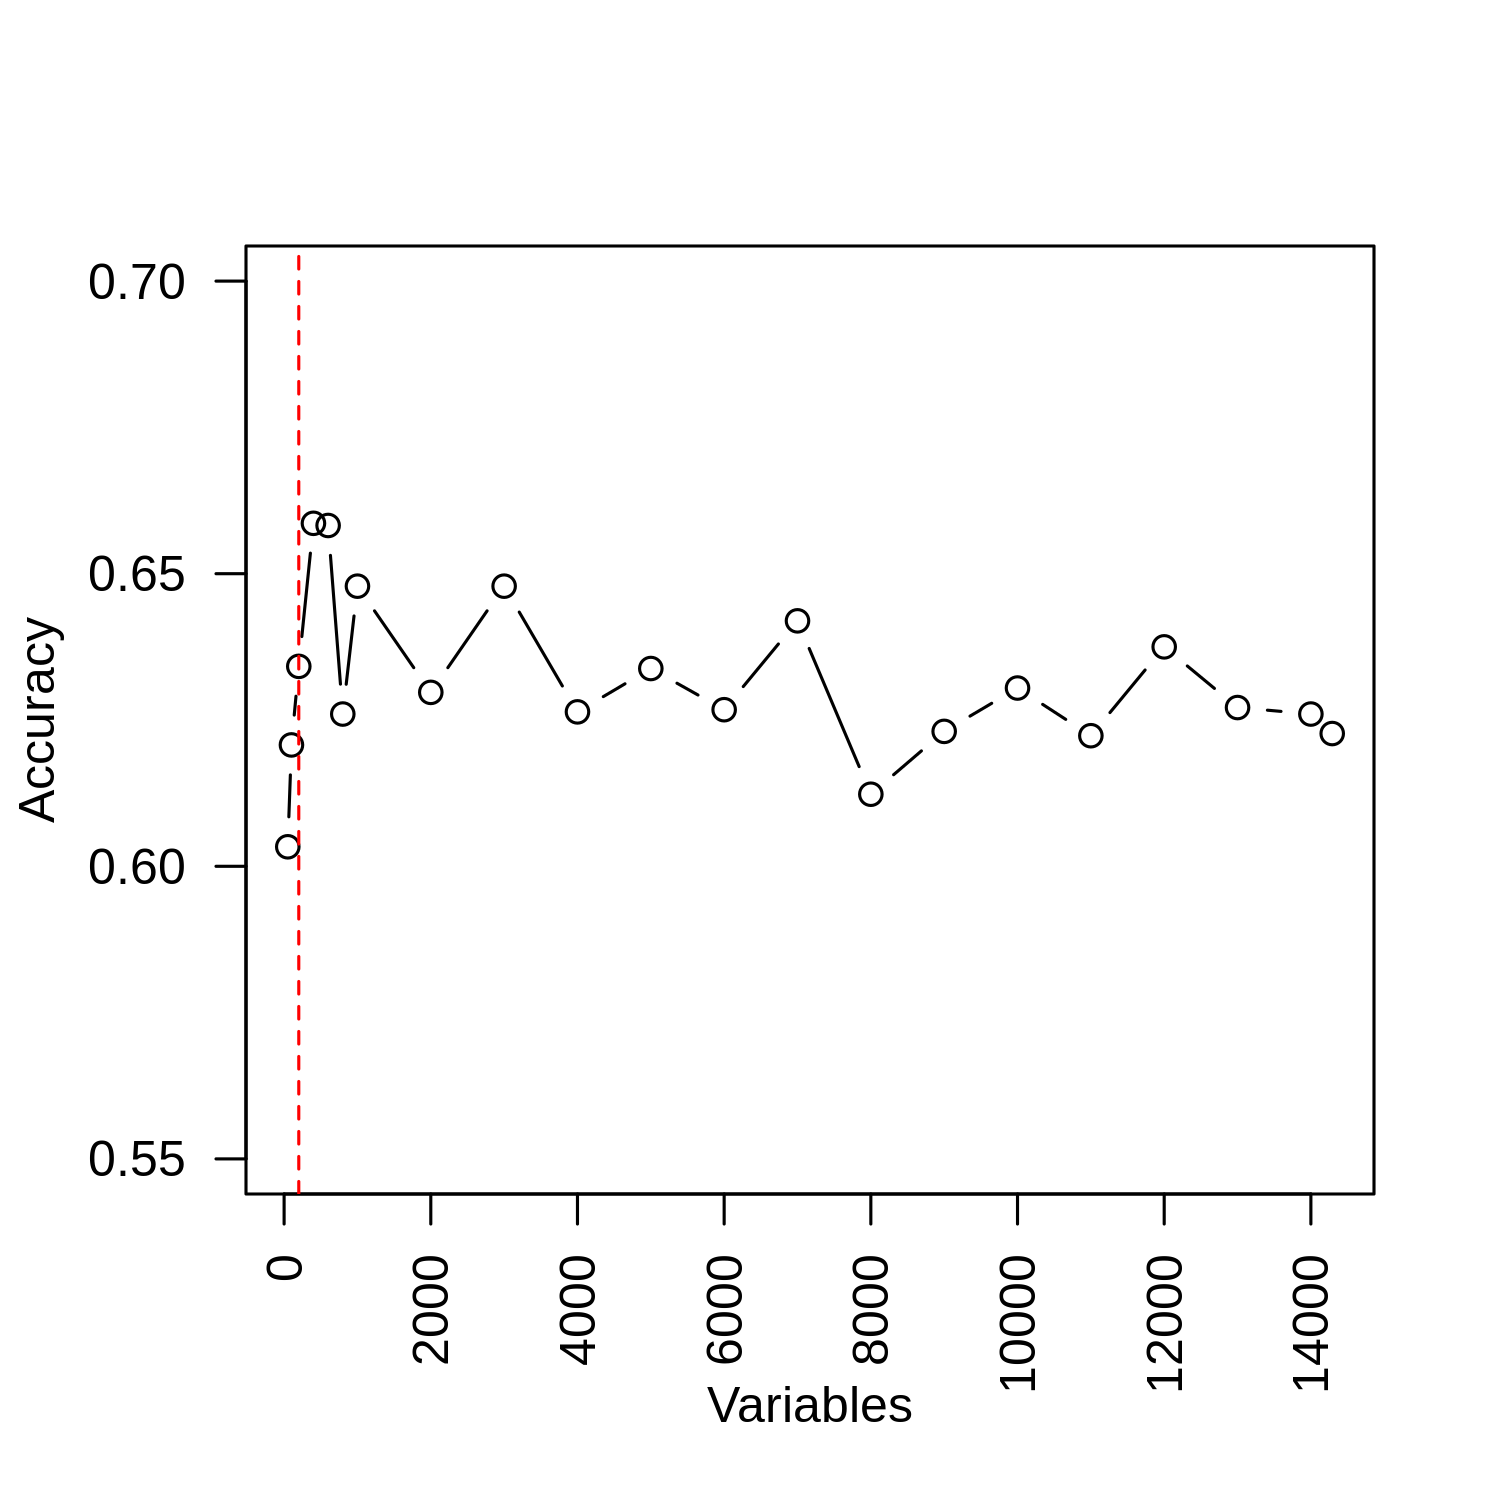

In [193]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 300)
# list the chosen featuresplot(a.rf, type=c("g", "o"))
rf.pred <- predictors(a.rf)
# plot the results
plot(a.rf$results$Variables, a.rf$results$Accuracy, ylab="Accuracy", xlab="Variables", 
     type="b", ylim =c(0.55, 0.7), las=2)
abline(v=200, lty="dashed", col="red")
a.rf.results <- a.rf$results

In [97]:
round(a.rf$results, 3)

Variables Accuracy Kappa AccuracySD KappaSD
1     50     0.603    0.167 0.149      0.315  
2    100     0.621    0.198 0.162      0.341  
3    200     0.634    0.225 0.153      0.316  
4    400     0.659    0.268 0.135      0.299  
5    600     0.658    0.269 0.136      0.293  
6    800     0.626    0.199 0.129      0.275  
7   1000     0.648    0.247 0.142      0.307  
8   2000     0.630    0.202 0.141      0.308  
9   3000     0.648    0.235 0.150      0.335  
10  4000     0.626    0.189 0.133      0.280  
11  5000     0.634    0.205 0.152      0.323  
12  6000     0.627    0.184 0.100      0.216  
13  7000     0.642    0.215 0.113      0.254  
14  8000     0.612    0.155 0.105      0.223  
15  9000     0.623    0.177 0.133      0.289  
16 10000     0.630    0.197 0.133      0.284  
17 11000     0.622    0.176 0.115      0.247  
18 12000     0.637    0.201 0.112      0.256  
19 13000     0.627    0.175 0.099      0.239  
20 14000     0.626    0.188 0.142      0.297  
21 14291     0.623    0.183 0.139      0.296

## Manual Feature Selection

In [56]:
# define a resampling approach for caret where data is divided into 10 random subsets and prediction is done on 
# 1 using the remaining 9. This approach is repeated thrice
control <- trainControl(method="repeatedcv", number=10, repeats=3)

### glmNet
A generalized linear model (GLM) is a flexible generalization of ordinary linear regression that allows for the response variable to have an error distribution other than the normal distribution. The GLM generalizes linear regression by allowing the linear model to be related to the response variable via a link function and by allowing the magnitude of the variance of each measurement to be a function of its predicted value.

In [57]:
m.glm <- train(Response~., data=mod_inp_mat, 
                  method="glmnet", 
                  trControl=control,
                  preProcess = c("scale", "center")
                 )


In [58]:
# estimate variable importance
glm.imp <- varImp(m.glm, scale=TRUE)$importance
rownames(glm.imp) <- gsub("`", "", rownames(glm.imp))
glm.imp$Name <- rownames(glm.imp)
# summarize importance
glm.imp <- glm.imp[order(glm.imp$Overall, decreasing=TRUE),]
colnames(glm.imp) <- c("Score", "Name")
head(glm.imp)

Score      Name  
5588   100.000000 5588  
6610    70.752079 6610  
64699   58.054084 64699 
79148   39.664221 79148 
11098    9.528336 11098 
283229   7.741099 283229

### SVM
Support vector machines (SVMs) is a representation of different classes in a hyperplane in multidimensional space. The hyperplane is generated in an iterative manner by SVM for error minimization and divide the datasets into classes to find a maximum marginal hyperplane (MMH).This is effective in high dimensional spaces.

In [59]:
m.svm <- train(Response~., data=mod_inp_mat, 
                  method="svmLinear2", 
                  trControl=control,
                  preProcess = c("scale", "center"))

In [60]:
# estimate variable importance
svm.imp <- varImp(m.svm, scale=TRUE)$importance
svm.imp$Name <- rownames(svm.imp)
# summarize importance
svm.imp <- svm.imp[order(svm.imp$N, decreasing=TRUE),]
svm.imp$N <- NULL
colnames(svm.imp) <- c("Score", "Name")
head(svm.imp)

Score     Name  
5588   100.00000 5588  
7539    88.17114 7539  
79148   86.91275 79148 
79722   86.07383 79722 
124535  84.31208 124535
6610    82.80201 6610

### PCA Neural Network

In [118]:
m.nnet <- train(Response~., data=mod_inp_mat, 
                  method="pcaNNet", 
                  trControl=control,
                  preProcess = c("scale", "center"))

# weights:  83
initial  value 40.985266 
iter  10 value 37.798441
iter  20 value 36.852440
iter  30 value 36.326911
iter  40 value 36.326351
final  value 36.326348 
converged
# weights:  245
initial  value 45.931106 
iter  10 value 35.764419
iter  20 value 28.821301
iter  30 value 27.572007
iter  40 value 25.541926
iter  50 value 25.539259
final  value 25.539250 
converged
# weights:  407
initial  value 45.631721 
iter  10 value 34.008390
iter  20 value 27.088675
iter  30 value 21.594079
iter  40 value 20.863022
iter  50 value 20.813257
iter  60 value 17.708473
iter  70 value 17.225148
iter  80 value 16.750898
iter  90 value 16.748909
iter  90 value 16.748909
iter  90 value 16.748909
final  value 16.748909 
converged
# weights:  83
initial  value 43.149566 
iter  10 value 38.086617
iter  20 value 33.421441
iter  30 value 28.585853
iter  40 value 23.019659
iter  50 value 20.515386
iter  60 value 17.773352
iter  70 value 16.347764
iter  80 value 14.151090
iter  90 value 13.642870
iter 10

initial  value 41.648069 
iter  10 value 37.830949
iter  20 value 33.311505
iter  30 value 32.679753
iter  40 value 32.344503
iter  50 value 32.342869
final  value 32.342858 
converged
# weights:  245
initial  value 42.607678 
iter  10 value 33.658150
iter  20 value 29.822744
iter  30 value 29.574600
iter  40 value 28.505281
final  value 28.505244 
converged
# weights:  407
initial  value 42.568985 
iter  10 value 34.157824
iter  20 value 24.190359
iter  30 value 19.647593
iter  40 value 18.826711
iter  50 value 18.811550
iter  60 value 18.505704
iter  70 value 18.452550
iter  80 value 18.452543
iter  90 value 17.599799
iter 100 value 17.457600
final  value 17.457600 
stopped after 100 iterations
# weights:  83
initial  value 41.662909 
iter  10 value 38.187243
iter  20 value 33.128053
iter  30 value 28.420378
iter  40 value 21.669407
iter  50 value 17.864987
iter  60 value 17.237153
iter  70 value 14.752296
iter  80 value 13.028845
iter  90 value 12.103946
iter 100 value 10.740567
fin

initial  value 42.911492 
iter  10 value 40.258398
iter  20 value 39.413803
iter  30 value 37.723831
iter  40 value 36.425431
iter  50 value 36.326348
iter  60 value 36.140314
iter  70 value 34.194247
iter  80 value 34.098837
iter  90 value 33.448920
iter 100 value 33.403265
final  value 33.403265 
stopped after 100 iterations
# weights:  245
initial  value 43.408982 
iter  10 value 39.658809
iter  20 value 38.109177
iter  30 value 36.341823
iter  40 value 34.440609
iter  50 value 31.759076
iter  60 value 31.567048
iter  60 value 31.567048
iter  60 value 31.567048
final  value 31.567048 
converged
# weights:  407
initial  value 43.218790 
iter  10 value 33.053912
iter  20 value 28.937305
iter  30 value 27.412505
iter  40 value 26.979289
iter  50 value 22.688696
iter  60 value 22.686095
iter  70 value 21.814642
iter  80 value 20.733456
iter  90 value 20.733448
iter 100 value 20.714971
final  value 20.714971 
stopped after 100 iterations
# weights:  83
initial  value 43.192280 
iter  10 

initial  value 43.983732 
iter  10 value 25.777067
iter  20 value 19.698494
iter  30 value 16.059736
iter  40 value 13.468199
iter  50 value 12.466225
iter  60 value 11.397612
iter  70 value 11.375256
iter  80 value 11.337797
iter  90 value 11.329733
iter 100 value 8.883290
final  value 8.883290 
stopped after 100 iterations
# weights:  84
initial  value 43.392661 
iter  10 value 39.673709
iter  20 value 38.357690
iter  30 value 37.863010
iter  40 value 36.001803
iter  50 value 30.418065
iter  60 value 30.153853
final  value 30.153843 
converged
# weights:  248
initial  value 48.782050 
iter  10 value 36.474205
iter  20 value 30.074771
iter  30 value 25.513242
iter  40 value 24.703159
iter  50 value 24.684135
iter  60 value 23.716115
iter  70 value 23.453458
iter  80 value 23.453449
final  value 23.453449 
converged
# weights:  412
initial  value 46.393993 
iter  10 value 34.001045
iter  20 value 26.335858
iter  30 value 20.245298
iter  40 value 19.049313
iter  50 value 17.306262
iter 

initial  value 44.537291 
iter  10 value 33.122125
iter  20 value 30.446298
iter  30 value 25.962082
iter  40 value 25.794555
iter  50 value 24.052343
iter  60 value 23.369715
iter  70 value 22.950309
iter  80 value 22.705149
iter  90 value 22.077836
iter 100 value 22.073448
final  value 22.073448 
stopped after 100 iterations
# weights:  84
initial  value 41.737968 
iter  10 value 34.456004
iter  20 value 30.709377
iter  30 value 29.290946
iter  40 value 29.290910
iter  40 value 29.290910
iter  40 value 29.290910
final  value 29.290910 
converged
# weights:  248
initial  value 46.254065 
iter  10 value 34.742065
iter  20 value 30.314286
iter  30 value 25.999753
iter  40 value 25.200782
iter  50 value 24.841779
iter  60 value 24.625374
iter  70 value 24.297114
iter  80 value 22.494650
iter  90 value 22.378006
final  value 22.377975 
converged
# weights:  412
initial  value 43.813327 
iter  10 value 34.167835
iter  20 value 26.754400
iter  30 value 20.452370
iter  40 value 19.446755
ite

initial  value 48.687662 
iter  10 value 30.853592
iter  20 value 22.624436
iter  30 value 22.195638
iter  40 value 22.191862
iter  50 value 19.302186
iter  60 value 17.511634
iter  70 value 17.373078
iter  80 value 15.755517
iter  90 value 15.714812
iter 100 value 15.687949
final  value 15.687949 
stopped after 100 iterations
# weights:  407
initial  value 43.329668 
iter  10 value 33.015851
iter  20 value 31.052270
iter  30 value 27.391893
iter  40 value 25.801504
iter  50 value 24.732272
iter  60 value 24.708315
iter  70 value 21.773298
iter  80 value 20.227724
iter  90 value 20.210852
iter 100 value 19.772385
final  value 19.772385 
stopped after 100 iterations
# weights:  83
initial  value 42.765353 
iter  10 value 40.281107
iter  20 value 40.199950
iter  30 value 39.850895
iter  40 value 39.850814
iter  40 value 39.850814
final  value 39.850814 
converged
# weights:  245
initial  value 41.207929 
iter  10 value 32.742013
iter  20 value 28.912177
iter  30 value 27.722821
iter  40 

initial  value 46.545226 
iter  10 value 30.957518
iter  20 value 27.432693
iter  30 value 24.634250
iter  40 value 23.651065
iter  50 value 20.877383
iter  60 value 19.722959
iter  70 value 19.702292
iter  80 value 18.006260
iter  90 value 16.874677
iter 100 value 16.774311
final  value 16.774311 
stopped after 100 iterations
# weights:  407
initial  value 41.644315 
iter  10 value 31.999114
iter  20 value 22.788322
iter  30 value 22.346149
iter  40 value 22.235065
iter  50 value 22.108949
iter  60 value 21.457519
iter  70 value 20.901850
iter  80 value 20.893417
iter  90 value 20.369031
iter 100 value 20.359910
final  value 20.359910 
stopped after 100 iterations
# weights:  83
initial  value 42.845076 
iter  10 value 38.343477
iter  20 value 36.640715
iter  30 value 36.464477
iter  40 value 34.845187
iter  50 value 34.844878
final  value 34.231579 
converged
# weights:  245
initial  value 48.240755 
iter  10 value 34.718979
iter  20 value 31.347314
iter  30 value 31.338726
iter  40 

initial  value 41.276433 
iter  10 value 26.974370
iter  20 value 20.894058
iter  30 value 17.615925
iter  40 value 17.524364
iter  50 value 17.521434
iter  60 value 16.193174
iter  70 value 15.385598
iter  80 value 13.019912
iter  90 value 11.482889
iter 100 value 9.851285
final  value 9.851285 
stopped after 100 iterations
# weights:  407
initial  value 48.967047 
iter  10 value 36.675284
iter  20 value 28.269847
iter  30 value 19.750895
iter  40 value 16.293345
iter  50 value 14.258389
iter  60 value 12.299651
iter  70 value 11.997328
iter  80 value 11.993156
iter  90 value 10.609224
iter 100 value 10.583118
final  value 10.583118 
stopped after 100 iterations
# weights:  82
initial  value 41.001652 
iter  10 value 37.397052
iter  20 value 36.176994
iter  30 value 36.174126
final  value 36.174123 
converged
# weights:  242
initial  value 41.078135 
iter  10 value 30.995004
iter  20 value 25.240857
iter  30 value 22.452454
iter  40 value 21.347244
iter  50 value 21.340351
iter  60 va

initial  value 43.777878 
iter  10 value 38.336367
iter  20 value 35.319947
iter  30 value 32.383479
iter  40 value 29.830647
iter  50 value 23.238587
iter  60 value 22.201003
iter  70 value 21.929485
iter  80 value 21.925779
iter  90 value 21.840541
iter 100 value 21.590896
final  value 21.590896 
stopped after 100 iterations
# weights:  407
initial  value 43.361631 
iter  10 value 28.794944
iter  20 value 26.181694
iter  30 value 21.822981
iter  40 value 19.315756
iter  50 value 17.364694
iter  60 value 15.878185
iter  70 value 15.692154
iter  80 value 15.691359
iter  90 value 10.919653
iter 100 value 5.724461
final  value 5.724461 
stopped after 100 iterations
# weights:  83
initial  value 43.938329 
iter  10 value 39.536083
iter  20 value 38.707772
iter  30 value 38.203334
iter  40 value 37.779419
iter  50 value 37.767885
final  value 37.767858 
converged
# weights:  245
initial  value 46.269412 
iter  10 value 38.644675
iter  20 value 35.135568
iter  30 value 29.800453
iter  40 va

initial  value 42.206767 
iter  10 value 37.790962
iter  20 value 34.264626
iter  30 value 31.522188
iter  40 value 31.022229
iter  50 value 30.375177
iter  60 value 30.318707
iter  70 value 30.209293
iter  80 value 29.855847
iter  90 value 29.278421
iter 100 value 28.422859
final  value 28.422859 
stopped after 100 iterations
# weights:  407
initial  value 44.403443 
iter  10 value 36.551358
iter  20 value 33.149285
iter  30 value 31.809200
iter  40 value 30.153706
iter  50 value 28.997953
iter  60 value 28.705348
iter  70 value 28.117191
iter  80 value 28.096404
iter  90 value 25.746784
iter 100 value 25.082097
final  value 25.082097 
stopped after 100 iterations
# weights:  84
initial  value 41.235590 
iter  10 value 39.632457
iter  20 value 36.915641
iter  30 value 30.539889
iter  40 value 25.324020
iter  50 value 24.015217
final  value 24.015206 
converged
# weights:  248
initial  value 43.432588 
iter  10 value 36.740165
iter  20 value 31.285408
iter  30 value 30.693859
iter  40 

initial  value 45.658647 
iter  10 value 37.519725
iter  20 value 34.087736
iter  30 value 27.982523
iter  40 value 25.763036
iter  50 value 23.783494
iter  60 value 22.727098
iter  70 value 22.650545
iter  80 value 22.649288
iter  90 value 22.547116
iter 100 value 21.576348
final  value 21.576348 
stopped after 100 iterations
# weights:  407
initial  value 50.009551 
iter  10 value 36.929004
iter  20 value 31.107266
iter  30 value 21.473135
iter  40 value 20.504521
iter  50 value 20.098713
iter  60 value 19.961943
iter  70 value 19.806110
iter  80 value 19.510032
iter  90 value 19.088321
iter 100 value 19.082284
final  value 19.082284 
stopped after 100 iterations
# weights:  452
initial  value 50.910838 
iter  10 value 38.353413
iter  20 value 28.557754
iter  30 value 26.898506
iter  40 value 25.758937
iter  50 value 25.051604
iter  60 value 25.031289
iter  70 value 23.219932
iter  80 value 21.947503
iter  90 value 21.940707
iter 100 value 19.777115
final  value 19.777115 
stopped af

In [123]:
# estimate variable importance
nnet.imp <- varImp(m.nnet, scale=TRUE)$importance
rownames(nnet.imp) <- gsub("`", "", rownames(nnet.imp))
nnet.imp$Name <- rownames(nnet.imp)
# summarize importance
nnet.imp <- nnet.imp[order(nnet.imp$N, decreasing=TRUE),]
nnet.imp$N <- NULL
colnames(nnet.imp) <- c("Score", "Name")
head(nnet.imp)

Score     Name  
5588   100.00000 5588  
7539    88.17114 7539  
79148   86.91275 79148 
79722   86.07383 79722 
124535  84.31208 124535
6610    82.80201 6610

### Gradient Boosting Machines (GBM)

In [62]:
library(gbm)
m.gbm <- train(Response~., data=mod_inp_mat, 
                  method="gbm", 
                  trControl=control,
                  preProcess = c("scale", "center"))

Loaded gbm 2.1.8



Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3067            -nan     0.1000    0.0029
     2        1.2616            -nan     0.1000   -0.0024
     3        1.2074            -nan     0.1000    0.0096
     4        1.1687            -nan     0.1000   -0.0052
     5        1.1264            -nan     0.1000    0.0019
     6        1.0794            -nan     0.1000    0.0108
     7        1.0475            -nan     0.1000   -0.0013
     8        1.0216            -nan     0.1000   -0.0010
     9        0.9874            -nan     0.1000    0.0016
    10        0.9626            -nan     0.1000   -0.0039
    20        0.7328            -nan     0.1000    0.0001
    40        0.4242            -nan     0.1000    0.0014
    60        0.2602            -nan     0.1000   -0.0018
    80        0.1670            -nan     0.1000    0.0005
   100        0.1091            -nan     0.1000   -0.0015
   120        0.0700            -nan     0.1000   -0.0009
   140        

In [63]:
# estimate variable importance
gbm.imp <- varImp(m.gbm, scale=TRUE)$importance
rownames(gbm.imp) <- gsub("`", "", rownames(gbm.imp))
gbm.imp$Name <- rownames(gbm.imp)
# summarize importance
gbm.imp <- gbm.imp[order(gbm.imp$Overall, decreasing=TRUE),]
colnames(gbm.imp) <- c("Score", "Name")
head(gbm.imp)

Score     Name 
3775  100.00000 3775 
56940  75.46734 56940
9699   73.92865 9699 
79613  72.32096 79613
9853   72.14361 9853 
10422  70.95574 10422

### Partial Least Squares

In [64]:
m.pls <- train(Response~., data=mod_inp_mat, 
                  method="pls", 
                  trControl=control,
                  preProcess = c("scale", "center"))

In [65]:
# estimate variable importance
pls.imp <- varImp(m.pls, scale=TRUE)$importance
rownames(pls.imp) <- gsub("`", "", rownames(pls.imp))
pls.imp$Name <- rownames(pls.imp)
# summarize importance
pls.imp <- pls.imp[order(pls.imp$Overall, decreasing=TRUE),]
colnames(pls.imp) <- c("Score", "Name")
head(pls.imp)


Attaching package: ‘pls’


The following object is masked from ‘package:corrplot’:

    corrplot


The following object is masked from ‘package:caret’:

    R2


The following object is masked from ‘package:stats’:

    loadings




Score     Name 
64699 100.00000 64699
5588   96.35218 5588 
6610   89.22372 6610 
6539   80.83636 6539 
3205   79.30273 3205 
79148  78.47614 79148

### Cforest

In [67]:
m.cforest <- train(Response~., data=mod_inp_mat, 
                  method="cforest", 
                  trControl=control,
                  preProcess = c("scale", "center"))

In [68]:
# estimate variable importance
cforest.imp <- varImp(m.cforest, scale=TRUE)$importance
rownames(cforest.imp) <- gsub("`", "", rownames(cforest.imp))
cforest.imp$Name <- rownames(cforest.imp)
# summarize importance
cforest.imp <- cforest.imp[order(cforest.imp$Overall, decreasing=TRUE),]
colnames(cforest.imp) <- c("Score", "Name")
head(cforest.imp)

Score     Name 
5588  100.00000 5588 
64699  42.44805 64699
6610   41.45043 6610 
7539   17.43842 7539 
3205   16.23866 3205 
23314  12.85015 23314

### Roc based classifier

In [177]:
date()
m.rocc <- train(Response~., data=mod_inp_mat, 
                  method="rocc", 
                  trControl=control,
                  preProcess = c("scale", "center"))
date()

[1] "Tue Jul 27 07:54:57 2021"

[1] "Tue Jul 27 07:59:05 2021"

In [180]:
rocc.imp <- varImp(m.rocc, scale=TRUE)$importance
rownames(rocc.imp) <- gsub("`", "", rownames(rocc.imp))
rocc.imp$Name <- rownames(rocc.imp)
# summarize importance
rocc.imp <- rocc.imp[order(rocc.imp$N, decreasing=TRUE),]
rocc.imp$N <- NULL
colnames(rocc.imp) <- c("Score", "Name")
head(rocc.imp)

Score     Name  
5588   100.00000 5588  
7539    88.17114 7539  
79148   86.91275 79148 
79722   86.07383 79722 
124535  84.31208 124535
6610    82.80201 6610

### Naive Bayes

In [128]:
m.nb <- train(Response~., data=mod_inp_mat, 
                  method="naive_bayes", 
                  trControl=control,
                  preProcess = c("scale", "center"))

In [129]:
# estimate variable importance
nb.imp <- varImp(m.nb, scale=TRUE)$importance
rownames(nb.imp) <- gsub("`", "", rownames(nb.imp))
nb.imp$Name <- rownames(nb.imp)
# summarize importance
nb.imp <- nb.imp[order(nb.imp$N, decreasing=TRUE),]
nb.imp$N <- NULL
colnames(nb.imp) <- c("Score", "Name")
head(nb.imp)

Score     Name  
5588   100.00000 5588  
7539    88.17114 7539  
79148   86.91275 79148 
79722   86.07383 79722 
124535  84.31208 124535
6610    82.80201 6610

## Rank Analysis

### Compare ranks from multiple Models

In [181]:
# getRank adds a rank column to the input matrix according to varImp scores
getRank <- function(tmp=NULL, cname=NULL){
    tmp[,cname] <- rank(-tmp$Score)
    tmp$Score <- NULL
    tmp
}

glm.rank <- getRank(glm.imp, "glm.Rank")
svm.rank <- getRank(svm.imp, "svm.Rank")
nnet.rank <- getRank(nnet.imp, "nnet.Rank")
gbm.rank <- getRank(gbm.imp, "gbm.Rank")
pls.rank <- getRank(pls.imp, "pls.Rank")
cforest.rank <- getRank(cforest.imp, "cforest.Rank")
rocc.rank <- getRank(rocc.imp, "rocc.Rank")
nb.rank <- getRank(nb.imp, "nb.Rank")

all.rank <- Reduce(function(x,y) merge(x,y, by="Name"),list(glm.rank, svm.rank, nnet.rank, gbm.rank,
                                                             pls.rank, cforest.rank, rocc.rank, nb.rank))
                   
colnames(all.rank)[1] <- "Gene_ID" 
all.rank$Gene_Name <- getSymbols(all.rank$Gene_ID, 'org.Hs.eg.db')
# all.rank is the merged matrix containing gene IDs as the first column, gene names as the last column and 
# ranks for all the models as intermediate columns                  

[1] "Warning: some genes do not have valid symbols!"


In [182]:
# to find all genes over the threshold
rank.threshold <- 250
rank.clmn <- grep("Rank", colnames(all.rank))
all.rank$Threshold.250 <- apply(all.rank[, rank.clmn], 1, function(x){sum(x<rank.threshold)})
all.rank <- all.rank[order(all.rank$Threshold.250, decreasing=TRUE),]

rank.threshold <- 200
rank.clmn <- grep("Rank", colnames(all.rank))
all.rank$Threshold.200 <- apply(all.rank[, rank.clmn], 1, function(x){sum(x<rank.threshold)})
all.rank <- all.rank[order(all.rank$Threshold.200, decreasing=TRUE),]

rank.threshold <- 150
rank.clmn <- grep("Rank", colnames(all.rank))
all.rank$Threshold.150 <- apply(all.rank[, rank.clmn], 1, function(x){sum(x<rank.threshold)})
all.rank <- all.rank[order(all.rank$Threshold.150, decreasing=TRUE),]

rank.threshold <- 100
rank.clmn <- grep("Rank", colnames(all.rank))
all.rank$Threshold.100 <- apply(all.rank[, rank.clmn], 1, function(x){sum(x<rank.threshold)})
all.rank <- all.rank[order(all.rank$Threshold.100, decreasing=TRUE),]

rank.threshold <- 50
rank.clmn <- grep("Rank", colnames(all.rank))
all.rank$Threshold.50 <- apply(all.rank[, rank.clmn], 1, function(x){sum(x<rank.threshold)})
all.rank <- all.rank[order(all.rank$Threshold.50, decreasing=TRUE),]

rank.threshold <- 30
rank.clmn <- grep("Rank", colnames(all.rank))
all.rank$Threshold.30 <- apply(all.rank[, rank.clmn], 1, function(x){sum(x<rank.threshold)})
all.rank <- all.rank[order(all.rank$Threshold.30, decreasing=TRUE),]

rank.threshold <- 10
rank.clmn <- grep("Rank", colnames(all.rank))
all.rank$Threshold.10 <- apply(all.rank[, rank.clmn], 1, function(x){sum(x<rank.threshold)})
all.rank <- all.rank[order(all.rank$Threshold.10, decreasing=TRUE),]

In [190]:
ml.list <- all.rank[all.rank$Threshold.200 >=4, ]$Gene_ID
# save the list of genes which fall within Top 200 rank in at least 4 out of 8 models tested
saveRDS(ml.list, "/home/jp/ICP_Responders/ML/AntiPD1/Pre-processingFeatureSelection/ml.list.rds")

### Merge ranks using Borda voting method
NOT used since the results are very similar to manual ranking method

In [ ]:
# #merge rank using Borda method
# library(votesys)
# data <- all.rank[,2:9]
# transpose <- t(data)
# tmp <- as.matrix(transpose)
# colnames(tmp) <- all.rank$Gene_Name
# # tmp
# vote <- create_vote(tmp, xtype=1)
# res.borda <- borda_method(vote, modified = FALSE)  # Winner is with the lowest score, for modified is FALSE.
# merged.rank<-data.frame(gene=names(res.borda$other_info$count_min),
#                         rank.borda=res.borda$other_info$count_min,
#                         stringsAsFactors=F)

# merged.rank <- merged.rank[order(merged.rank$rank.borda, decreasing=FALSE),]
# head(merged.rank)

# AUC-ROC analysis

In [154]:
# Find literature curated genes in raw input data
genes_lit_rawdata <- genes_lit_sur$ID[which(genes_lit_sur$ID %in% colnames(GideHugoRiaz_AntiPD1))] 
top_genes_out <- all.rank$Gene_ID[which(genes_lit_rawdata %in% 
                                        all.rank[all.rank$Threshold.200 >= 4, "Gene_ID"])]
ctrl <- trainControl(method="repeatedcv", number=10, repeats=3, 
                     summaryFunction=twoClassSummary, classProbs=T,savePredictions = T)

In [162]:
head(mod_inp_mat)

Response 1           503538     2          144571       53947     
2 N         0.44967917 -0.1256063 -0.9428421 -0.613896552 -0.8007014
3 N        -1.16982847 -0.6828899 -0.8272336 -0.446609752  1.2678120
4 N        -0.04601746  1.5028679 -0.8496055 -0.702546587  1.4189363
5 N         0.67577556 -0.4820313 -1.6330965  0.490900241 -0.7919329
6 N        -0.11535008 -0.1847109 -0.4553360  0.118023126 -0.4543087
7 N        -0.14481244  1.3029584 -1.1511116 -0.005086172  1.1339221
  8086        65985     51166      195827     ⋯ 9183        55055     
2 -0.20012314 0.6050572 -1.0709579  0.4810461 ⋯  0.64198887  0.5871449
3 -0.15970481 2.3022740 -0.7844277 -0.5708133 ⋯  0.07255123 -0.7785700
4  0.74020824 0.6934887  0.5757124 -0.8746147 ⋯  0.06265680 -1.5188989
5 -0.07076524 0.6020135  0.5151392  0.2313109 ⋯ -0.39436320 -0.4336941
6  0.24283611 0.1082517 -0.7758829 -0.9898691 ⋯  0.02280537  0.3361414
7  0.76875725 0.9108753  0.2564553 -0.8573685 ⋯  0.22826311 -0.5252797
  7789          158586     79364       440590      79699       7791      
2  0.2051403085  0.2497006  0.50803986  0.70851142  0.45721398 -0.7961158
3  0.0005757279 -0.4148035  0.05113678  0.09727642 -0.16385787 -0.2469282
4  0.1098136507 -0.4097749 -0.18345745  0.16842307 -0.19196153  0.6580495
5 -0.2777108820 -0.1297598 -0.06003260 -0.12662805 -0.13856663 -1.2178791
6 -0.3655941746 -0.7592193  0.41185003 -0.11559656 -0.05134074 -0.2665028
7  0.9012394246  0.1606743  0.67071102 -0.18993268 -0.11826441 -1.1862133
  23140       26009      
2  0.24296059  1.18213316
3  0.11710389 -0.74993078
4  0.97848818 -0.27105096
5 -0.20991515  0.08612588
6 -0.30519406 -0.84401986
7  0.02628124  0.27000323

## glmNet

In [224]:
start_time <- Sys.time()
start_time

[1] "2021-07-27 23:02:42 CEST"

***MLeval: Machine Learning Model Evaluation***

Input: caret train function object

Averaging probs.

Group 1 type: repeatedcv

Group 2 type: repeatedcv

Group 3 type: repeatedcv

Group 4 type: repeatedcv

Group 5 type: repeatedcv

Observations: 460

Number of groups: 5

Observations per group: 92

Positive: Y

Negative: N

Group: glm_all

Positive: 39

Negative: 53

Group: glm_top150

Positive: 39

Negative: 53

Group: glm_top30

Positive: 39

Negative: 53

Group: glm_litsurvey

Positive: 39

Negative: 53

Group: glm_top150-litsurvey

Positive: 39

Negative: 53

***Performance Metrics***



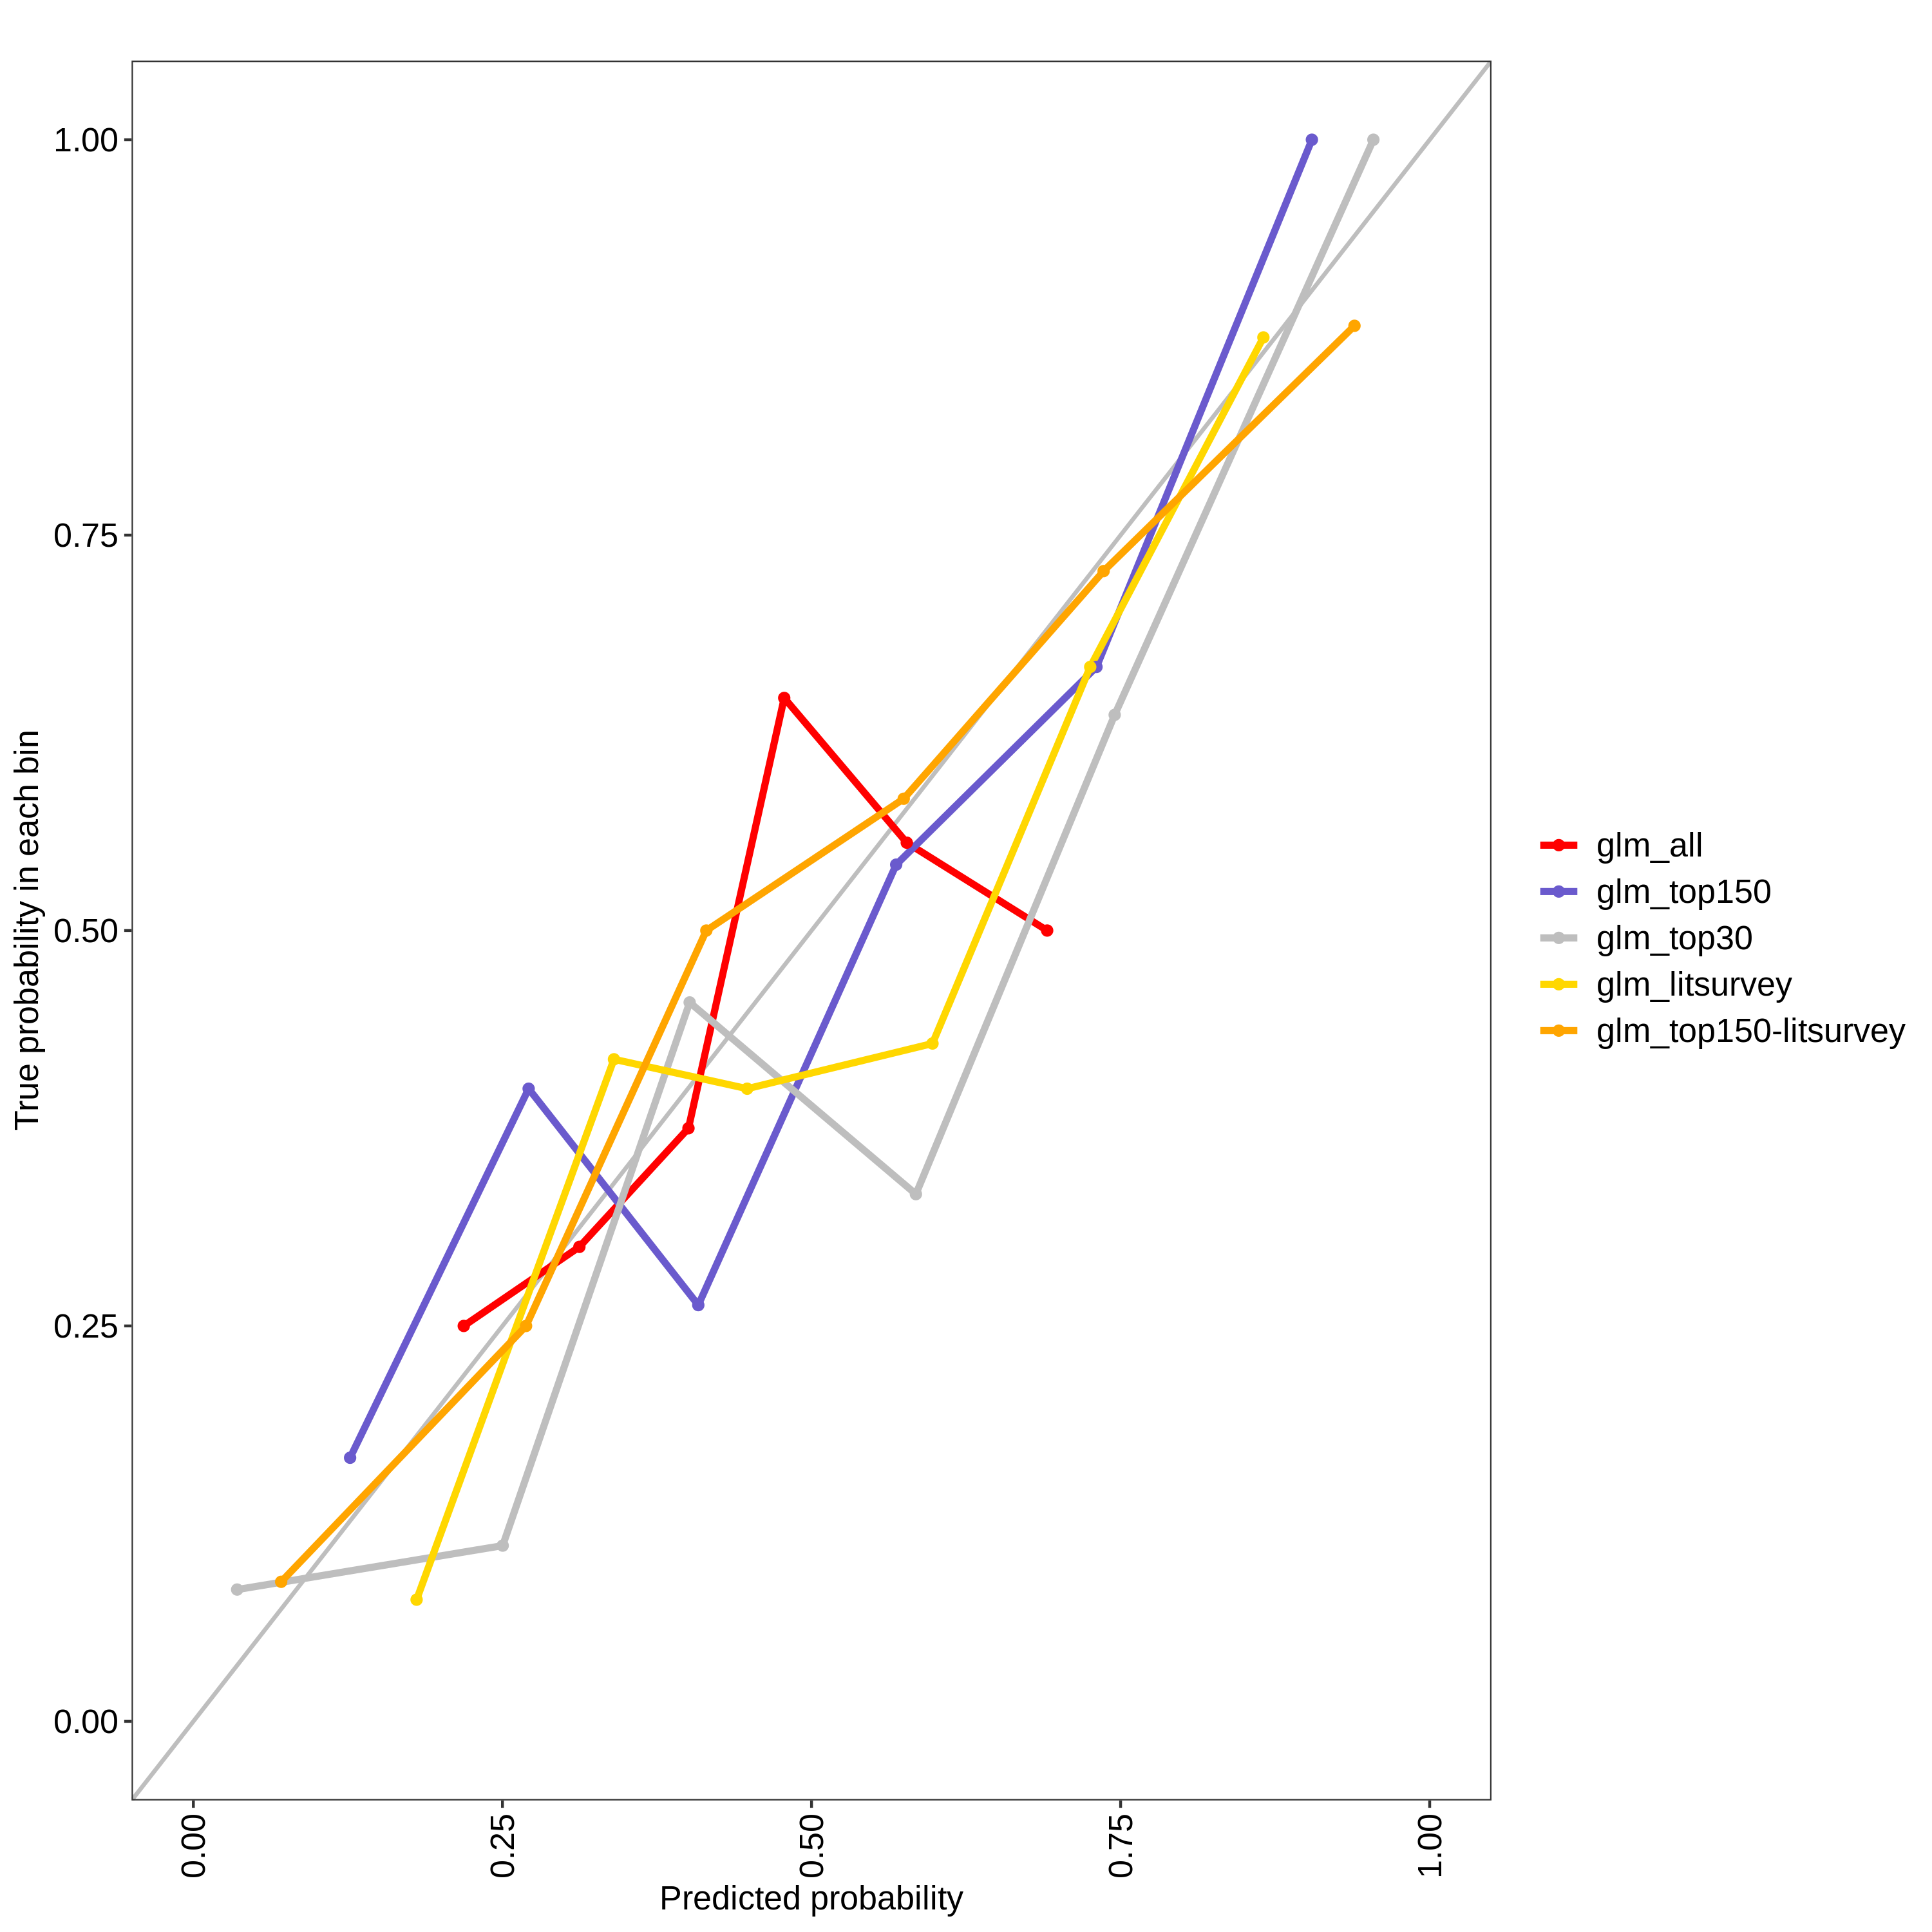

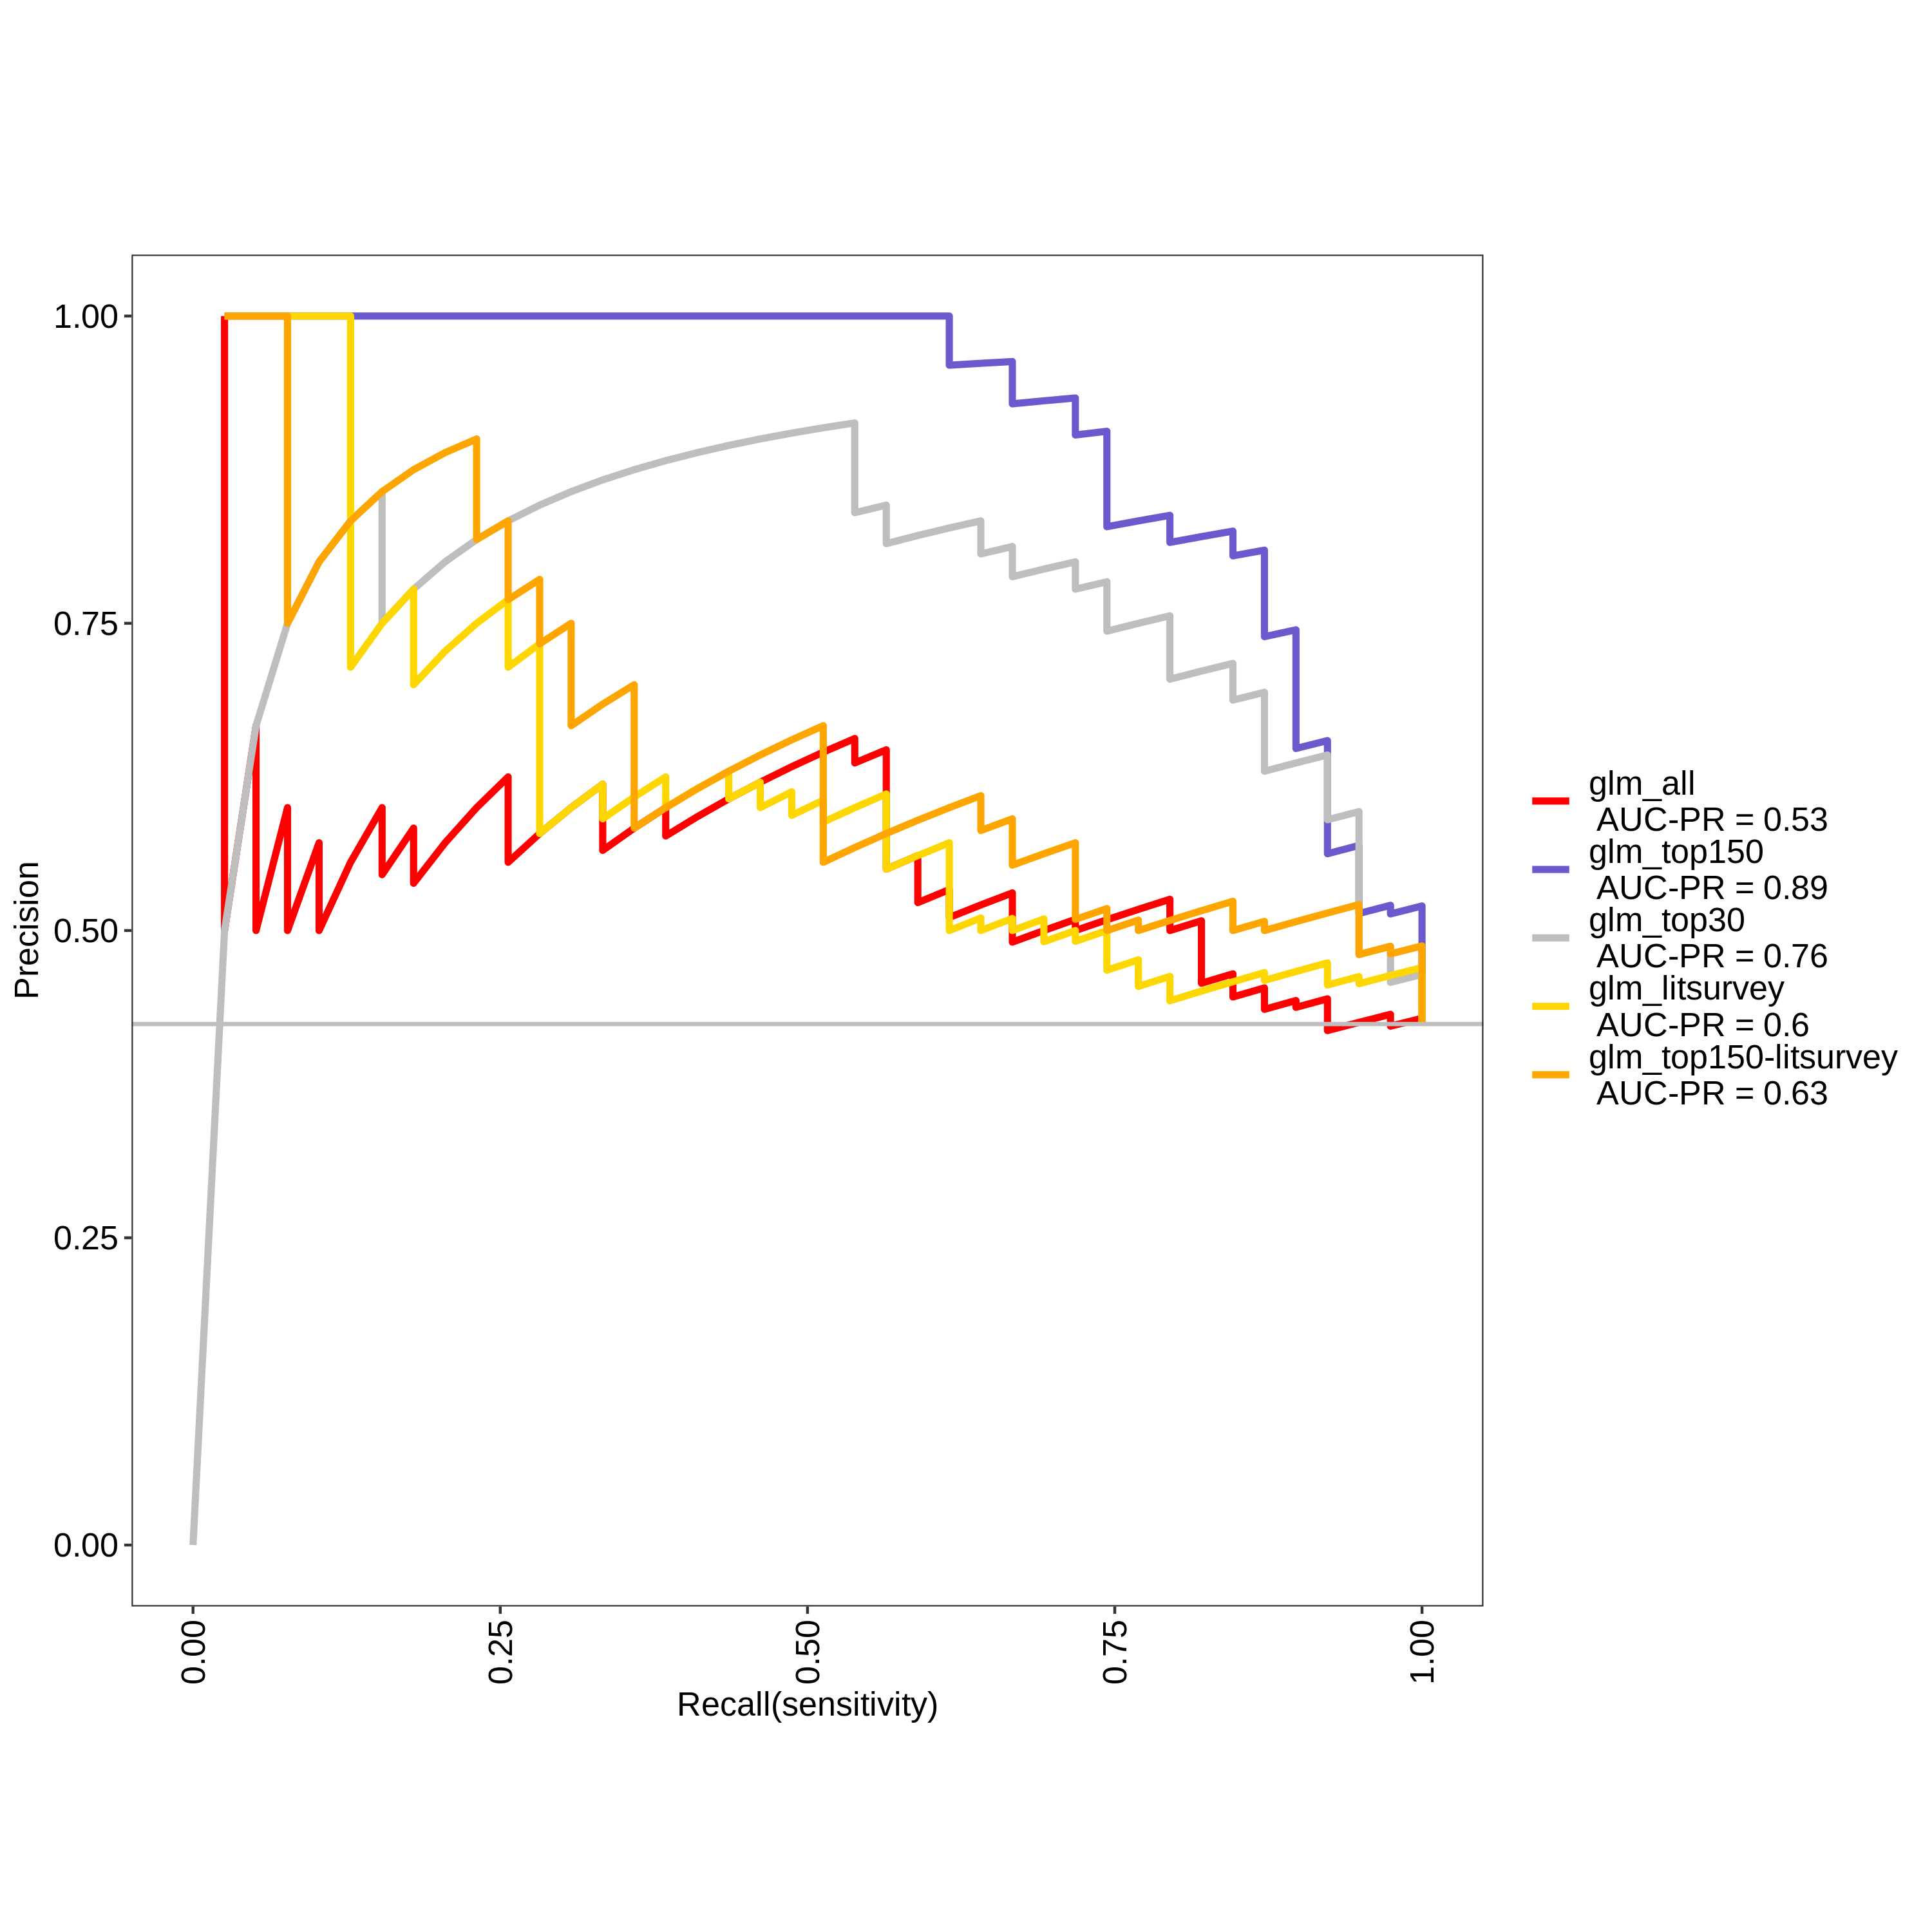

glm_all Optimal Informedness = 0.337687469762942

glm_top150 Optimal Informedness = 0.720851475568457

glm_top30 Optimal Informedness = 0.606192549588776

glm_litsurvey Optimal Informedness = 0.299951620706338

glm_top150-litsurvey Optimal Informedness = 0.339138848572811

glm_all AUC-ROC = 0.65

glm_top150 AUC-ROC = 0.92

glm_top30 AUC-ROC = 0.86

glm_litsurvey AUC-ROC = 0.66

glm_top150-litsurvey AUC-ROC = 0.72



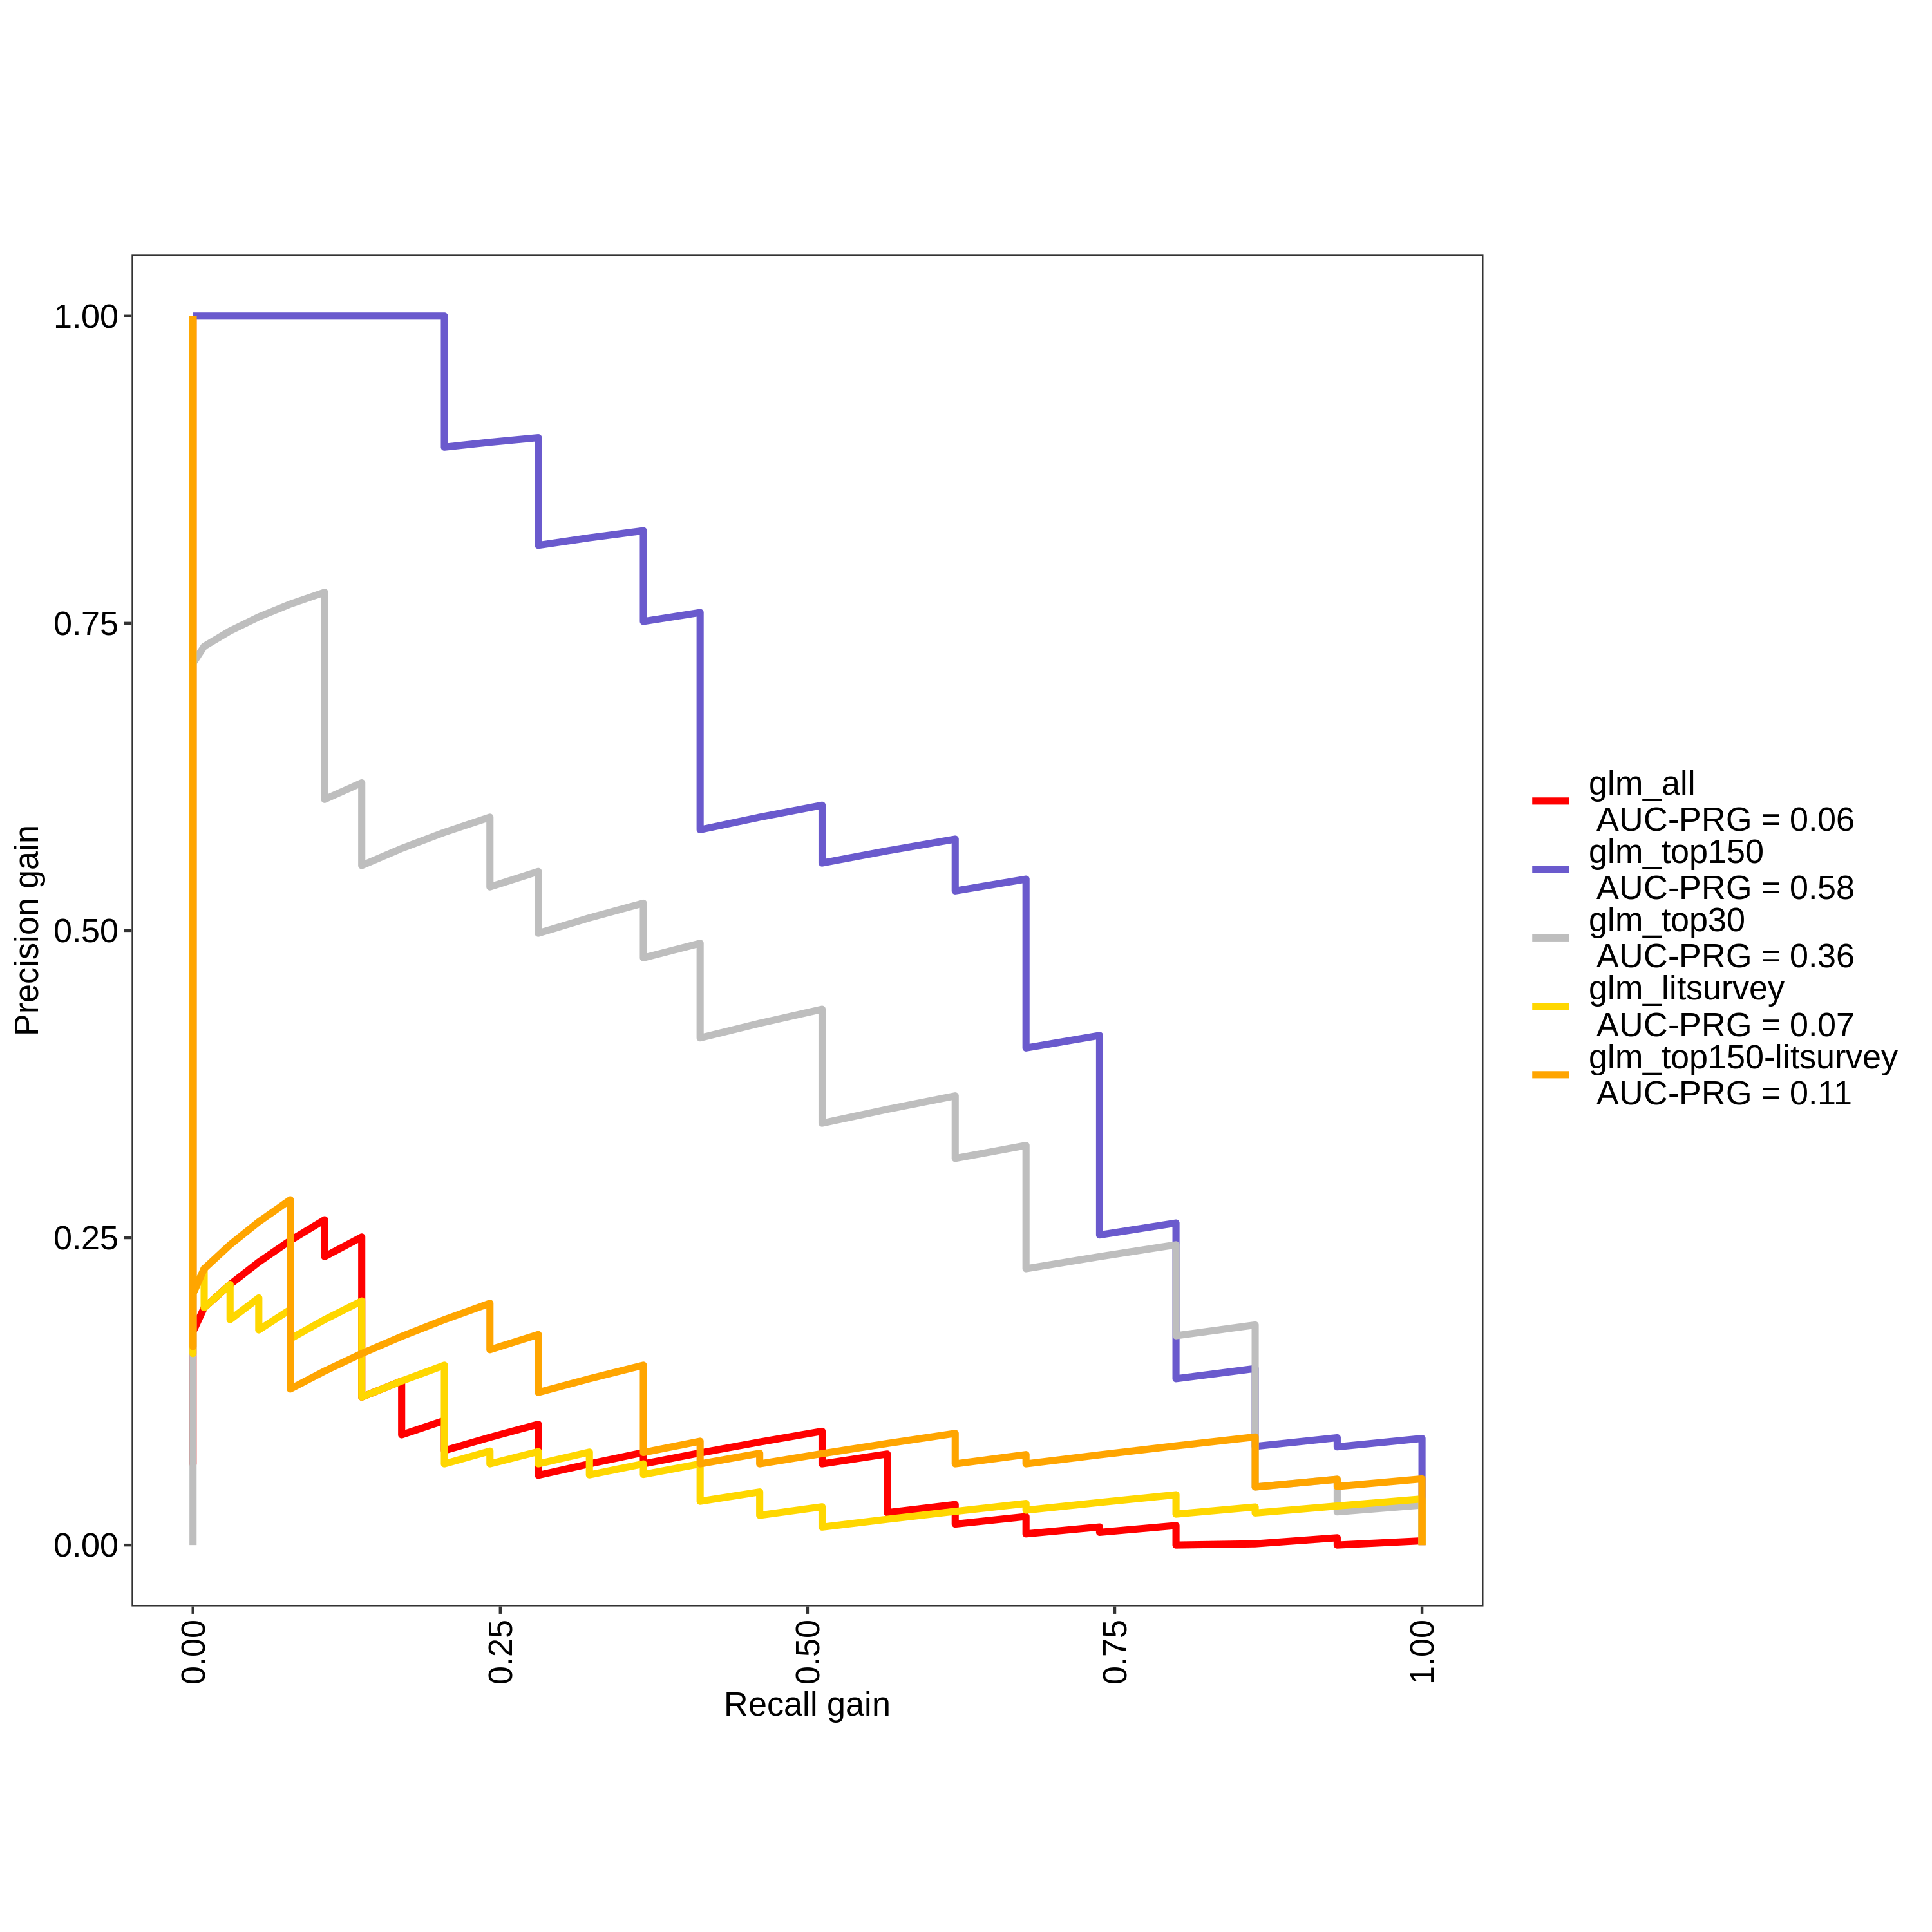

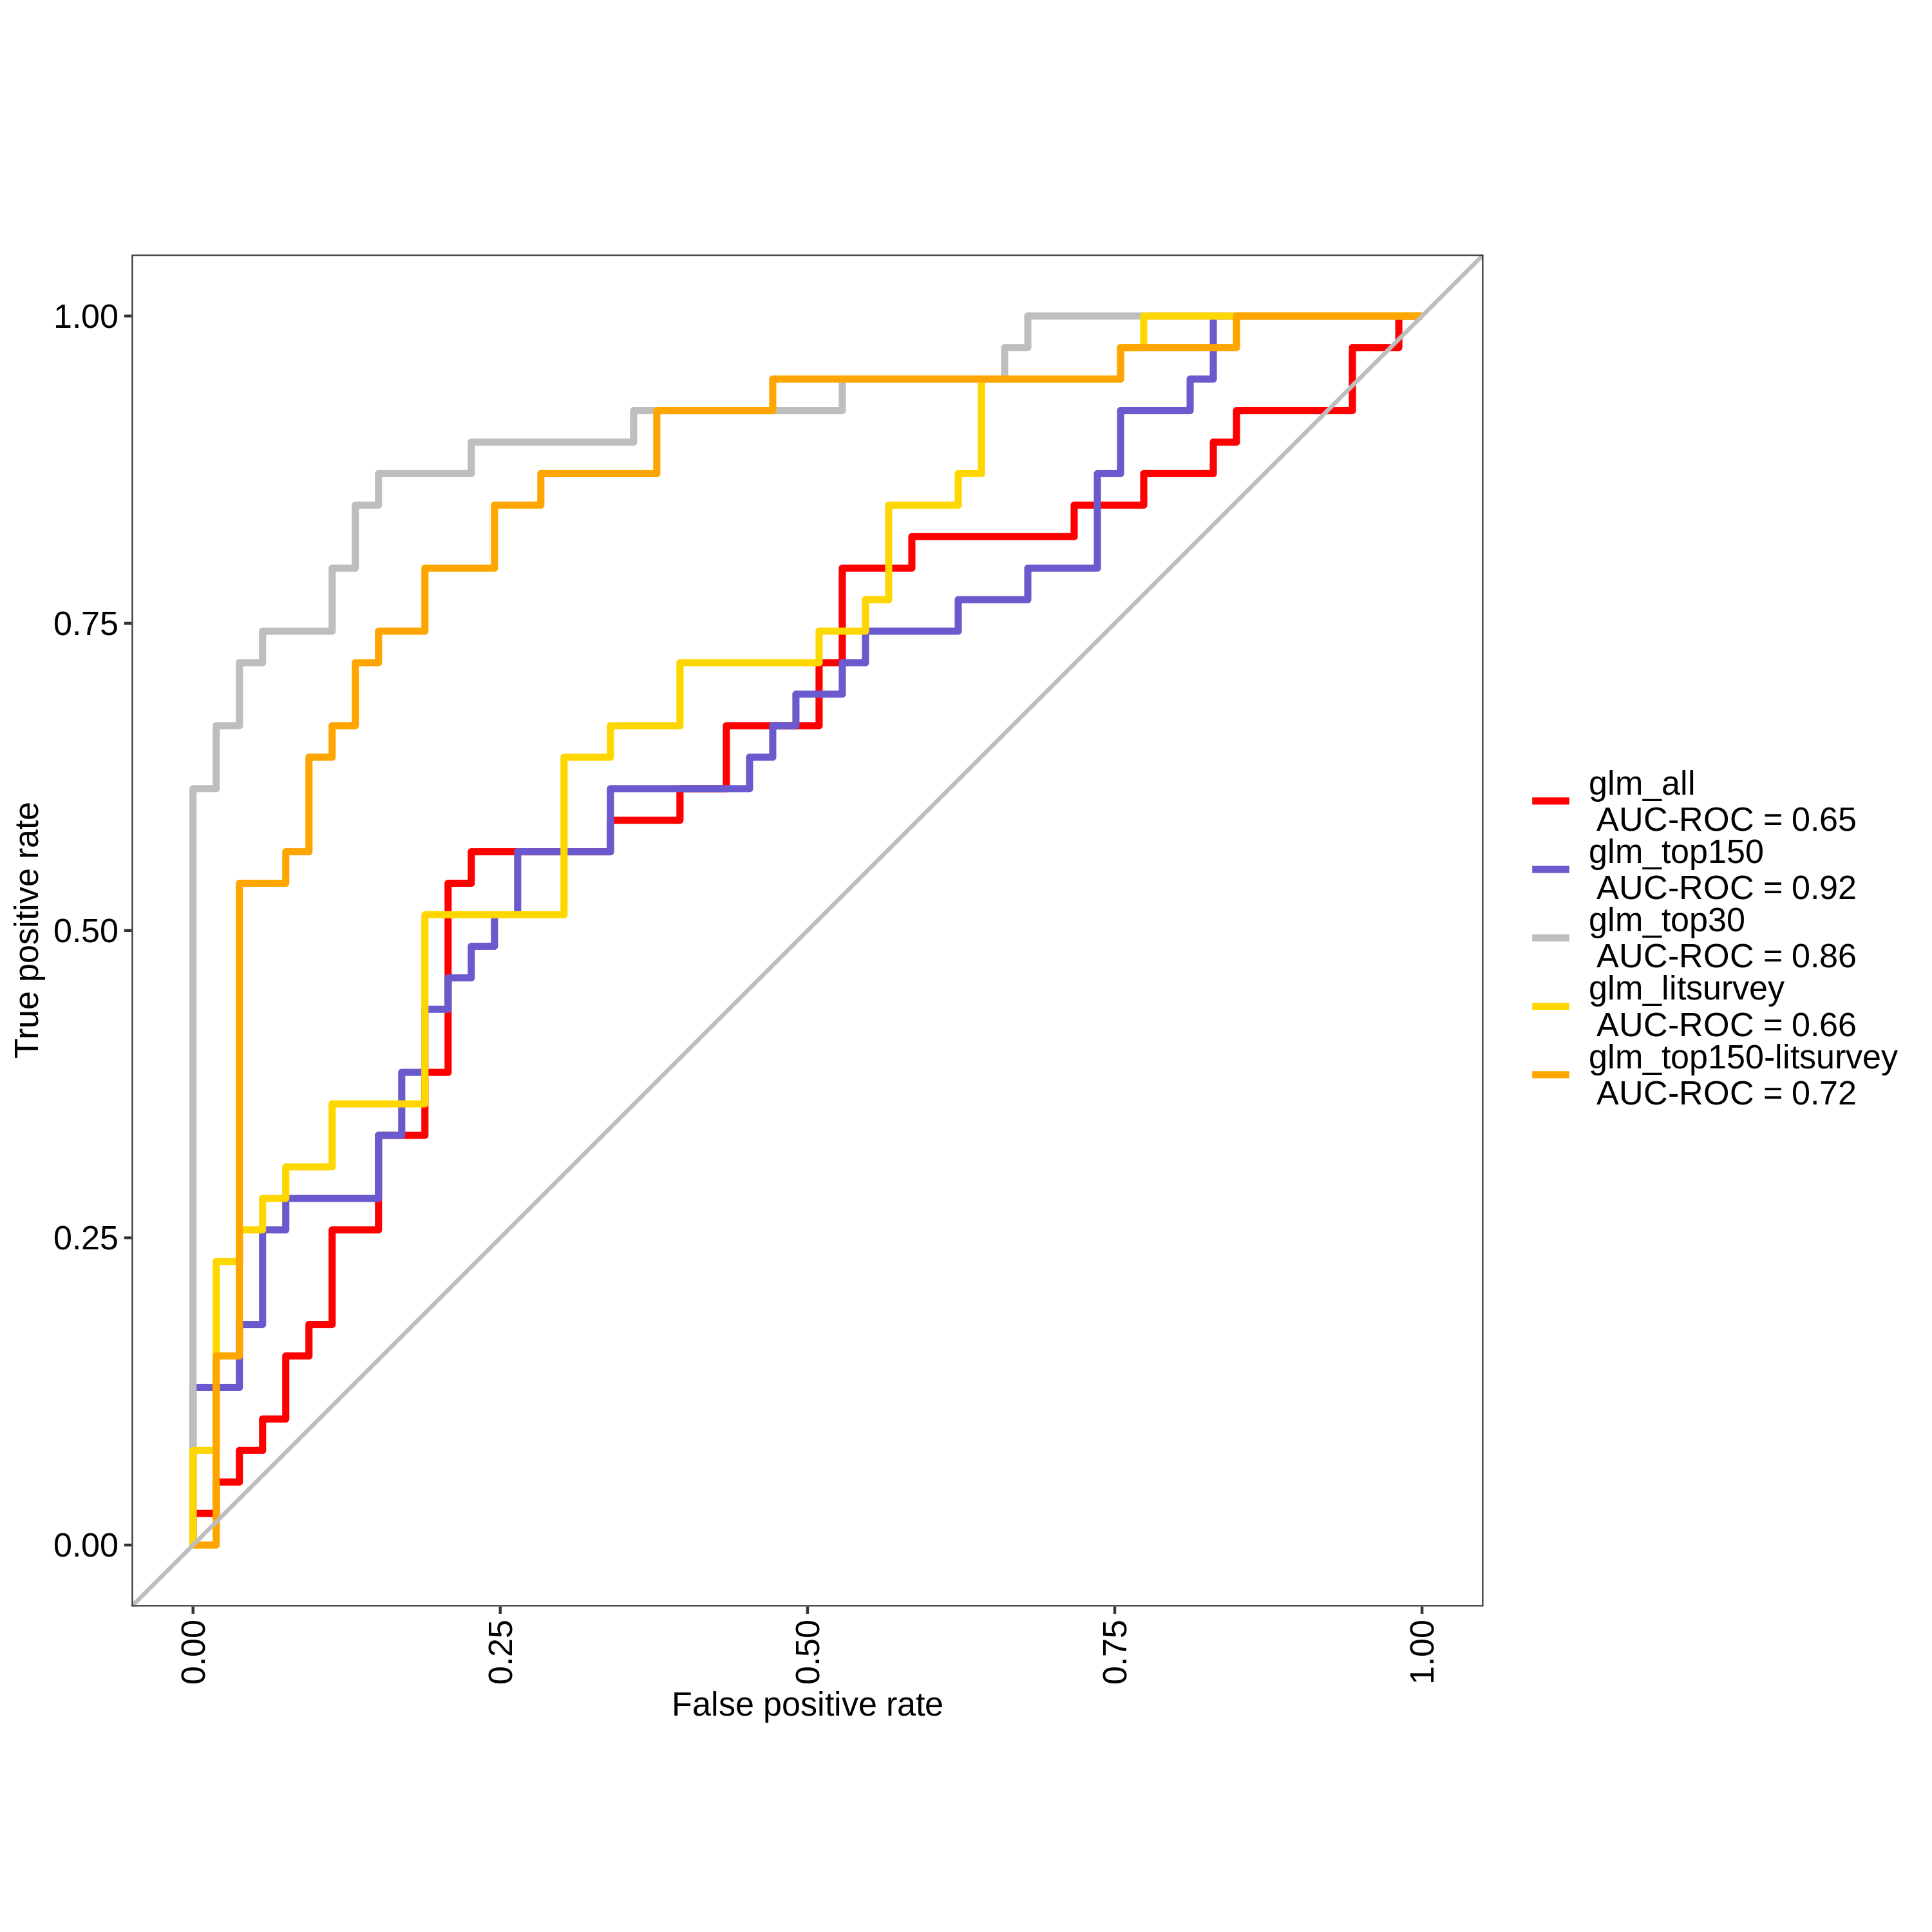

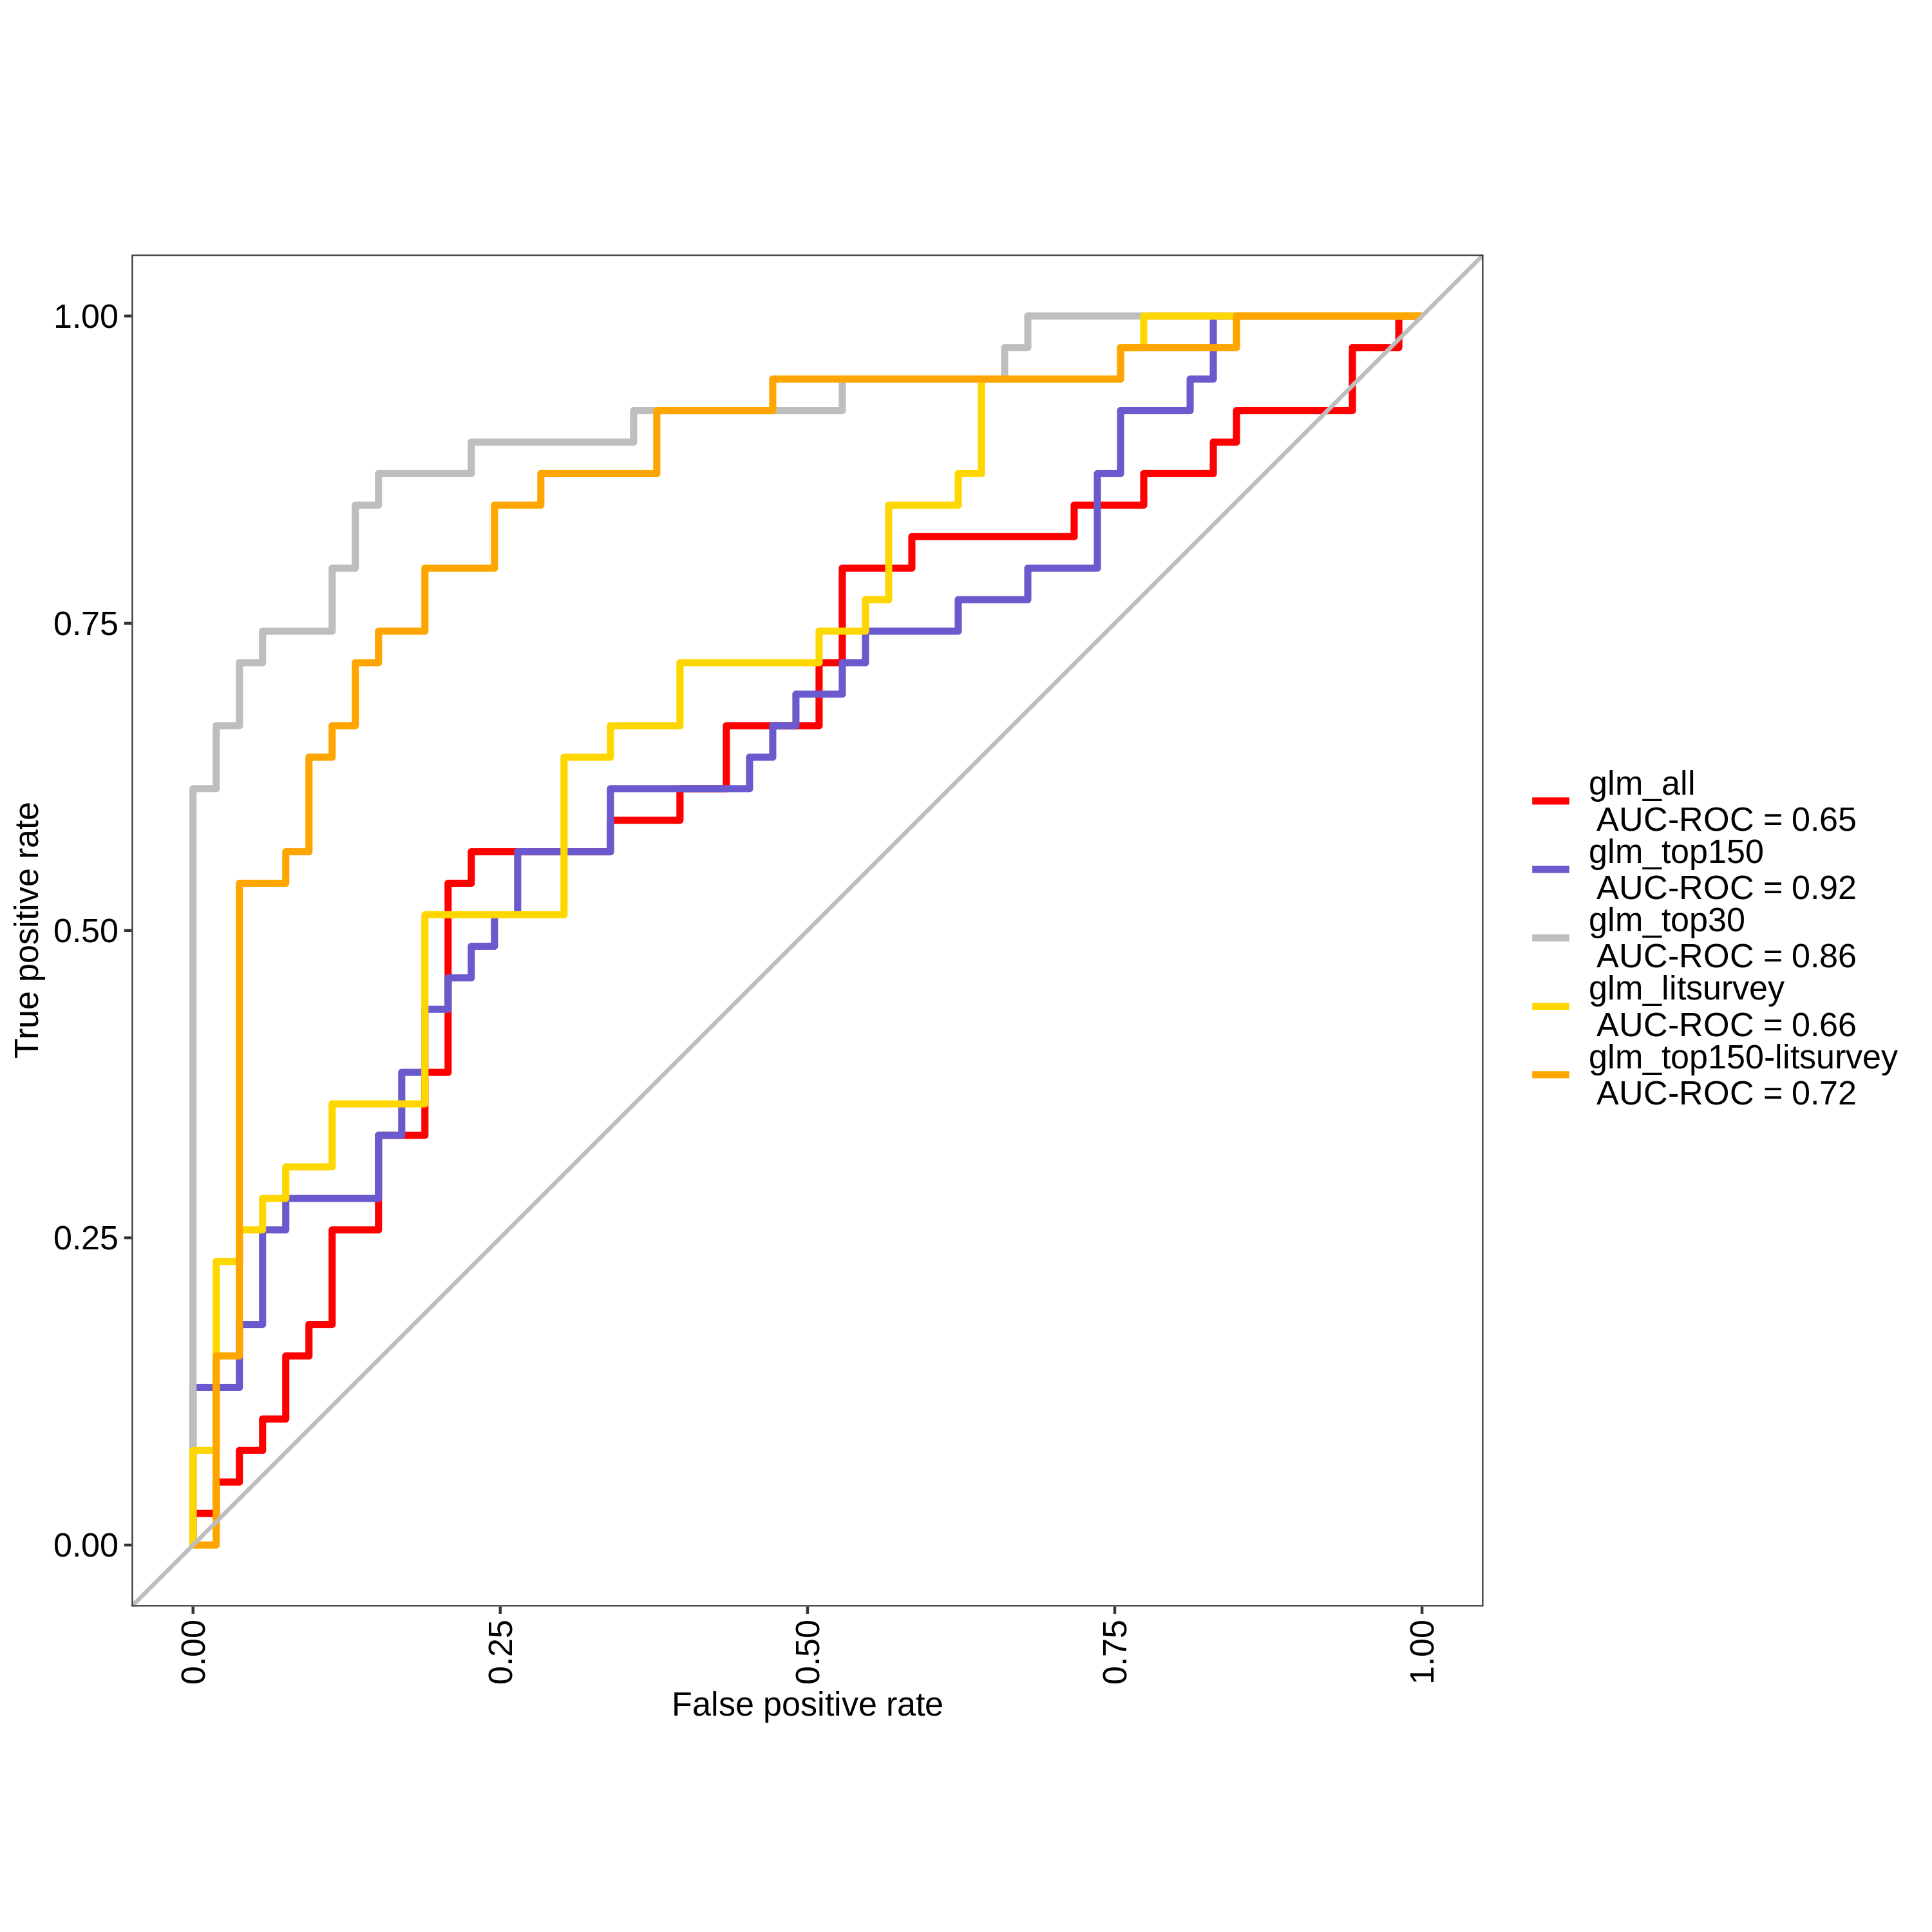

In [163]:
inp_top200_glm <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.200 >= 4, "Gene_ID"])],
              method="glmnet",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top50_glm <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.50 >= 4, "Gene_ID"])],
              method="glmnet",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_litsurvey_glm <- train(Response ~ ., data=mod_inp_mat[,c("Response", genes_lit_rawdata)],
              method="glmnet",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top200litsurvey_glm <- train(Response ~ ., data=mod_inp_mat[,c("Response", top_genes_out)],
              method="glmnet",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)
res_glm <- evalm(list(inp_top200_glm, inp_top50_glm, inp_litsurvey_glm, inp_top200litsurvey_glm),
             gnames=c('glm_top200', 'glm_top50', 'glm_litsurvey', 'glm_top200-litsurvey'))
res_glm$roc

## SVM

***MLeval: Machine Learning Model Evaluation***

Input: caret train function object

Averaging probs.

Group 1 type: repeatedcv

Group 2 type: repeatedcv

Group 3 type: repeatedcv

Group 4 type: repeatedcv

Group 5 type: repeatedcv

Observations: 460

Number of groups: 5

Observations per group: 92

Positive: Y

Negative: N

Group: svm_all

Positive: 39

Negative: 53

Group: svm_top150

Positive: 39

Negative: 53

Group: svm_top30

Positive: 39

Negative: 53

Group: svm_litsurvey

Positive: 39

Negative: 53

Group: svm_top150-litsurvey

Positive: 39

Negative: 53

***Performance Metrics***



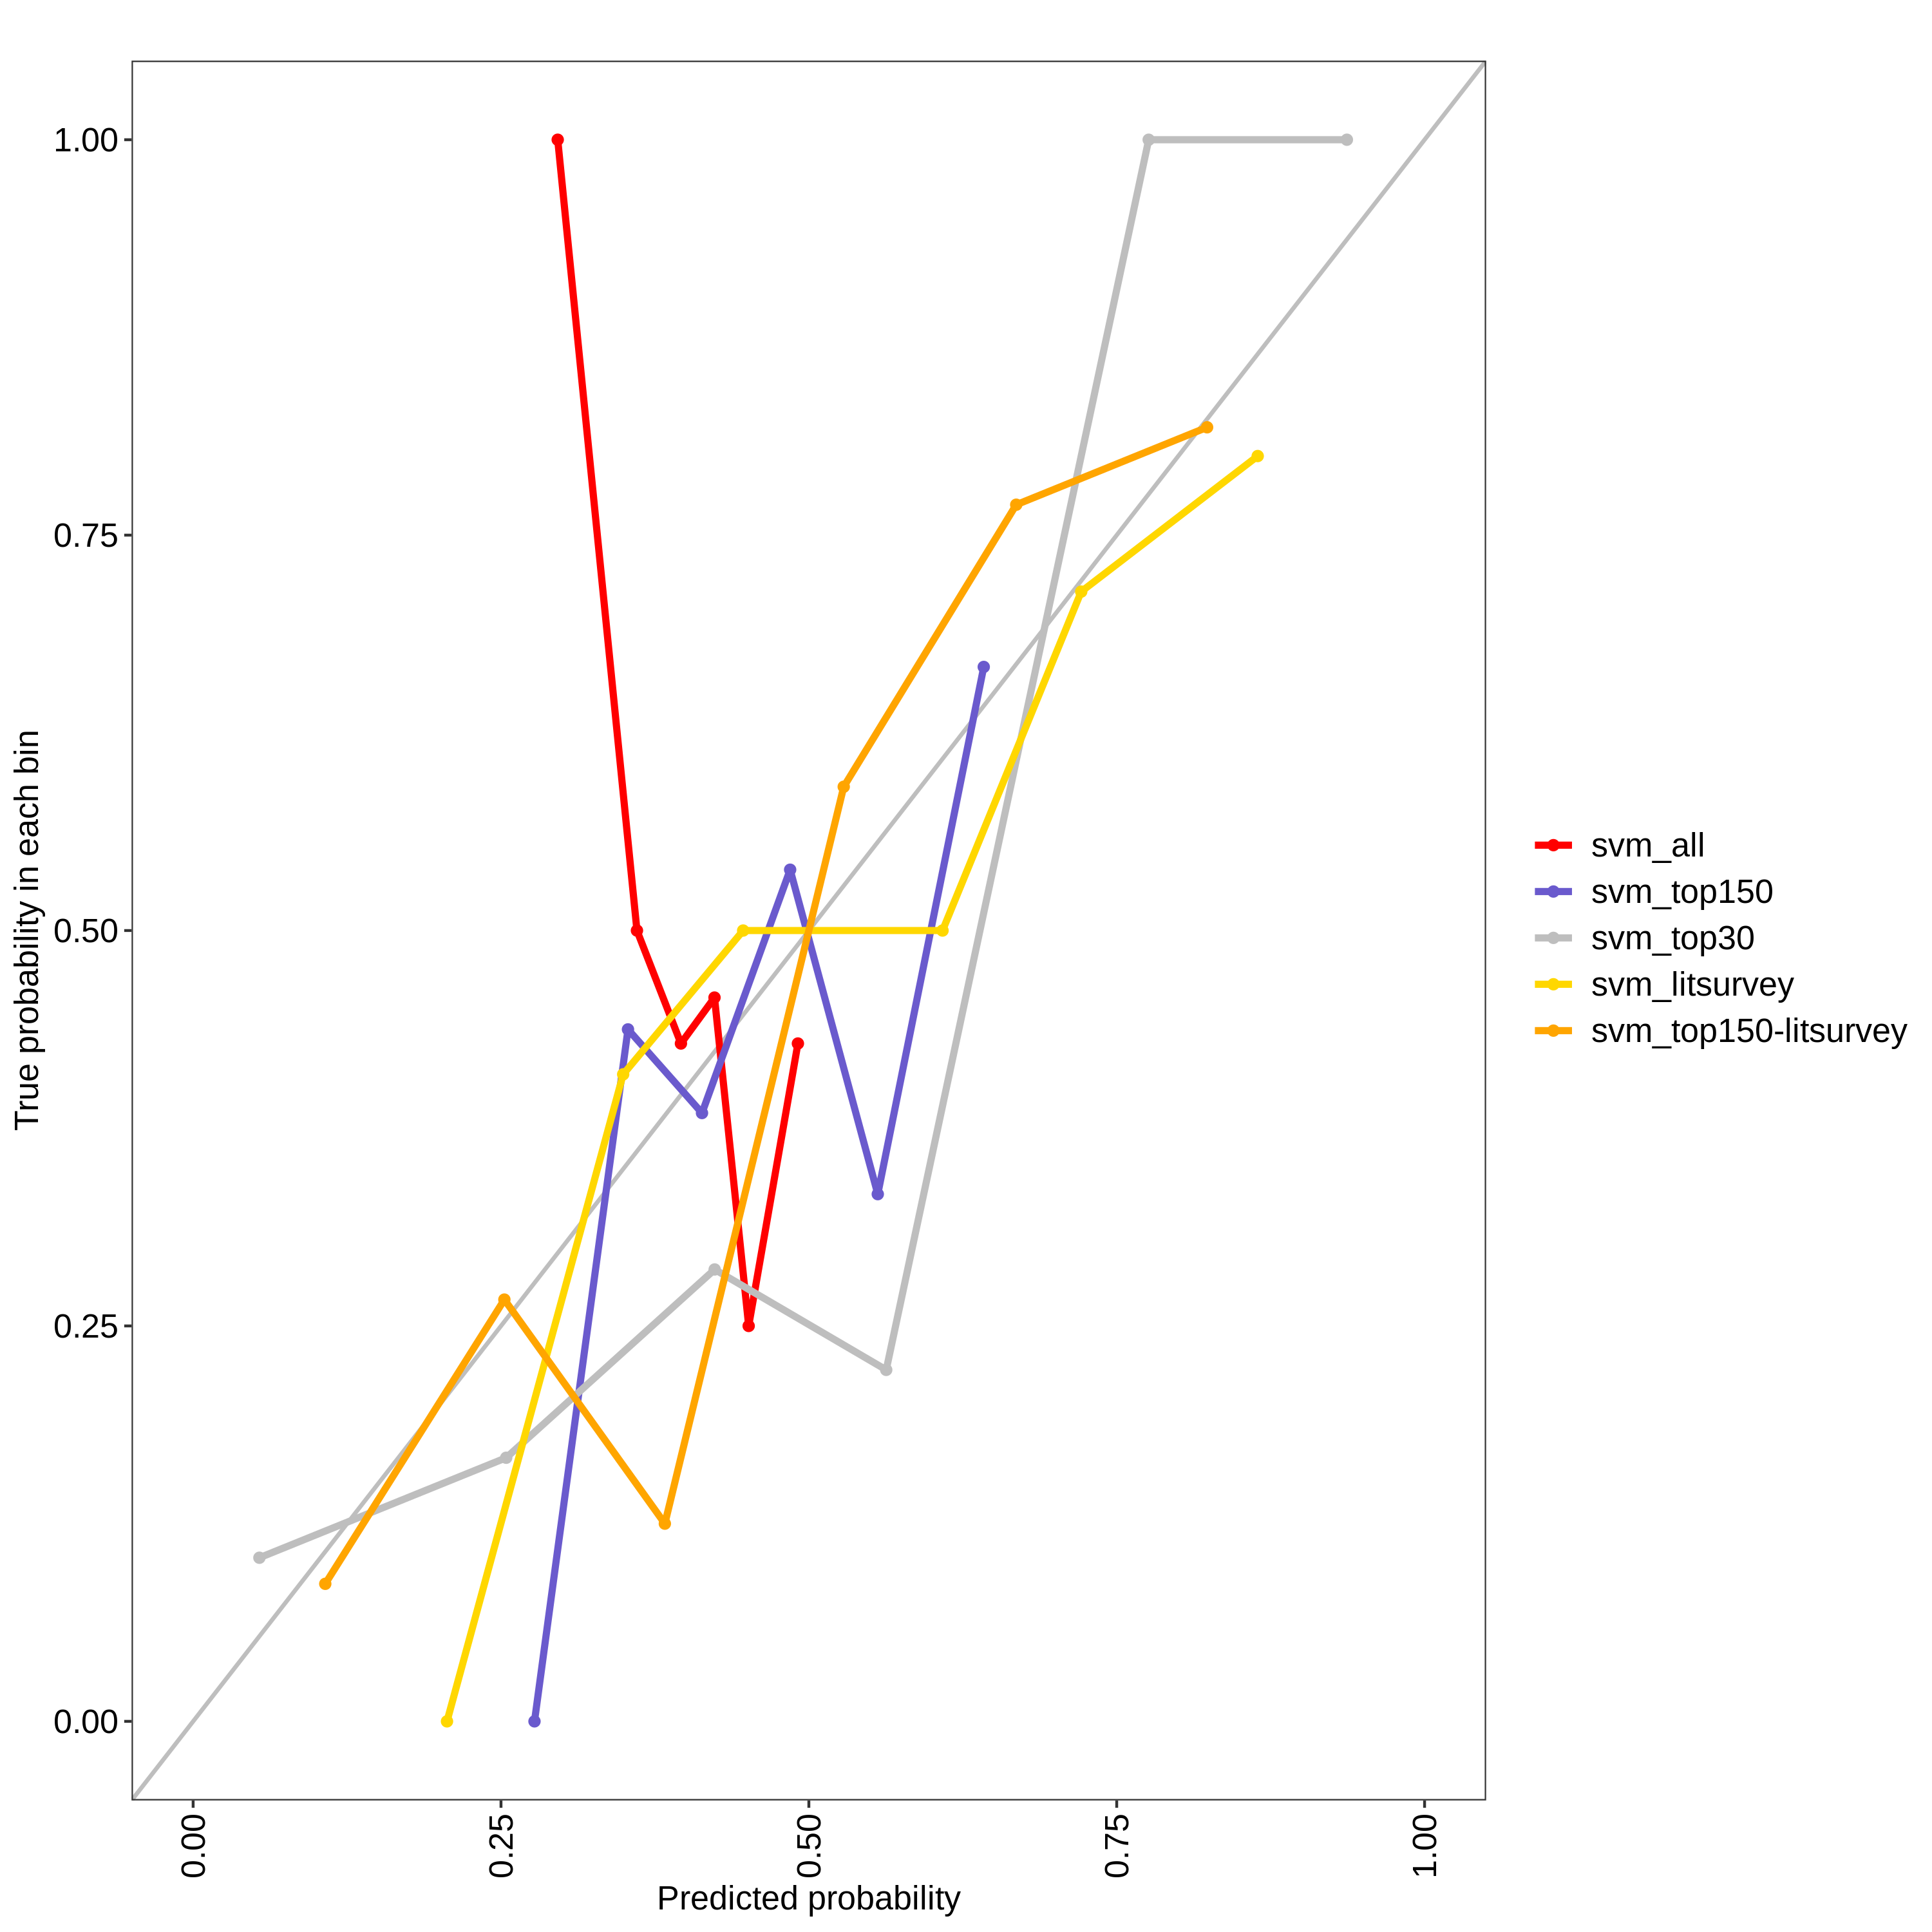

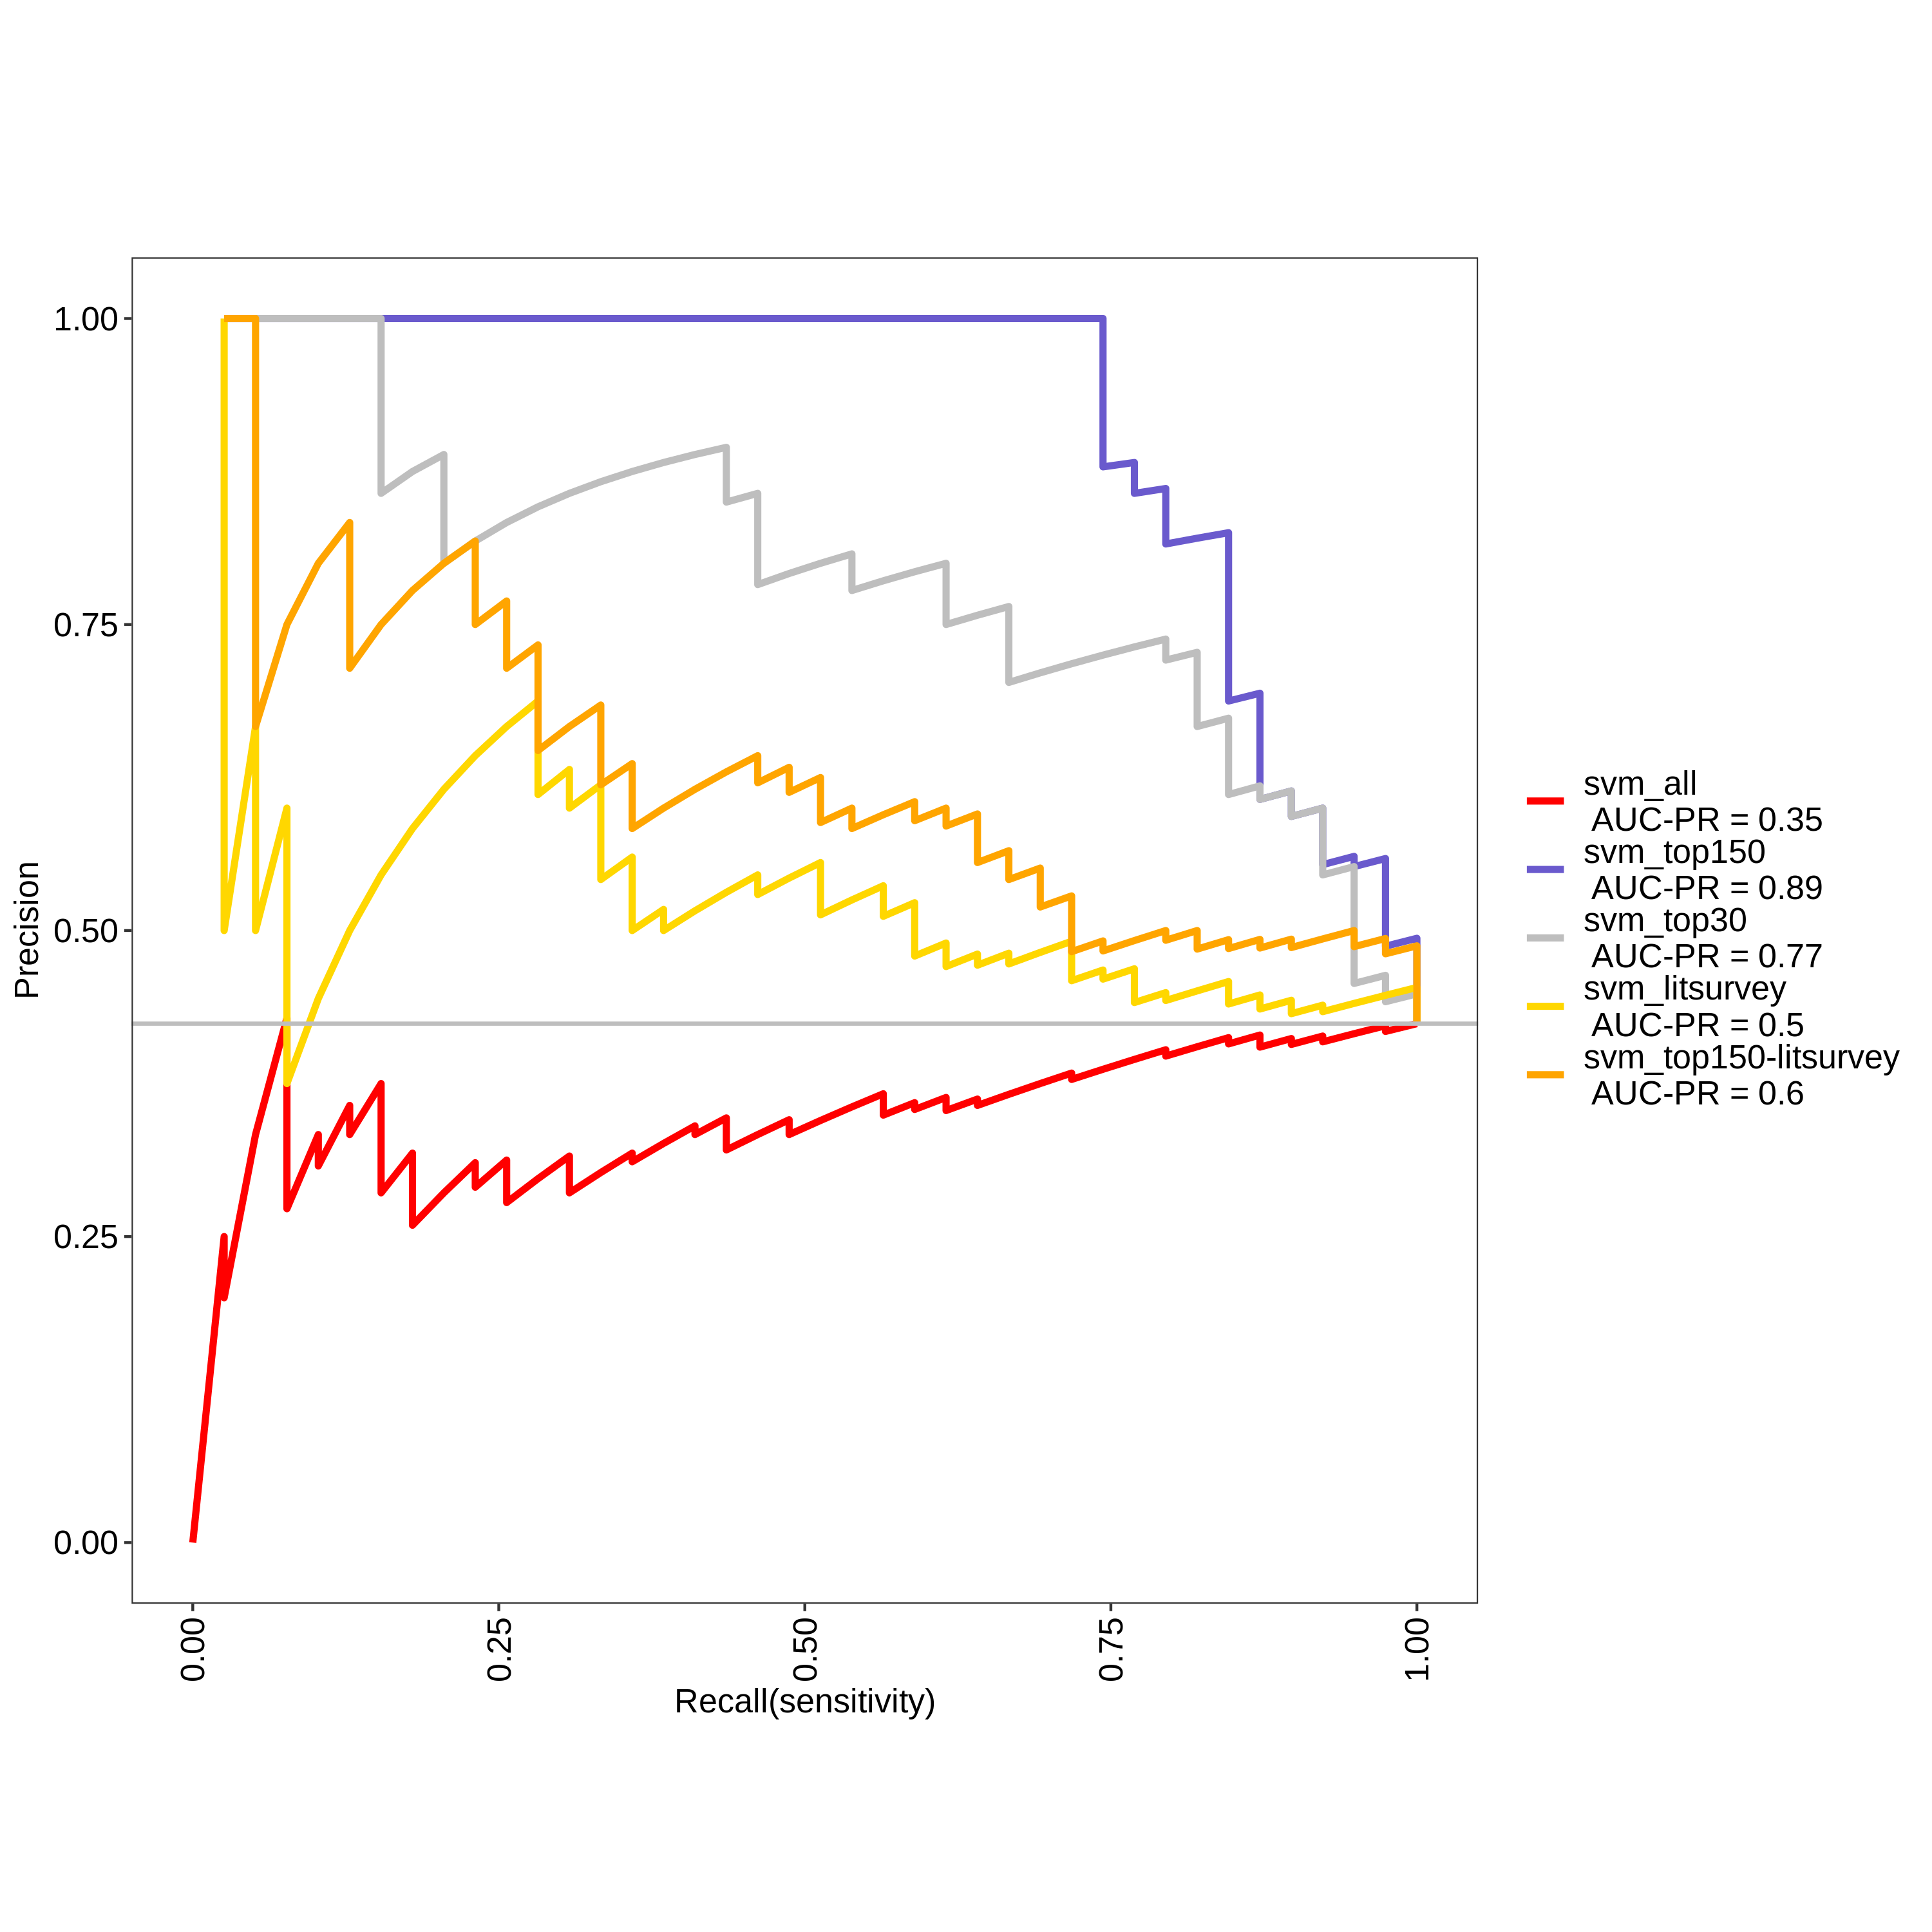

svm_all Optimal Informedness = 0.00145137880986934

svm_top150 Optimal Informedness = 0.743589743589744

svm_top30 Optimal Informedness = 0.594097726173198

svm_litsurvey Optimal Informedness = 0.210933720367683

svm_top150-litsurvey Optimal Informedness = 0.320270924044509

svm_all AUC-ROC = 0.37

svm_top150 AUC-ROC = 0.91

svm_top30 AUC-ROC = 0.83

svm_litsurvey AUC-ROC = 0.61

svm_top150-litsurvey AUC-ROC = 0.7



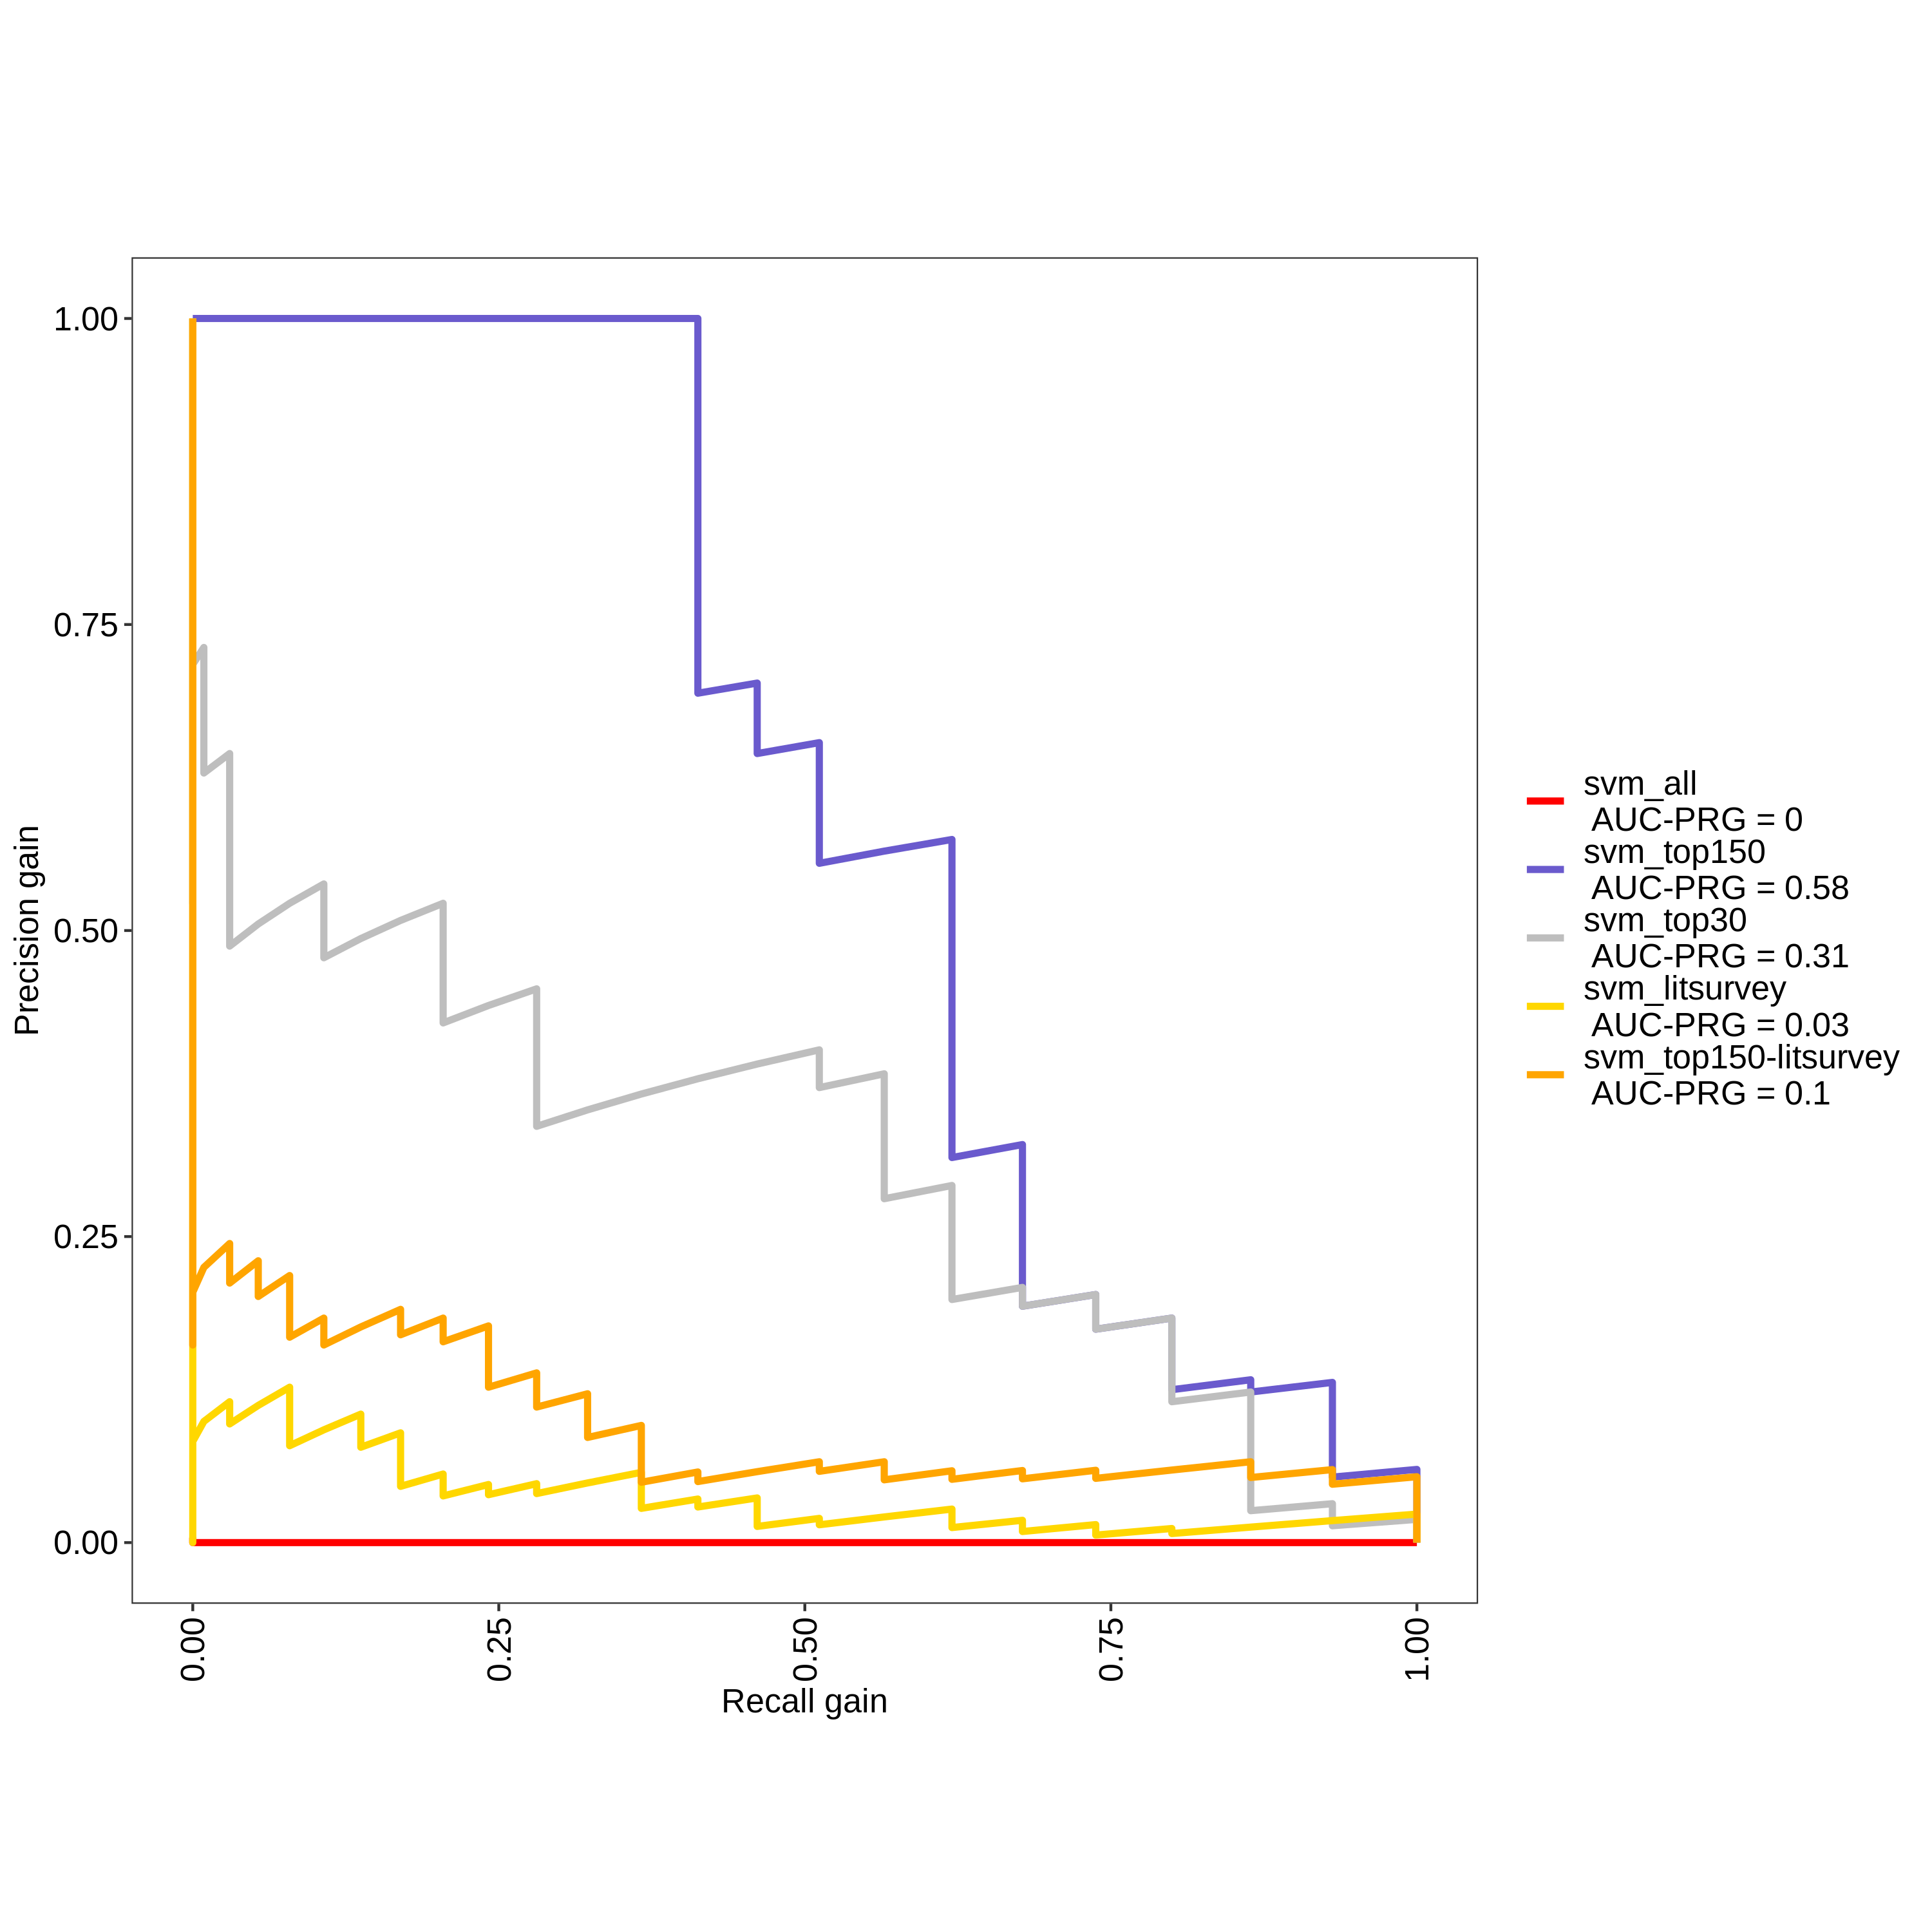

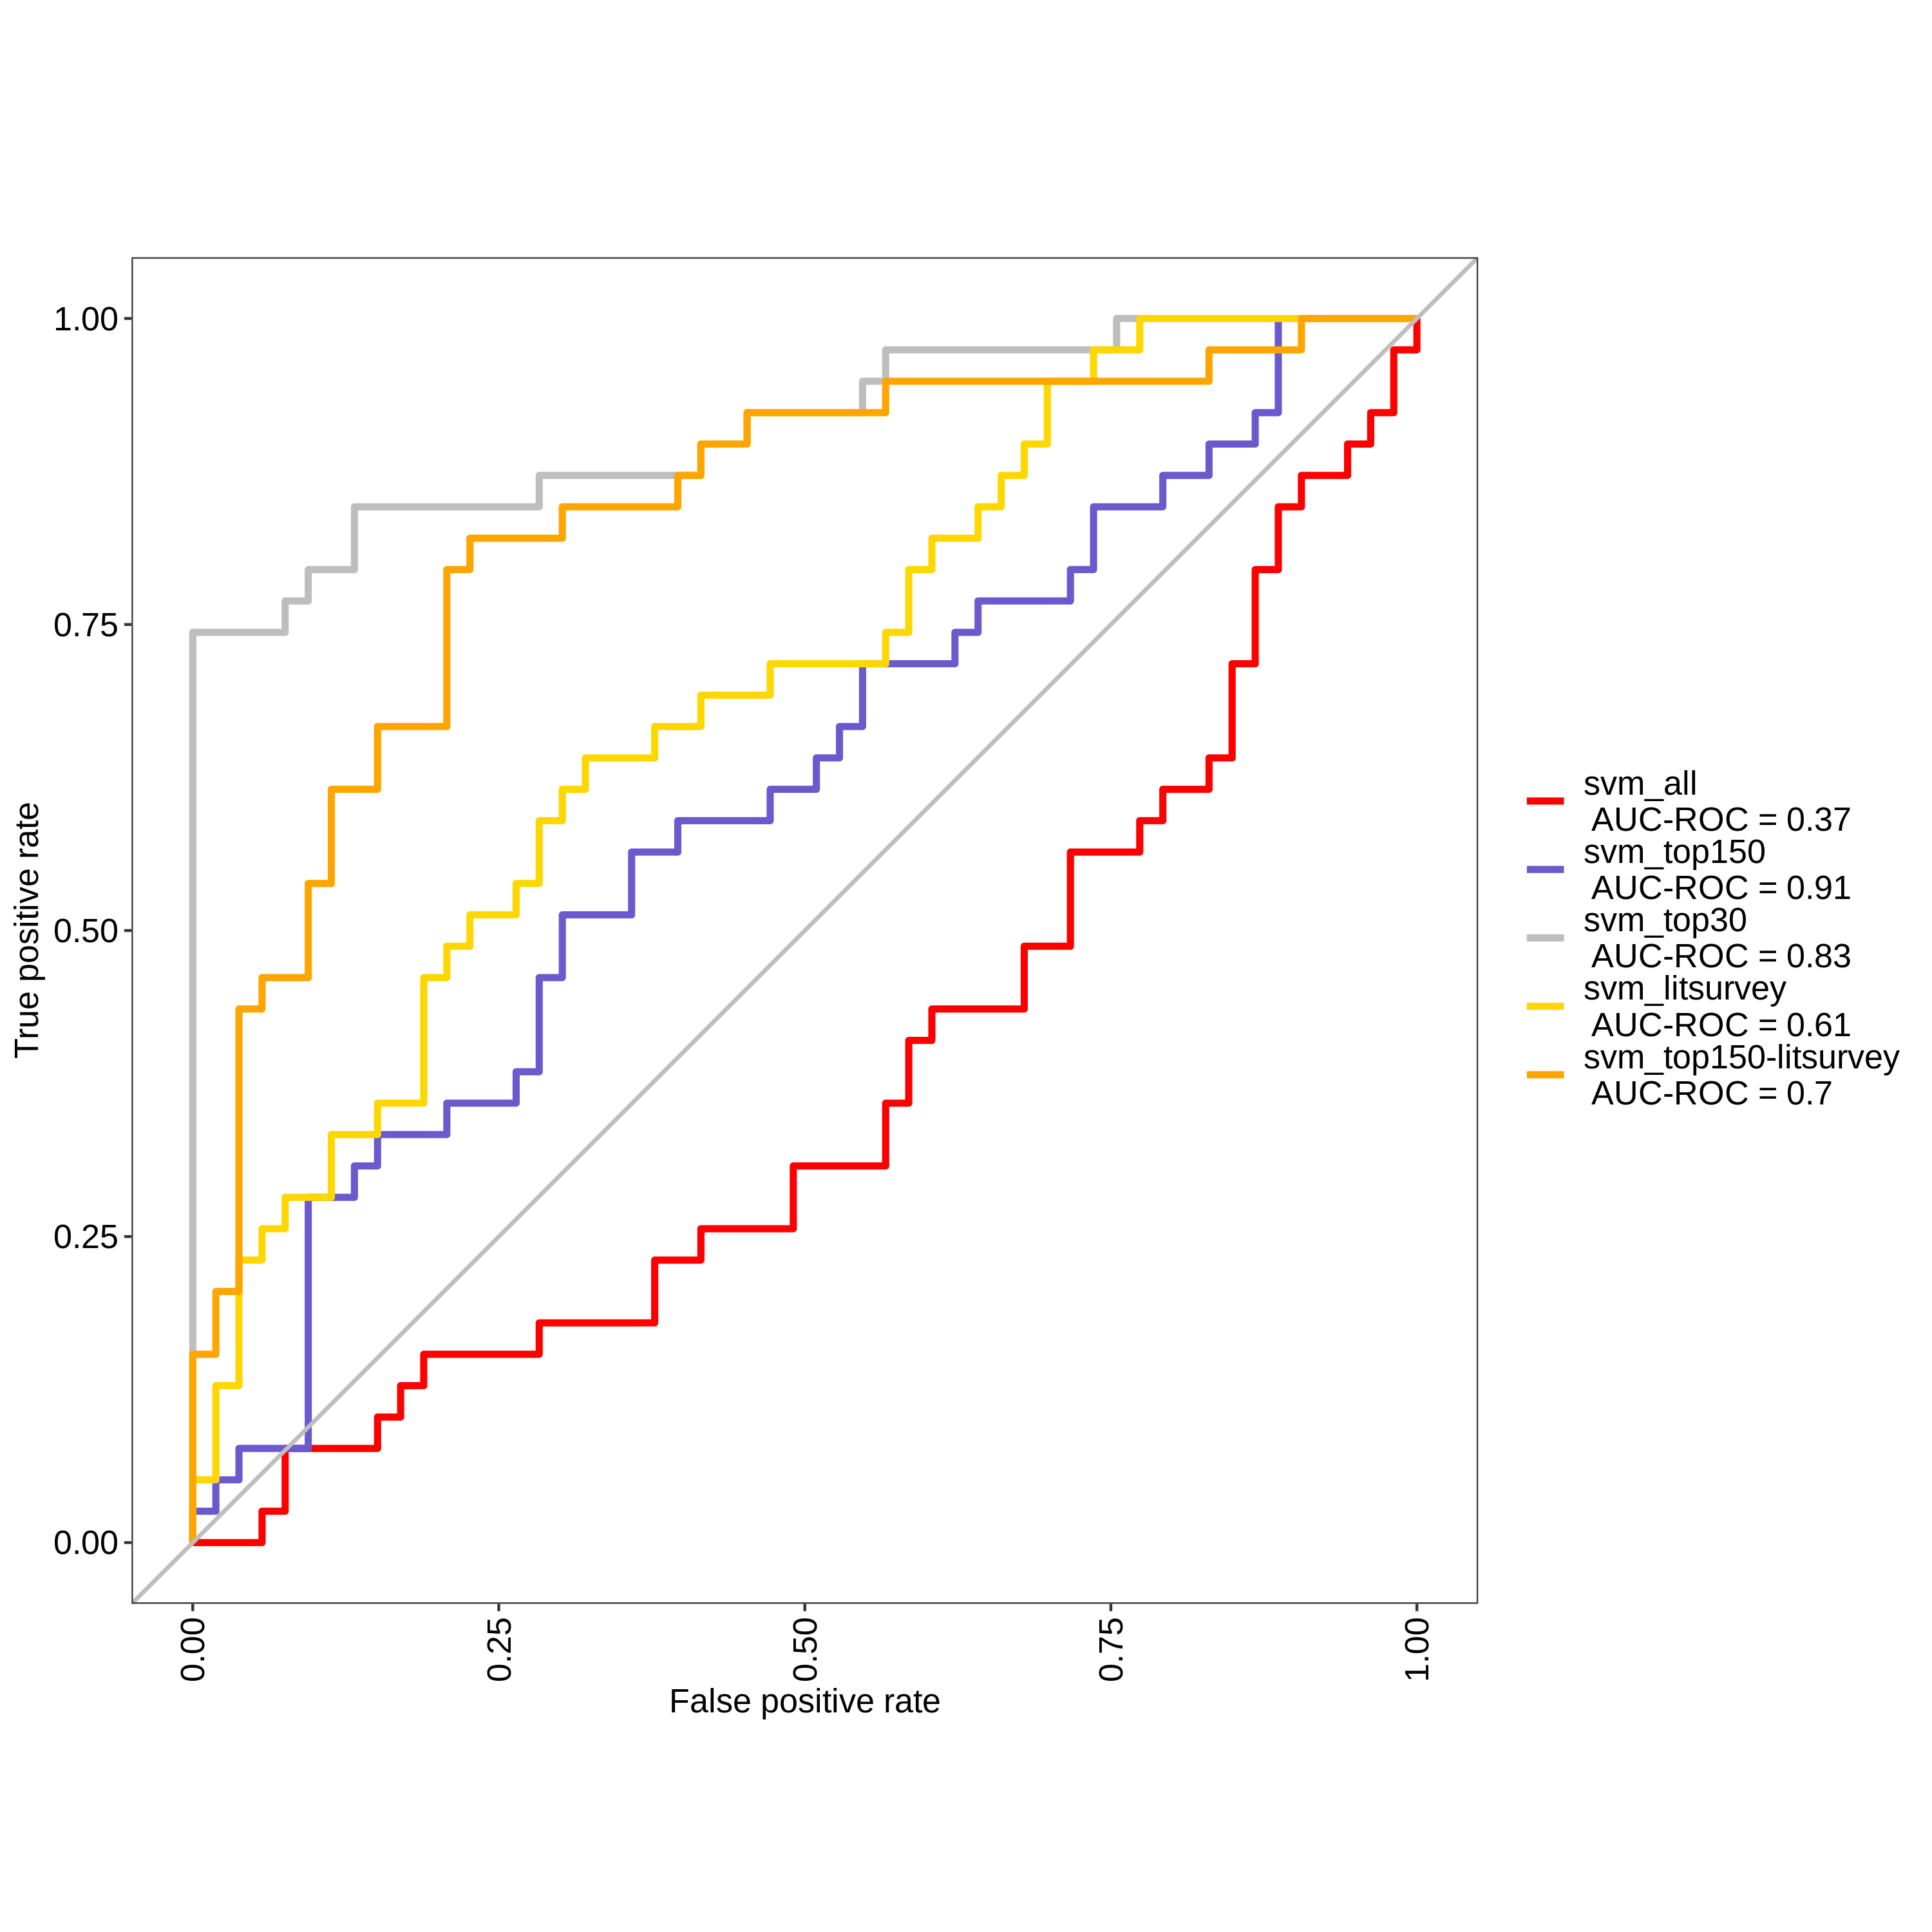

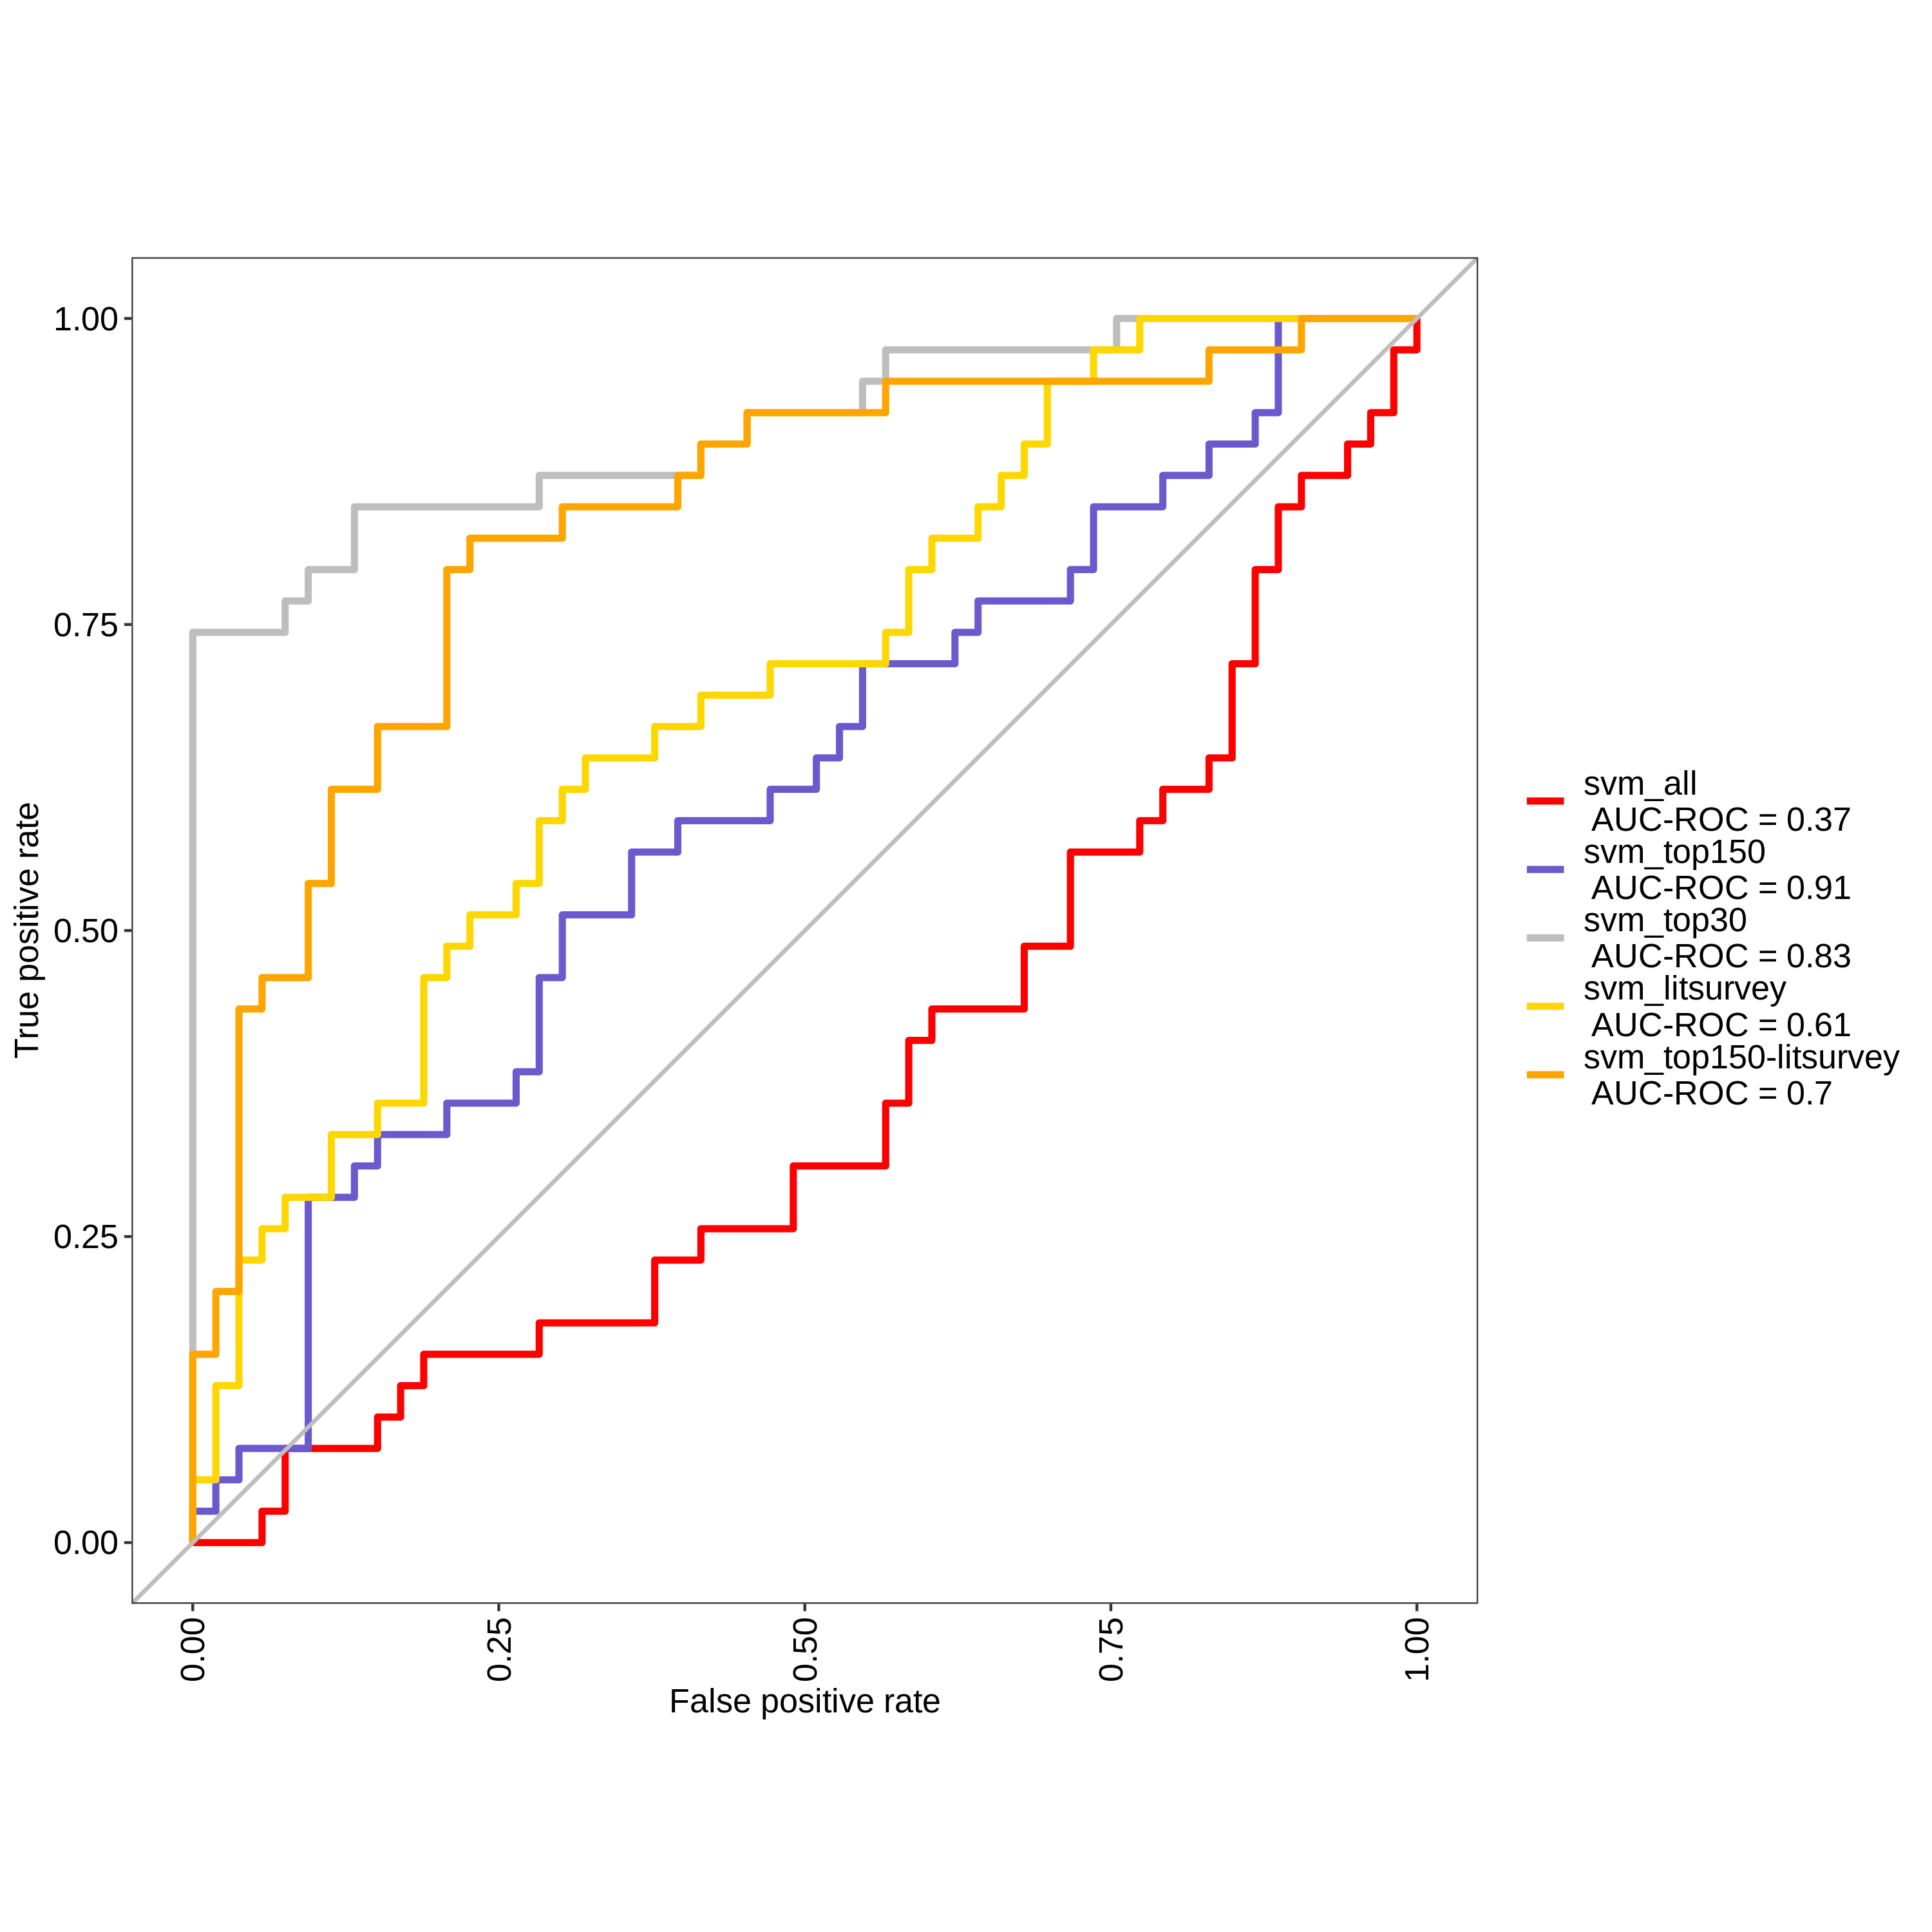

In [164]:
inp_top200_svm <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.200 >= 4, "Gene_ID"])],
              method="svmLinear2",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top50_svm <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.50 >= 4, "Gene_ID"])],
              method="svmLinear2",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_litsurvey_svm <- train(Response ~ ., data=mod_inp_mat[,c("Response", genes_lit_rawdata)],
              method="svmLinear2",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top200litsurvey_svm <- train(Response ~ ., data=mod_inp_mat[,c("Response", top_genes_out)],
              method="svmLinear2",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

res_svm <- evalm(list(inp_top200_svm, inp_top50_svm, inp_litsurvey_svm, inp_top200litsurvey_svm),
             gnames=c('svm_top200', 'svm_top50', 'svm_litsurvey', 'svm_top200-litsurvey'))
res_svm$roc

## PCA Neural Network

# weights:  84
initial  value 46.457262 
iter  10 value 39.376029
iter  20 value 38.911129
iter  30 value 38.567157
iter  40 value 38.195405
iter  50 value 38.195162
iter  60 value 37.159325
final  value 37.159303 
converged
# weights:  248
initial  value 44.562340 
iter  10 value 36.848003
iter  20 value 35.479666
iter  30 value 34.682117
iter  40 value 33.569601
iter  50 value 25.361942
iter  60 value 22.857744
iter  70 value 22.597020
iter  80 value 22.595028
iter  90 value 21.595352
final  value 21.595345 
converged
# weights:  412
initial  value 45.990447 
iter  10 value 30.273823
iter  20 value 25.329058
iter  30 value 21.653087
iter  40 value 20.713337
iter  50 value 20.698737
iter  60 value 20.698303
iter  70 value 19.896021
iter  80 value 19.895558
iter  80 value 19.895558
iter  80 value 19.895558
final  value 19.895558 
converged
# weights:  84
initial  value 47.184614 
iter  10 value 36.839262
iter  20 value 30.457627
iter  30 value 27.258031
iter  40 value 24.319075
iter  5

initial  value 49.268824 
iter  10 value 33.008295
iter  20 value 24.727598
iter  30 value 20.244054
iter  40 value 17.796878
iter  50 value 17.701398
iter  60 value 16.163633
iter  70 value 15.507186
iter  80 value 15.495529
iter  90 value 15.492654
iter 100 value 15.226777
final  value 15.226777 
stopped after 100 iterations
# weights:  82
initial  value 40.918340 
iter  10 value 39.554603
iter  20 value 38.375738
iter  30 value 38.373802
iter  40 value 38.010739
final  value 38.010732 
converged
# weights:  242
initial  value 42.396519 
iter  10 value 32.783896
iter  20 value 31.640085
iter  30 value 31.363927
iter  40 value 30.387890
iter  50 value 28.874018
iter  60 value 26.385763
iter  70 value 25.278223
iter  80 value 23.315236
iter  90 value 23.232013
iter 100 value 22.676737
final  value 22.676737 
stopped after 100 iterations
# weights:  402
initial  value 47.228508 
iter  10 value 30.257287
iter  20 value 25.643629
iter  30 value 24.714835
iter  40 value 24.408362
iter  50 

initial  value 49.901934 
iter  10 value 27.787320
iter  20 value 18.650976
iter  30 value 16.384143
iter  40 value 15.812547
iter  50 value 15.579265
iter  60 value 15.566489
iter  70 value 15.254379
iter  80 value 14.211001
iter  90 value 14.205839
iter 100 value 14.195547
final  value 14.195547 
stopped after 100 iterations
# weights:  83
initial  value 40.433665 
iter  10 value 35.672290
iter  20 value 32.435444
iter  30 value 32.432643
iter  40 value 32.432562
final  value 32.432560 
converged
# weights:  245
initial  value 40.624539 
iter  10 value 30.426550
iter  20 value 30.189637
iter  30 value 29.700807
iter  40 value 29.700016
iter  50 value 29.527046
iter  60 value 28.810242
iter  70 value 28.504328
iter  80 value 28.451560
iter  90 value 28.451531
final  value 28.451530 
converged
# weights:  407
initial  value 46.730694 
iter  10 value 36.993662
iter  20 value 27.992093
iter  30 value 24.809273
iter  40 value 20.154848
iter  50 value 19.975040
iter  60 value 19.961456
ite

initial  value 45.199839 
iter  10 value 33.479339
iter  20 value 28.911864
iter  30 value 23.365476
iter  40 value 20.589650
iter  50 value 18.462518
iter  60 value 17.421830
iter  70 value 16.039720
iter  80 value 14.742414
iter  90 value 14.491848
iter 100 value 12.512302
final  value 12.512302 
stopped after 100 iterations
# weights:  84
initial  value 44.874100 
iter  10 value 38.733941
iter  20 value 38.080453
iter  30 value 38.078375
iter  40 value 36.998505
iter  50 value 35.919690
final  value 35.919627 
converged
# weights:  248
initial  value 45.246141 
iter  10 value 33.766184
iter  20 value 27.238589
iter  30 value 25.374057
iter  40 value 25.152258
iter  50 value 24.652964
iter  60 value 24.652239
iter  70 value 24.652229
iter  80 value 23.703380
final  value 23.697059 
converged
# weights:  412
initial  value 44.258720 
iter  10 value 33.322885
iter  20 value 24.657921
iter  30 value 20.620614
iter  40 value 18.137801
iter  50 value 17.683465
iter  60 value 17.589518
ite

initial  value 42.875885 
iter  10 value 34.354582
iter  20 value 30.393996
iter  30 value 28.179486
iter  40 value 28.019059
iter  50 value 27.588541
iter  60 value 26.140004
iter  70 value 24.306142
iter  80 value 24.096963
iter  90 value 23.681464
iter 100 value 21.799027
final  value 21.799027 
stopped after 100 iterations
# weights:  407
initial  value 41.339610 
iter  10 value 24.531790
iter  20 value 17.452605
iter  30 value 16.109987
iter  40 value 15.738540
iter  50 value 15.726790
iter  60 value 15.723277
iter  70 value 15.563628
iter  80 value 15.552676
iter  90 value 15.549369
iter 100 value 15.548699
final  value 15.548699 
stopped after 100 iterations
# weights:  84
initial  value 43.662818 
iter  10 value 37.759663
iter  20 value 36.550370
iter  30 value 35.930249
iter  40 value 35.360077
final  value 35.360024 
converged
# weights:  248
initial  value 39.081706 
iter  10 value 36.733654
iter  20 value 34.094399
iter  30 value 32.963583
iter  40 value 32.813745
iter  50 

initial  value 46.071954 
iter  10 value 38.350525
iter  20 value 32.849832
iter  30 value 31.814077
iter  40 value 29.302622
iter  50 value 28.892437
iter  60 value 27.285067
iter  70 value 27.121532
iter  80 value 27.116340
iter  90 value 27.071898
iter 100 value 25.847140
final  value 25.847140 
stopped after 100 iterations
# weights:  407
initial  value 43.723077 
iter  10 value 28.468780
iter  20 value 24.771739
iter  30 value 23.325396
iter  40 value 21.792521
iter  50 value 21.595348
iter  60 value 21.592967
iter  70 value 19.811181
iter  80 value 18.215410
iter  90 value 18.151219
iter 100 value 17.005075
final  value 17.005075 
stopped after 100 iterations
# weights:  83
initial  value 44.915568 
iter  10 value 40.169356
iter  20 value 36.733710
iter  30 value 36.462714
final  value 36.462705 
converged
# weights:  245
initial  value 45.711528 
iter  10 value 32.829469
iter  20 value 29.189662
iter  30 value 26.186071
iter  40 value 24.674325
iter  50 value 23.588851
iter  60 

initial  value 42.149207 
iter  10 value 38.221517
iter  20 value 37.226334
iter  30 value 36.696008
iter  40 value 36.695411
iter  50 value 36.176991
iter  60 value 35.615082
iter  70 value 35.614687
iter  80 value 35.614061
iter  90 value 35.613911
iter 100 value 35.613773
final  value 35.613773 
stopped after 100 iterations
# weights:  242
initial  value 42.898091 
iter  10 value 27.589214
iter  20 value 24.512013
iter  30 value 24.277773
iter  40 value 24.241496
iter  50 value 22.921771
iter  60 value 22.501114
iter  70 value 22.241705
iter  80 value 22.237273
iter  90 value 20.682249
iter 100 value 19.069299
final  value 19.069299 
stopped after 100 iterations
# weights:  402
initial  value 43.395320 
iter  10 value 32.724008
iter  20 value 26.126930
iter  30 value 22.248990
iter  40 value 20.645402
iter  50 value 19.280658
iter  60 value 19.279246
iter  70 value 19.082751
iter  80 value 16.500750
iter  90 value 16.273632
iter 100 value 16.001789
final  value 16.001789 
stopped af

initial  value 42.769042 
iter  10 value 39.381520
iter  20 value 39.365045
iter  30 value 38.715954
iter  40 value 37.375858
iter  50 value 37.320944
iter  60 value 35.770350
iter  70 value 35.765179
iter  80 value 35.153364
iter  90 value 35.153247
iter 100 value 35.152996
final  value 35.152996 
stopped after 100 iterations
# weights:  245
initial  value 40.280482 
iter  10 value 36.329102
iter  20 value 33.942072
iter  30 value 27.807452
iter  40 value 27.337880
iter  50 value 27.335163
iter  60 value 26.737983
iter  70 value 25.899577
iter  80 value 25.103203
iter  90 value 25.065030
iter 100 value 23.518568
final  value 23.518568 
stopped after 100 iterations
# weights:  407
initial  value 47.513565 
iter  10 value 36.715263
iter  20 value 26.999841
iter  30 value 23.860092
iter  40 value 21.167709
iter  50 value 21.128893
iter  60 value 19.846424
iter  70 value 19.281495
iter  80 value 19.265332
iter  90 value 19.190842
iter 100 value 18.950763
final  value 18.950763 
stopped af

initial  value 42.419710 
iter  10 value 39.237591
iter  20 value 36.806979
iter  30 value 33.081254
iter  40 value 33.079159
iter  50 value 31.583258
iter  60 value 30.944731
iter  70 value 30.507712
iter  80 value 30.506314
iter  90 value 30.180620
iter 100 value 29.862366
final  value 29.862366 
stopped after 100 iterations
# weights:  242
initial  value 42.350815 
iter  10 value 37.613350
iter  20 value 34.630607
iter  30 value 30.292412
iter  40 value 29.500604
iter  50 value 29.169291
iter  60 value 28.245507
iter  70 value 24.952339
iter  80 value 23.586541
iter  90 value 22.988299
iter 100 value 22.913598
final  value 22.913598 
stopped after 100 iterations
# weights:  402
initial  value 45.499348 
iter  10 value 32.045221
iter  20 value 27.231806
iter  30 value 22.182435
iter  40 value 21.921721
iter  50 value 21.913725
iter  60 value 21.818584
iter  70 value 21.807842
iter  80 value 21.803736
iter  90 value 21.653922
iter 100 value 21.413286
final  value 21.413286 
stopped af

initial  value 41.869247 
iter  10 value 40.044322
iter  20 value 36.105979
iter  30 value 34.310628
iter  40 value 34.310031
iter  50 value 34.309628
iter  60 value 34.309366
iter  70 value 32.540856
iter  80 value 27.915991
iter  90 value 27.820093
iter 100 value 27.813610
final  value 27.813610 
stopped after 100 iterations
# weights:  245
initial  value 39.159944 
iter  10 value 34.096900
iter  20 value 29.849168
iter  30 value 29.333787
iter  40 value 28.554166
iter  50 value 26.520799
iter  60 value 26.195633
iter  70 value 26.188697
iter  80 value 25.216084
iter  90 value 24.576778
iter 100 value 23.564077
final  value 23.564077 
stopped after 100 iterations
# weights:  407
initial  value 48.107431 
iter  10 value 31.911801
iter  20 value 27.406110
iter  30 value 23.605709
iter  40 value 21.621383
iter  50 value 19.837949
iter  60 value 17.250370
iter  70 value 16.075507
iter  80 value 15.394449
iter  90 value 15.333514
iter 100 value 15.113593
final  value 15.113593 
stopped af

initial  value 52.843274 
iter  10 value 39.930883
iter  20 value 33.861511
iter  30 value 24.573173
iter  40 value 19.312147
iter  50 value 14.484975
iter  60 value 11.545124
iter  70 value 10.655623
iter  80 value 8.127218
iter  90 value 7.007532
iter 100 value 5.825460
final  value 5.825460 
stopped after 100 iterations
# weights:  83
initial  value 42.481192 
iter  10 value 40.075250
iter  20 value 39.776787
iter  30 value 39.774179
iter  40 value 37.354682
iter  50 value 35.129521
iter  60 value 35.122287
iter  70 value 30.913291
iter  80 value 30.731659
iter  90 value 30.731287
iter 100 value 30.729694
final  value 30.729694 
stopped after 100 iterations
# weights:  245
initial  value 43.556215 
iter  10 value 36.684739
iter  20 value 34.889766
iter  30 value 31.835923
iter  40 value 28.248732
iter  50 value 25.332755
iter  60 value 22.640916
iter  70 value 21.736362
iter  80 value 21.693489
iter  90 value 21.632268
iter 100 value 21.125426
final  value 21.125426 
stopped after 1

initial  value 38.163756 
iter  10 value 3.491327
iter  20 value 3.090123
iter  30 value 3.053334
iter  40 value 3.047577
iter  50 value 3.034773
iter  60 value 2.882296
iter  70 value 2.870697
iter  80 value 1.691687
iter  90 value 1.378562
iter 100 value 1.042128
final  value 1.042128 
stopped after 100 iterations
# weights:  332
initial  value 44.441007 
iter  10 value 2.026919
iter  20 value 0.107268
iter  30 value 0.096017
iter  40 value 0.081037
iter  50 value 0.071777
iter  60 value 0.064416
iter  70 value 0.054293
iter  80 value 0.046100
iter  90 value 0.039330
iter 100 value 0.035732
final  value 0.035732 
stopped after 100 iterations
# weights:  68
initial  value 43.128908 
iter  10 value 13.878918
iter  20 value 13.447195
iter  30 value 13.329644
iter  40 value 12.698383
final  value 12.684211 
converged
# weights:  200
initial  value 41.950765 
iter  10 value 12.284823
iter  20 value 10.593029
iter  30 value 9.451861
iter  40 value 5.666909
iter  50 value 2.292902
iter  60 

initial  value 46.882162 
iter  10 value 12.746474
iter  20 value 4.217983
iter  30 value 2.678613
iter  40 value 1.044392
iter  50 value 0.548097
iter  60 value 0.018103
iter  70 value 0.006862
iter  80 value 0.002622
iter  90 value 0.001043
iter 100 value 0.000773
final  value 0.000773 
stopped after 100 iterations
# weights:  337
initial  value 41.966767 
iter  10 value 8.766707
iter  20 value 6.719400
iter  30 value 5.221186
iter  40 value 4.016398
iter  50 value 4.005597
iter  60 value 4.001358
iter  70 value 4.000736
iter  80 value 4.000202
iter  90 value 3.999946
iter 100 value 3.999756
final  value 3.999756 
stopped after 100 iterations
# weights:  69
initial  value 41.337307 
iter  10 value 12.908652
iter  20 value 8.679114
iter  30 value 7.397096
iter  40 value 7.394905
final  value 7.394905 
converged
# weights:  203
initial  value 43.735245 
iter  10 value 9.288027
iter  20 value 4.827273
iter  30 value 4.445939
iter  40 value 4.445462
final  value 4.445457 
converged
# wei

initial  value 44.986643 
iter  10 value 10.368235
iter  20 value 4.895600
iter  30 value 4.474593
iter  40 value 4.470064
final  value 4.470059 
converged
# weights:  332
initial  value 55.640663 
iter  10 value 8.582301
iter  20 value 4.335643
iter  30 value 3.962392
iter  40 value 3.951366
iter  50 value 3.951063
final  value 3.951061 
converged
# weights:  68
initial  value 45.077393 
iter  10 value 12.046864
iter  20 value 11.902024
iter  30 value 9.873352
iter  40 value 9.766632
iter  50 value 9.760014
iter  60 value 9.750182
iter  70 value 9.732707
iter  80 value 9.687014
iter  90 value 9.632909
iter 100 value 9.552313
final  value 9.552313 
stopped after 100 iterations
# weights:  200
initial  value 41.352383 
iter  10 value 5.197458
iter  20 value 5.101336
iter  30 value 2.115893
iter  40 value 2.070919
iter  50 value 2.059735
iter  60 value 2.052196
iter  70 value 2.043919
iter  80 value 2.037181
iter  90 value 2.030776
iter 100 value 2.022853
final  value 2.022853 
stopped a

initial  value 41.714381 
final  value 12.000000 
converged
# weights:  200
initial  value 51.465138 
iter  10 value 9.822109
iter  20 value 9.361061
iter  30 value 8.526782
iter  40 value 7.324112
iter  50 value 5.482855
iter  60 value 3.482827
iter  70 value 1.509545
iter  80 value 1.501889
iter  90 value 1.500281
iter 100 value 1.500164
final  value 1.500164 
stopped after 100 iterations
# weights:  332
initial  value 41.437870 
iter  10 value 10.506407
iter  20 value 7.097997
iter  30 value 6.036686
iter  40 value 6.010176
iter  50 value 6.001396
iter  60 value 6.000629
iter  70 value 6.000383
iter  80 value 6.000207
iter  90 value 6.000105
final  value 6.000093 
converged
# weights:  68
initial  value 46.150153 
iter  10 value 9.261077
iter  20 value 7.579349
iter  30 value 7.413638
iter  40 value 7.408003
final  value 7.407997 
converged
# weights:  200
initial  value 46.206791 
iter  10 value 8.437789
iter  20 value 4.625990
iter  30 value 4.405570
iter  40 value 4.400530
final 

initial  value 44.940808 
iter  10 value 6.656003
iter  20 value 3.470312
iter  30 value 2.143873
iter  40 value 2.109809
iter  50 value 2.102225
iter  60 value 2.090087
iter  70 value 2.076105
iter  80 value 1.521500
iter  90 value 0.076617
iter 100 value 0.070334
final  value 0.070334 
stopped after 100 iterations
# weights:  332
initial  value 43.509296 
iter  10 value 3.012720
iter  20 value 1.916745
iter  30 value 0.211838
iter  40 value 0.164538
iter  50 value 0.147290
iter  60 value 0.127864
iter  70 value 0.112328
iter  80 value 0.102715
iter  90 value 0.083458
iter 100 value 0.072836
final  value 0.072836 
stopped after 100 iterations
# weights:  69
initial  value 43.879633 
iter  10 value 13.565365
iter  20 value 13.254450
iter  30 value 12.944321
iter  40 value 12.943705
final  value 12.943662 
converged
# weights:  203
initial  value 40.658041 
iter  10 value 5.593121
iter  20 value 5.572573
iter  30 value 5.561895
iter  40 value 5.356486
iter  50 value 4.954884
iter  60 va

initial  value 47.530291 
iter  10 value 12.961976
iter  20 value 11.352082
iter  30 value 11.333144
iter  40 value 11.331241
iter  50 value 10.967324
iter  60 value 10.862354
iter  70 value 9.067740
iter  80 value 7.094711
iter  90 value 7.084438
iter 100 value 7.081976
final  value 7.081976 
stopped after 100 iterations
# weights:  332
initial  value 45.623875 
iter  10 value 14.956152
iter  20 value 14.194192
iter  30 value 13.493735
iter  40 value 11.166235
iter  50 value 10.373135
iter  60 value 9.082886
iter  70 value 8.878894
iter  80 value 7.229892
iter  90 value 5.313976
iter 100 value 4.773137
final  value 4.773137 
stopped after 100 iterations
# weights:  68
initial  value 46.684779 
iter  10 value 17.554209
iter  20 value 9.149162
iter  30 value 7.674570
iter  40 value 7.658537
final  value 7.658510 
converged
# weights:  200
initial  value 52.458894 
iter  10 value 13.632846
iter  20 value 5.923411
iter  30 value 4.577917
iter  40 value 4.536988
final  value 4.536963 
conv

initial  value 43.129672 
iter  10 value 10.745670
iter  20 value 7.783725
iter  30 value 7.505549
iter  40 value 7.496779
iter  50 value 7.492856
iter  60 value 7.490493
iter  70 value 7.487815
iter  80 value 5.596167
iter  90 value 5.548776
iter 100 value 5.547528
final  value 5.547528 
stopped after 100 iterations
# weights:  197
initial  value 40.020669 
iter  10 value 7.770324
iter  20 value 6.094584
iter  30 value 4.206816
iter  40 value 4.077697
iter  50 value 2.062333
iter  60 value 2.017369
iter  70 value 1.998962
iter  80 value 1.993489
iter  90 value 1.984333
iter 100 value 1.981023
final  value 1.981023 
stopped after 100 iterations
# weights:  327
initial  value 46.691373 
iter  10 value 4.174324
iter  20 value 3.166928
iter  30 value 3.034351
iter  40 value 2.136683
iter  50 value 2.124037
iter  60 value 2.101765
iter  70 value 2.072761
iter  80 value 2.058618
iter  90 value 2.047372
iter 100 value 2.042251
final  value 2.042251 
stopped after 100 iterations
# weights:  6

initial  value 43.655239 
iter  10 value 6.230334
iter  20 value 6.111736
iter  30 value 5.411298
iter  40 value 5.085686
iter  50 value 4.120873
iter  60 value 3.077237
iter  70 value 2.140905
iter  80 value 2.087185
iter  90 value 2.080312
iter 100 value 2.072364
final  value 2.072364 
stopped after 100 iterations
# weights:  69
initial  value 41.299609 
iter  10 value 14.899419
iter  20 value 14.062585
iter  30 value 14.035920
iter  40 value 13.974123
final  value 13.972093 
converged
# weights:  203
initial  value 40.727521 
iter  10 value 9.028935
iter  20 value 9.000247
iter  30 value 8.073299
iter  40 value 8.017774
iter  50 value 7.991960
iter  60 value 7.891254
iter  70 value 4.012131
iter  80 value 3.995700
iter  90 value 3.207092
iter 100 value 2.006522
final  value 2.006522 
stopped after 100 iterations
# weights:  337
initial  value 49.613129 
iter  10 value 5.094278
iter  20 value 2.000766
iter  30 value 0.017297
iter  40 value 0.000817
final  value 0.000069 
converged
# 

initial  value 44.831726 
iter  10 value 6.705552
iter  20 value 2.080645
iter  30 value 2.000078
final  value 2.000002 
converged
# weights:  23
initial  value 43.460963 
iter  10 value 20.123833
iter  20 value 16.573227
iter  30 value 15.975129
iter  40 value 15.755880
final  value 15.739882 
converged
# weights:  65
initial  value 50.500509 
iter  10 value 15.814399
iter  20 value 12.948812
iter  30 value 12.825678
iter  40 value 12.596959
iter  50 value 12.469418
iter  60 value 12.443527
final  value 12.443367 
converged
# weights:  107
initial  value 45.307757 
iter  10 value 15.308963
iter  20 value 13.163921
iter  30 value 12.407215
iter  40 value 12.214631
iter  50 value 12.161668
iter  60 value 12.161497
final  value 12.161497 
converged
# weights:  23
initial  value 41.005827 
iter  10 value 13.966035
iter  20 value 13.694393
iter  30 value 12.268636
iter  40 value 12.244678
iter  50 value 12.231703
iter  60 value 12.231323
iter  70 value 12.230722
iter  80 value 12.230405
it

initial  value 44.420997 
iter  10 value 10.813286
iter  20 value 8.832538
iter  30 value 7.947329
iter  40 value 5.916852
iter  50 value 5.755251
iter  60 value 5.063946
iter  70 value 4.762308
iter  80 value 4.689148
iter  90 value 4.648466
iter 100 value 4.480598
final  value 4.480598 
stopped after 100 iterations
# weights:  107
initial  value 38.766954 
iter  10 value 8.709010
iter  20 value 6.408903
iter  30 value 6.169341
iter  40 value 6.124949
iter  50 value 6.101651
iter  60 value 6.085863
iter  70 value 6.075139
iter  80 value 4.307695
iter  90 value 4.080747
iter 100 value 4.076155
final  value 4.076155 
stopped after 100 iterations
# weights:  23
initial  value 42.703747 
iter  10 value 13.476978
iter  20 value 10.739434
iter  30 value 9.220083
iter  40 value 7.472998
iter  50 value 5.807328
iter  60 value 5.776963
iter  70 value 5.764636
iter  80 value 5.742614
iter  90 value 5.736540
iter 100 value 5.735950
final  value 5.735950 
stopped after 100 iterations
# weights:  

initial  value 42.397552 
iter  10 value 17.417871
iter  20 value 13.443758
iter  30 value 11.073841
iter  40 value 11.012142
iter  50 value 10.989784
iter  60 value 10.977104
iter  70 value 10.975265
iter  80 value 10.974675
iter  90 value 10.974046
final  value 10.974044 
converged
# weights:  65
initial  value 44.014534 
iter  10 value 14.198650
iter  20 value 10.585459
iter  30 value 5.360770
iter  40 value 4.011349
iter  50 value 3.917846
iter  60 value 3.884149
iter  70 value 3.877916
iter  80 value 3.873645
iter  90 value 3.871869
iter 100 value 3.869505
final  value 3.869505 
stopped after 100 iterations
# weights:  107
initial  value 38.384891 
iter  10 value 16.524086
iter  20 value 11.488099
iter  30 value 9.741110
iter  40 value 8.627899
iter  50 value 5.146334
iter  60 value 4.087184
iter  70 value 3.543809
iter  80 value 3.030608
iter  90 value 3.009328
iter 100 value 3.003971
final  value 3.003971 
stopped after 100 iterations
# weights:  23
initial  value 40.148147 
ite

initial  value 42.994271 
iter  10 value 11.842228
iter  20 value 10.821555
iter  30 value 10.764192
iter  40 value 10.758112
iter  50 value 10.757721
iter  60 value 10.757634
iter  70 value 10.757577
final  value 10.757576 
converged
# weights:  107
initial  value 40.767407 
iter  10 value 15.973634
iter  20 value 14.021340
iter  30 value 13.999722
iter  40 value 13.993553
iter  50 value 11.989143
iter  60 value 11.984384
iter  70 value 11.971662
iter  80 value 10.539813
iter  90 value 9.931226
iter 100 value 9.764921
final  value 9.764921 
stopped after 100 iterations
# weights:  23
initial  value 41.884293 
iter  10 value 26.264397
iter  20 value 21.025634
iter  30 value 19.261166
iter  40 value 19.139002
final  value 19.138424 
converged
# weights:  65
initial  value 47.758893 
iter  10 value 19.834327
iter  20 value 17.194316
iter  30 value 15.607781
iter  40 value 15.387523
iter  50 value 15.374850
iter  60 value 15.365745
iter  70 value 15.365688
final  value 15.365687 
converge

initial  value 40.581371 
iter  10 value 19.751925
iter  20 value 18.497000
iter  30 value 18.403515
iter  40 value 18.294223
iter  50 value 18.293770
final  value 18.293769 
converged
# weights:  65
initial  value 44.655743 
iter  10 value 17.930399
iter  20 value 14.759119
iter  30 value 14.322643
iter  40 value 14.285188
final  value 14.285160 
converged
# weights:  107
initial  value 55.259537 
iter  10 value 16.844219
iter  20 value 13.846776
iter  30 value 13.149283
iter  40 value 13.016875
iter  50 value 12.960610
iter  60 value 12.948840
iter  70 value 12.930432
iter  80 value 12.905127
final  value 12.905113 
converged
# weights:  23
initial  value 53.340425 
iter  10 value 16.519042
iter  20 value 13.668390
iter  30 value 12.286633
iter  40 value 10.821787
iter  50 value 10.746088
iter  60 value 10.734207
iter  70 value 10.729537
iter  80 value 10.728883
iter  90 value 10.728497
iter 100 value 10.728235
final  value 10.728235 
stopped after 100 iterations
# weights:  65
initi

initial  value 57.135775 
iter  10 value 15.755629
iter  20 value 12.665537
iter  30 value 12.258355
iter  40 value 12.155499
iter  50 value 12.102030
iter  60 value 12.101819
final  value 12.101818 
converged
# weights:  23
initial  value 40.194892 
iter  10 value 12.317000
iter  20 value 11.396671
iter  30 value 11.384511
iter  40 value 11.376555
iter  50 value 11.373001
iter  60 value 11.370963
iter  70 value 11.281708
iter  80 value 9.115953
iter  90 value 7.687662
iter 100 value 7.678998
final  value 7.678998 
stopped after 100 iterations
# weights:  65
initial  value 41.091832 
iter  10 value 12.561407
iter  20 value 8.510191
iter  30 value 7.751793
iter  40 value 7.034546
iter  50 value 7.012926
iter  60 value 7.002845
iter  70 value 6.898842
iter  80 value 5.933004
iter  90 value 5.155563
iter 100 value 3.946532
final  value 3.946532 
stopped after 100 iterations
# weights:  107
initial  value 41.333356 
iter  10 value 11.577515
iter  20 value 7.425668
iter  30 value 3.995354
i

initial  value 43.687742 
iter  10 value 7.725320
iter  20 value 6.138059
iter  30 value 5.164987
iter  40 value 5.128404
iter  50 value 5.111688
iter  60 value 5.106370
iter  70 value 5.098254
iter  80 value 4.878761
iter  90 value 4.129676
iter 100 value 4.113307
final  value 4.113307 
stopped after 100 iterations
# weights:  107
initial  value 41.404943 
iter  10 value 8.495336
iter  20 value 7.134972
iter  30 value 5.643615
iter  40 value 5.144884
iter  50 value 4.957893
iter  60 value 4.242514
iter  70 value 4.199212
iter  80 value 4.144806
iter  90 value 3.982710
iter 100 value 2.130374
final  value 2.130374 
stopped after 100 iterations
# weights:  23
initial  value 44.733268 
iter  10 value 21.125294
iter  20 value 11.640131
iter  30 value 9.639546
iter  40 value 9.510417
iter  50 value 9.501911
iter  60 value 9.501007
iter  70 value 9.500619
iter  80 value 9.500435
iter  90 value 9.500141
iter 100 value 9.499767
final  value 9.499767 
stopped after 100 iterations
# weights:  6

initial  value 45.502897 
iter  10 value 15.434734
iter  20 value 11.181178
iter  30 value 9.235413
iter  40 value 9.180348
iter  50 value 9.163250
iter  60 value 9.150913
iter  70 value 9.140399
iter  80 value 9.139381
iter  90 value 9.138342
iter 100 value 9.137480
final  value 9.137480 
stopped after 100 iterations
# weights:  65
initial  value 47.134561 
iter  10 value 16.237394
iter  20 value 11.716538
iter  30 value 11.355671
iter  40 value 11.019608
iter  50 value 10.657028
iter  60 value 9.639202
iter  70 value 9.194957
iter  80 value 8.818683
iter  90 value 8.401682
iter 100 value 8.051691
final  value 8.051691 
stopped after 100 iterations
# weights:  107
initial  value 43.231232 
iter  10 value 14.879875
iter  20 value 8.855419
iter  30 value 6.896777
iter  40 value 6.342051
iter  50 value 6.334067
iter  60 value 6.333818
iter  70 value 6.333674
iter  80 value 5.167937
iter  90 value 5.015822
iter 100 value 5.002708
final  value 5.002708 
stopped after 100 iterations
# weigh

initial  value 42.241509 
iter  10 value 13.206241
iter  20 value 8.293839
iter  30 value 6.789597
iter  40 value 4.961829
iter  50 value 3.971037
iter  60 value 2.916328
iter  70 value 2.527984
iter  80 value 2.022489
iter  90 value 2.008139
iter 100 value 2.004149
final  value 2.004149 
stopped after 100 iterations
# weights:  23
initial  value 40.750097 
iter  10 value 20.004344
iter  20 value 18.805517
iter  30 value 17.745444
iter  40 value 17.180598
iter  50 value 17.107887
final  value 17.107792 
converged
# weights:  65
initial  value 41.605618 
iter  10 value 18.180946
iter  20 value 15.575723
iter  30 value 15.015191
iter  40 value 13.874253
iter  50 value 13.856451
iter  60 value 13.820814
iter  70 value 13.723722
final  value 13.722403 
converged
# weights:  107
initial  value 46.407320 
iter  10 value 17.475470
iter  20 value 14.295251
iter  30 value 13.560673
iter  40 value 13.360534
iter  50 value 13.332739
final  value 13.332595 
converged
# weights:  23
initial  value 

initial  value 48.852029 
iter  10 value 15.862325
iter  20 value 13.564555
iter  30 value 13.414082
iter  40 value 13.409684
final  value 13.409684 
converged
# weights:  107
initial  value 45.622446 
iter  10 value 16.178031
iter  20 value 13.167717
iter  30 value 12.641535
iter  40 value 12.379434
iter  50 value 12.271782
iter  60 value 12.233324
iter  70 value 12.200887
iter  80 value 12.198364
iter  90 value 12.198323
final  value 12.198323 
converged
# weights:  23
initial  value 43.658918 
iter  10 value 12.827260
iter  20 value 10.766224
iter  30 value 10.735102
iter  40 value 10.720467
iter  50 value 10.718406
iter  60 value 10.716988
iter  70 value 10.716111
iter  80 value 10.696983
iter  90 value 7.614779
iter 100 value 7.538136
final  value 7.538136 
stopped after 100 iterations
# weights:  65
initial  value 44.441067 
iter  10 value 17.954738
iter  20 value 10.787511
iter  30 value 9.739165
iter  40 value 9.557913
iter  50 value 8.950638
iter  60 value 8.179545
iter  70 va

initial  value 46.760501 
iter  10 value 28.970331
iter  20 value 22.189269
iter  30 value 20.966951
iter  40 value 19.446520
iter  50 value 18.591896
iter  60 value 18.537514
final  value 18.537408 
converged
# weights:  122
initial  value 45.370982 
iter  10 value 22.510595
iter  20 value 16.094754
iter  30 value 14.161438
iter  40 value 13.885986
iter  50 value 13.879692
iter  60 value 13.879179
iter  70 value 13.879031
final  value 13.879031 
converged
# weights:  202
initial  value 46.131207 
iter  10 value 21.790736
iter  20 value 14.840195
iter  30 value 13.103015
iter  40 value 12.614149
iter  50 value 12.307179
iter  60 value 12.140846
iter  70 value 12.086557
iter  80 value 11.946135
iter  90 value 11.792792
iter 100 value 11.779128
final  value 11.779128 
stopped after 100 iterations
# weights:  42
initial  value 43.291957 
iter  10 value 35.213762
iter  20 value 29.782188
iter  30 value 27.795432
iter  40 value 27.275495
iter  50 value 27.256103
iter  60 value 27.252803
ite

initial  value 50.175972 
iter  10 value 30.996801
iter  20 value 22.867176
iter  30 value 20.579103
iter  40 value 19.650249
iter  50 value 19.623759
final  value 19.623716 
converged
# weights:  122
initial  value 42.223390 
iter  10 value 21.176314
iter  20 value 16.039241
iter  30 value 14.724117
iter  40 value 14.621782
iter  50 value 14.598152
iter  60 value 14.595012
final  value 14.594995 
converged
# weights:  202
initial  value 44.456338 
iter  10 value 20.516278
iter  20 value 13.917256
iter  30 value 13.074155
iter  40 value 12.609278
iter  50 value 12.346378
iter  60 value 12.302090
iter  70 value 12.274328
iter  80 value 12.267856
final  value 12.267844 
converged
# weights:  42
initial  value 42.247170 
iter  10 value 23.482106
iter  20 value 21.441990
iter  30 value 16.797058
iter  40 value 15.867317
iter  50 value 15.070583
iter  60 value 14.877782
iter  70 value 14.853622
iter  80 value 14.845190
iter  90 value 14.843043
iter 100 value 14.512831
final  value 14.512831

initial  value 50.373473 
iter  10 value 21.566469
iter  20 value 16.920848
iter  30 value 16.744649
final  value 16.743753 
converged
# weights:  122
initial  value 46.442093 
iter  10 value 24.740459
iter  20 value 16.019778
iter  30 value 13.570782
iter  40 value 12.529350
iter  50 value 12.222464
iter  60 value 12.185827
iter  70 value 12.183856
iter  80 value 12.181052
final  value 12.181040 
converged
# weights:  202
initial  value 44.968539 
iter  10 value 20.458994
iter  20 value 13.646799
iter  30 value 12.893003
iter  40 value 12.140439
iter  50 value 11.964318
iter  60 value 11.931039
iter  70 value 11.893958
iter  80 value 11.885133
iter  90 value 11.880122
iter 100 value 11.880064
final  value 11.880064 
stopped after 100 iterations
# weights:  42
initial  value 41.155147 
iter  10 value 27.820591
iter  20 value 20.359223
iter  30 value 13.300806
iter  40 value 13.241504
iter  50 value 11.646769
iter  60 value 11.537444
iter  70 value 11.526630
iter  80 value 9.673923
iter

initial  value 48.813740 
iter  10 value 26.005628
iter  20 value 19.199589
iter  30 value 15.896485
iter  40 value 13.019405
iter  50 value 12.105479
iter  60 value 11.899922
iter  70 value 11.830120
iter  80 value 11.821237
iter  90 value 11.820567
final  value 11.820534 
converged
# weights:  202
initial  value 49.095475 
iter  10 value 17.359469
iter  20 value 12.760417
iter  30 value 11.880159
iter  40 value 11.665777
iter  50 value 11.497097
iter  60 value 11.465400
iter  70 value 11.462616
iter  80 value 11.449468
iter  90 value 11.448585
iter 100 value 11.448541
final  value 11.448541 
stopped after 100 iterations
# weights:  42
initial  value 40.620226 
iter  10 value 28.293148
iter  20 value 22.799667
iter  30 value 22.748132
iter  40 value 22.408158
iter  50 value 22.375997
iter  60 value 22.372539
iter  70 value 22.371722
iter  80 value 22.371457
iter  90 value 22.370989
iter 100 value 22.370741
final  value 22.370741 
stopped after 100 iterations
# weights:  122
initial  v

initial  value 41.128879 
iter  10 value 23.883680
iter  20 value 19.078647
iter  30 value 18.763315
iter  40 value 18.733028
final  value 18.732922 
converged
# weights:  122
initial  value 49.965740 
iter  10 value 24.800427
iter  20 value 18.288139
iter  30 value 15.754690
iter  40 value 15.082644
iter  50 value 14.078531
iter  60 value 13.933665
iter  70 value 13.903818
iter  80 value 13.899366
final  value 13.899254 
converged
# weights:  202
initial  value 45.814715 
iter  10 value 25.946909
iter  20 value 14.471244
iter  30 value 12.626375
iter  40 value 12.274857
iter  50 value 12.145705
iter  60 value 12.098750
iter  70 value 12.061151
iter  80 value 11.971601
iter  90 value 11.953295
iter 100 value 11.953121
final  value 11.953121 
stopped after 100 iterations
# weights:  42
initial  value 44.934860 
iter  10 value 25.566387
iter  20 value 19.687168
iter  30 value 19.471017
iter  40 value 19.428372
iter  50 value 18.526941
iter  60 value 14.606643
iter  70 value 14.502091
ite

initial  value 44.042756 
iter  10 value 29.728819
iter  20 value 25.057074
iter  30 value 20.414508
iter  40 value 18.981697
iter  50 value 18.968157
final  value 18.967950 
converged
# weights:  122
initial  value 44.383283 
iter  10 value 22.848305
iter  20 value 15.567695
iter  30 value 14.832650
iter  40 value 14.710655
iter  50 value 14.182790
iter  60 value 14.017274
iter  70 value 13.816254
iter  80 value 13.799329
iter  90 value 13.698108
iter 100 value 13.517787
final  value 13.517787 
stopped after 100 iterations
# weights:  202
initial  value 41.481252 
iter  10 value 16.952690
iter  20 value 13.241209
iter  30 value 12.240177
iter  40 value 12.044626
iter  50 value 11.937310
iter  60 value 11.807839
iter  70 value 11.745856
iter  80 value 11.710448
iter  90 value 11.625259
iter 100 value 11.616775
final  value 11.616775 
stopped after 100 iterations
# weights:  42
initial  value 41.376698 
iter  10 value 29.580906
iter  20 value 27.403260
iter  30 value 24.227580
iter  40 

initial  value 45.393234 
iter  10 value 14.816523
iter  20 value 9.843926
iter  30 value 9.658859
iter  40 value 9.391769
iter  50 value 9.027782
iter  60 value 9.013157
iter  70 value 9.003698
iter  80 value 9.000670
iter  90 value 9.000004
iter 100 value 8.260901
final  value 8.260901 
stopped after 100 iterations
# weights:  42
initial  value 51.759724 
iter  10 value 29.229186
iter  20 value 20.840808
iter  30 value 19.309914
iter  40 value 18.580065
iter  50 value 18.570648
final  value 18.570601 
converged
# weights:  122
initial  value 44.422473 
iter  10 value 19.130054
iter  20 value 13.170345
iter  30 value 12.866298
iter  40 value 12.740494
iter  50 value 12.728412
iter  60 value 12.728049
final  value 12.728048 
converged
# weights:  202
initial  value 48.505011 
iter  10 value 19.445807
iter  20 value 13.472948
iter  30 value 12.391094
iter  40 value 11.837192
iter  50 value 11.656374
iter  60 value 11.634155
iter  70 value 11.633223
iter  80 value 11.633196
final  value 

initial  value 48.090111 
iter  10 value 8.970763
iter  20 value 4.082288
iter  30 value 4.004928
iter  40 value 4.000314
iter  50 value 4.000033
iter  60 value 4.000001
final  value 4.000000 
converged
# weights:  42
initial  value 44.822692 
iter  10 value 29.339994
iter  20 value 20.930120
iter  30 value 20.317777
iter  40 value 20.312003
final  value 20.312000 
converged
# weights:  122
initial  value 44.671689 
iter  10 value 23.282719
iter  20 value 17.932255
iter  30 value 16.582402
iter  40 value 14.312815
iter  50 value 13.999307
iter  60 value 13.873806
iter  70 value 13.755127
iter  80 value 13.624324
iter  90 value 13.603020
iter 100 value 13.602267
final  value 13.602267 
stopped after 100 iterations
# weights:  202
initial  value 45.925406 
iter  10 value 20.193501
iter  20 value 15.614743
iter  30 value 14.272570
iter  40 value 13.283995
iter  50 value 12.802749
iter  60 value 12.704616
iter  70 value 12.668965
iter  80 value 12.662063
final  value 12.662050 
converged
#

initial  value 43.277858 
iter  10 value 27.775164
iter  20 value 19.643380
iter  30 value 18.406800
iter  40 value 18.401969
final  value 18.401959 
converged
# weights:  122
initial  value 43.984505 
iter  10 value 29.291821
iter  20 value 17.747198
iter  30 value 15.139771
iter  40 value 14.182314
iter  50 value 14.003916
iter  60 value 13.917426
iter  70 value 13.804354
iter  80 value 13.801803
final  value 13.801671 
converged
# weights:  202
initial  value 46.520568 
iter  10 value 21.083012
iter  20 value 14.385572
iter  30 value 13.445171
iter  40 value 13.100926
iter  50 value 13.060156
iter  60 value 13.044695
iter  70 value 13.043270
final  value 13.043248 
converged
# weights:  42
initial  value 41.900532 
iter  10 value 22.654876
iter  20 value 17.859692
iter  30 value 17.673256
iter  40 value 17.648293
iter  50 value 17.645310
iter  60 value 17.325322
iter  70 value 16.113441
iter  80 value 16.107941
iter  90 value 16.106508
iter 100 value 16.105066
final  value 16.105066

initial  value 42.865647 
iter  10 value 26.858766
iter  20 value 22.744251
iter  30 value 21.430196
iter  40 value 21.402454
final  value 21.402299 
converged
# weights:  122
initial  value 45.457227 
iter  10 value 21.070174
iter  20 value 18.315138
iter  30 value 17.388152
iter  40 value 16.796944
iter  50 value 16.765719
iter  60 value 16.727822
iter  70 value 15.999704
iter  80 value 15.896769
iter  90 value 15.895435
final  value 15.895430 
converged
# weights:  202
initial  value 49.711456 
iter  10 value 21.073219
iter  20 value 14.866367
iter  30 value 14.009269
iter  40 value 13.543896
iter  50 value 13.360456
iter  60 value 12.634975
iter  70 value 12.548084
iter  80 value 12.540283
iter  90 value 12.539061
iter 100 value 12.480487
final  value 12.480487 
stopped after 100 iterations
# weights:  42
initial  value 46.298156 
iter  10 value 29.915602
iter  20 value 24.971822
iter  30 value 19.482006
iter  40 value 18.206225
iter  50 value 17.664928
iter  60 value 16.358698
ite

initial  value 43.476597 
iter  10 value 32.788822
iter  20 value 31.464359
iter  30 value 31.437052
iter  40 value 31.406610
iter  50 value 31.406192
iter  60 value 31.405266
iter  70 value 31.405076
iter  80 value 31.404952
iter  90 value 31.404739
iter 100 value 31.404614
final  value 31.404614 
stopped after 100 iterations
# weights:  20
initial  value 41.741461 
iter  10 value 29.640630
iter  20 value 25.219744
iter  30 value 23.389062
iter  40 value 22.014915
iter  50 value 21.931049
iter  60 value 21.930798
iter  70 value 21.923834
final  value 21.922464 
converged
# weights:  32
initial  value 53.338283 
iter  10 value 32.458473
iter  20 value 26.051624
iter  30 value 21.482661
iter  40 value 18.139150
iter  50 value 16.085257
iter  60 value 15.917815
iter  70 value 15.917088
iter  80 value 15.916907
iter  90 value 15.916858
iter 100 value 15.916787
final  value 15.916787 
stopped after 100 iterations
# weights:  8
initial  value 40.819891 
iter  10 value 35.670283
iter  20 val

initial  value 40.093217 
iter  10 value 30.442691
iter  20 value 28.283131
iter  30 value 27.923712
iter  40 value 27.680861
iter  50 value 27.680421
iter  60 value 27.680407
iter  70 value 27.680329
final  value 27.680310 
converged
# weights:  20
initial  value 43.083806 
iter  10 value 29.292314
iter  20 value 26.856830
iter  30 value 26.204679
iter  40 value 25.490647
iter  50 value 24.813301
iter  60 value 24.535640
iter  70 value 24.522495
iter  80 value 24.513549
iter  90 value 24.505175
iter 100 value 24.502725
final  value 24.502725 
stopped after 100 iterations
# weights:  32
initial  value 42.016580 
iter  10 value 27.617679
iter  20 value 19.026073
iter  30 value 18.137720
iter  40 value 16.743013
iter  50 value 15.829254
iter  60 value 15.190745
iter  70 value 14.113300
iter  80 value 13.407325
iter  90 value 13.309701
iter 100 value 13.190800
final  value 13.190800 
stopped after 100 iterations
# weights:  8
initial  value 39.519427 
iter  10 value 34.853481
iter  20 val

initial  value 44.184922 
iter  10 value 36.172816
iter  20 value 35.825476
final  value 35.825469 
converged
# weights:  20
initial  value 43.584656 
iter  10 value 34.570738
iter  20 value 34.220871
final  value 34.219294 
converged
# weights:  32
initial  value 45.711273 
iter  10 value 34.773468
iter  20 value 34.275241
iter  30 value 34.224597
iter  40 value 34.224537
final  value 34.224536 
converged
# weights:  8
initial  value 49.602691 
iter  10 value 31.185544
iter  20 value 29.383310
iter  30 value 29.264540
iter  40 value 29.258711
iter  50 value 29.255301
iter  60 value 29.254361
iter  70 value 29.251507
iter  80 value 29.251209
iter  80 value 29.251209
iter  80 value 29.251209
final  value 29.251209 
converged
# weights:  20
initial  value 39.467877 
iter  10 value 29.546666
iter  20 value 26.876930
iter  30 value 26.784383
iter  40 value 26.747404
iter  50 value 26.658435
iter  60 value 26.638415
iter  70 value 26.544865
iter  80 value 26.532753
iter  90 value 26.305923


initial  value 42.099458 
iter  10 value 27.899824
iter  20 value 21.545392
iter  30 value 18.480907
iter  40 value 18.345416
iter  50 value 18.326901
iter  60 value 18.320840
iter  70 value 18.317101
iter  80 value 18.314760
iter  90 value 18.314596
iter 100 value 18.310785
final  value 18.310785 
stopped after 100 iterations
# weights:  32
initial  value 41.150922 
iter  10 value 31.148298
iter  20 value 24.483506
iter  30 value 20.458761
iter  40 value 20.248659
iter  50 value 20.049253
iter  60 value 19.263208
final  value 19.263122 
converged
# weights:  8
initial  value 43.120246 
iter  10 value 34.995281
iter  20 value 34.619169
final  value 34.618310 
converged
# weights:  20
initial  value 40.500753 
iter  10 value 33.126897
iter  20 value 33.014126
final  value 33.014068 
converged
# weights:  32
initial  value 47.697318 
iter  10 value 33.392710
iter  20 value 32.900013
iter  30 value 32.876415
final  value 32.876230 
converged
# weights:  8
initial  value 41.100329 
iter  1

initial  value 43.799600 
iter  10 value 29.024918
iter  20 value 22.762003
iter  30 value 17.505673
iter  40 value 16.982291
iter  50 value 16.779446
iter  60 value 16.251438
iter  70 value 16.132997
iter  80 value 15.818166
iter  90 value 15.286873
iter 100 value 14.867754
final  value 14.867754 
stopped after 100 iterations
# weights:  8
initial  value 40.143197 
iter  10 value 30.570284
iter  20 value 29.770617
iter  30 value 29.698877
iter  40 value 29.657518
iter  50 value 29.638716
iter  60 value 29.581188
iter  70 value 29.555462
iter  80 value 29.550039
iter  90 value 29.522742
iter 100 value 29.498616
final  value 29.498616 
stopped after 100 iterations
# weights:  20
initial  value 40.092275 
iter  10 value 30.712361
iter  20 value 23.829768
iter  30 value 22.840408
iter  40 value 22.056264
iter  50 value 21.779711
iter  60 value 21.727979
iter  70 value 21.696433
iter  80 value 21.483065
iter  90 value 21.303998
iter 100 value 21.280671
final  value 21.280671 
stopped after

initial  value 45.375377 
iter  10 value 35.911487
final  value 35.042435 
converged
# weights:  20
initial  value 43.067032 
iter  10 value 34.146906
iter  20 value 33.554822
iter  30 value 33.431921
final  value 33.429548 
converged
# weights:  32
initial  value 50.417859 
iter  10 value 33.616906
iter  20 value 33.496796
iter  30 value 33.437720
iter  40 value 33.330164
iter  50 value 33.329190
final  value 33.329189 
converged
# weights:  8
initial  value 40.168603 
iter  10 value 32.020216
iter  20 value 30.911103
iter  30 value 30.909254
final  value 30.908605 
converged
# weights:  20
initial  value 48.134975 
iter  10 value 31.510015
iter  20 value 24.913749
iter  30 value 23.040272
iter  40 value 22.393891
iter  50 value 22.294787
iter  60 value 22.226484
iter  70 value 22.005894
iter  80 value 21.953745
iter  90 value 21.951367
iter 100 value 21.948431
final  value 21.948431 
stopped after 100 iterations
# weights:  32
initial  value 39.495916 
iter  10 value 29.769935
iter  

initial  value 48.849764 
iter  10 value 28.594996
iter  20 value 23.145781
iter  30 value 21.710104
iter  40 value 20.690588
iter  50 value 20.471105
iter  60 value 20.456679
iter  70 value 20.448661
iter  80 value 20.440076
iter  90 value 20.439942
iter 100 value 20.439217
final  value 20.439217 
stopped after 100 iterations
# weights:  32
initial  value 44.245594 
iter  10 value 27.807469
iter  20 value 19.145465
iter  30 value 17.149256
iter  40 value 16.339021
iter  50 value 15.184322
iter  60 value 14.355230
iter  70 value 13.891739
iter  80 value 13.602078
iter  90 value 13.459901
iter 100 value 13.335041
final  value 13.335041 
stopped after 100 iterations
# weights:  8
initial  value 44.903025 
iter  10 value 33.568688
final  value 33.568408 
converged
# weights:  20
initial  value 42.224409 
iter  10 value 32.426079
iter  20 value 32.144416
final  value 32.143549 
converged
# weights:  32
initial  value 46.270530 
iter  10 value 32.176019
iter  20 value 31.949305
iter  30 val

initial  value 41.358045 
iter  10 value 33.050508
iter  20 value 32.536253
iter  30 value 32.532776
final  value 32.532714 
converged
# weights:  8
initial  value 42.992375 
iter  10 value 29.945229
iter  20 value 29.825499
iter  30 value 29.763625
iter  40 value 29.703486
iter  50 value 29.563917
iter  60 value 29.371475
iter  70 value 29.359855
iter  80 value 29.343789
iter  90 value 29.315994
iter 100 value 29.311899
final  value 29.311899 
stopped after 100 iterations
# weights:  20
initial  value 42.985410 
iter  10 value 26.967560
iter  20 value 24.370846
iter  30 value 24.046770
iter  40 value 24.013291
iter  50 value 23.953078
iter  60 value 23.933227
iter  70 value 23.899196
iter  80 value 23.876654
iter  90 value 23.875540
iter 100 value 23.772762
final  value 23.772762 
stopped after 100 iterations
# weights:  32
initial  value 41.447096 
iter  10 value 30.661598
iter  20 value 23.848860
iter  30 value 19.394419
iter  40 value 18.664229
iter  50 value 18.482858
iter  60 val

***MLeval: Machine Learning Model Evaluation***

Input: caret train function object

Averaging probs.

Group 1 type: repeatedcv

Group 2 type: repeatedcv

Group 3 type: repeatedcv

Group 4 type: repeatedcv

Group 5 type: repeatedcv

Observations: 460

Number of groups: 5

Observations per group: 92

Positive: Y

Negative: N

Group: nnet_all

Positive: 39

Negative: 53

Group: nnet_top150

Positive: 39

Negative: 53

Group: nnet_top30

Positive: 39

Negative: 53

Group: nnet_litsurvey

Positive: 39

Negative: 53

Group: nnet_top150-litsurvey

Positive: 39

Negative: 53

***Performance Metrics***



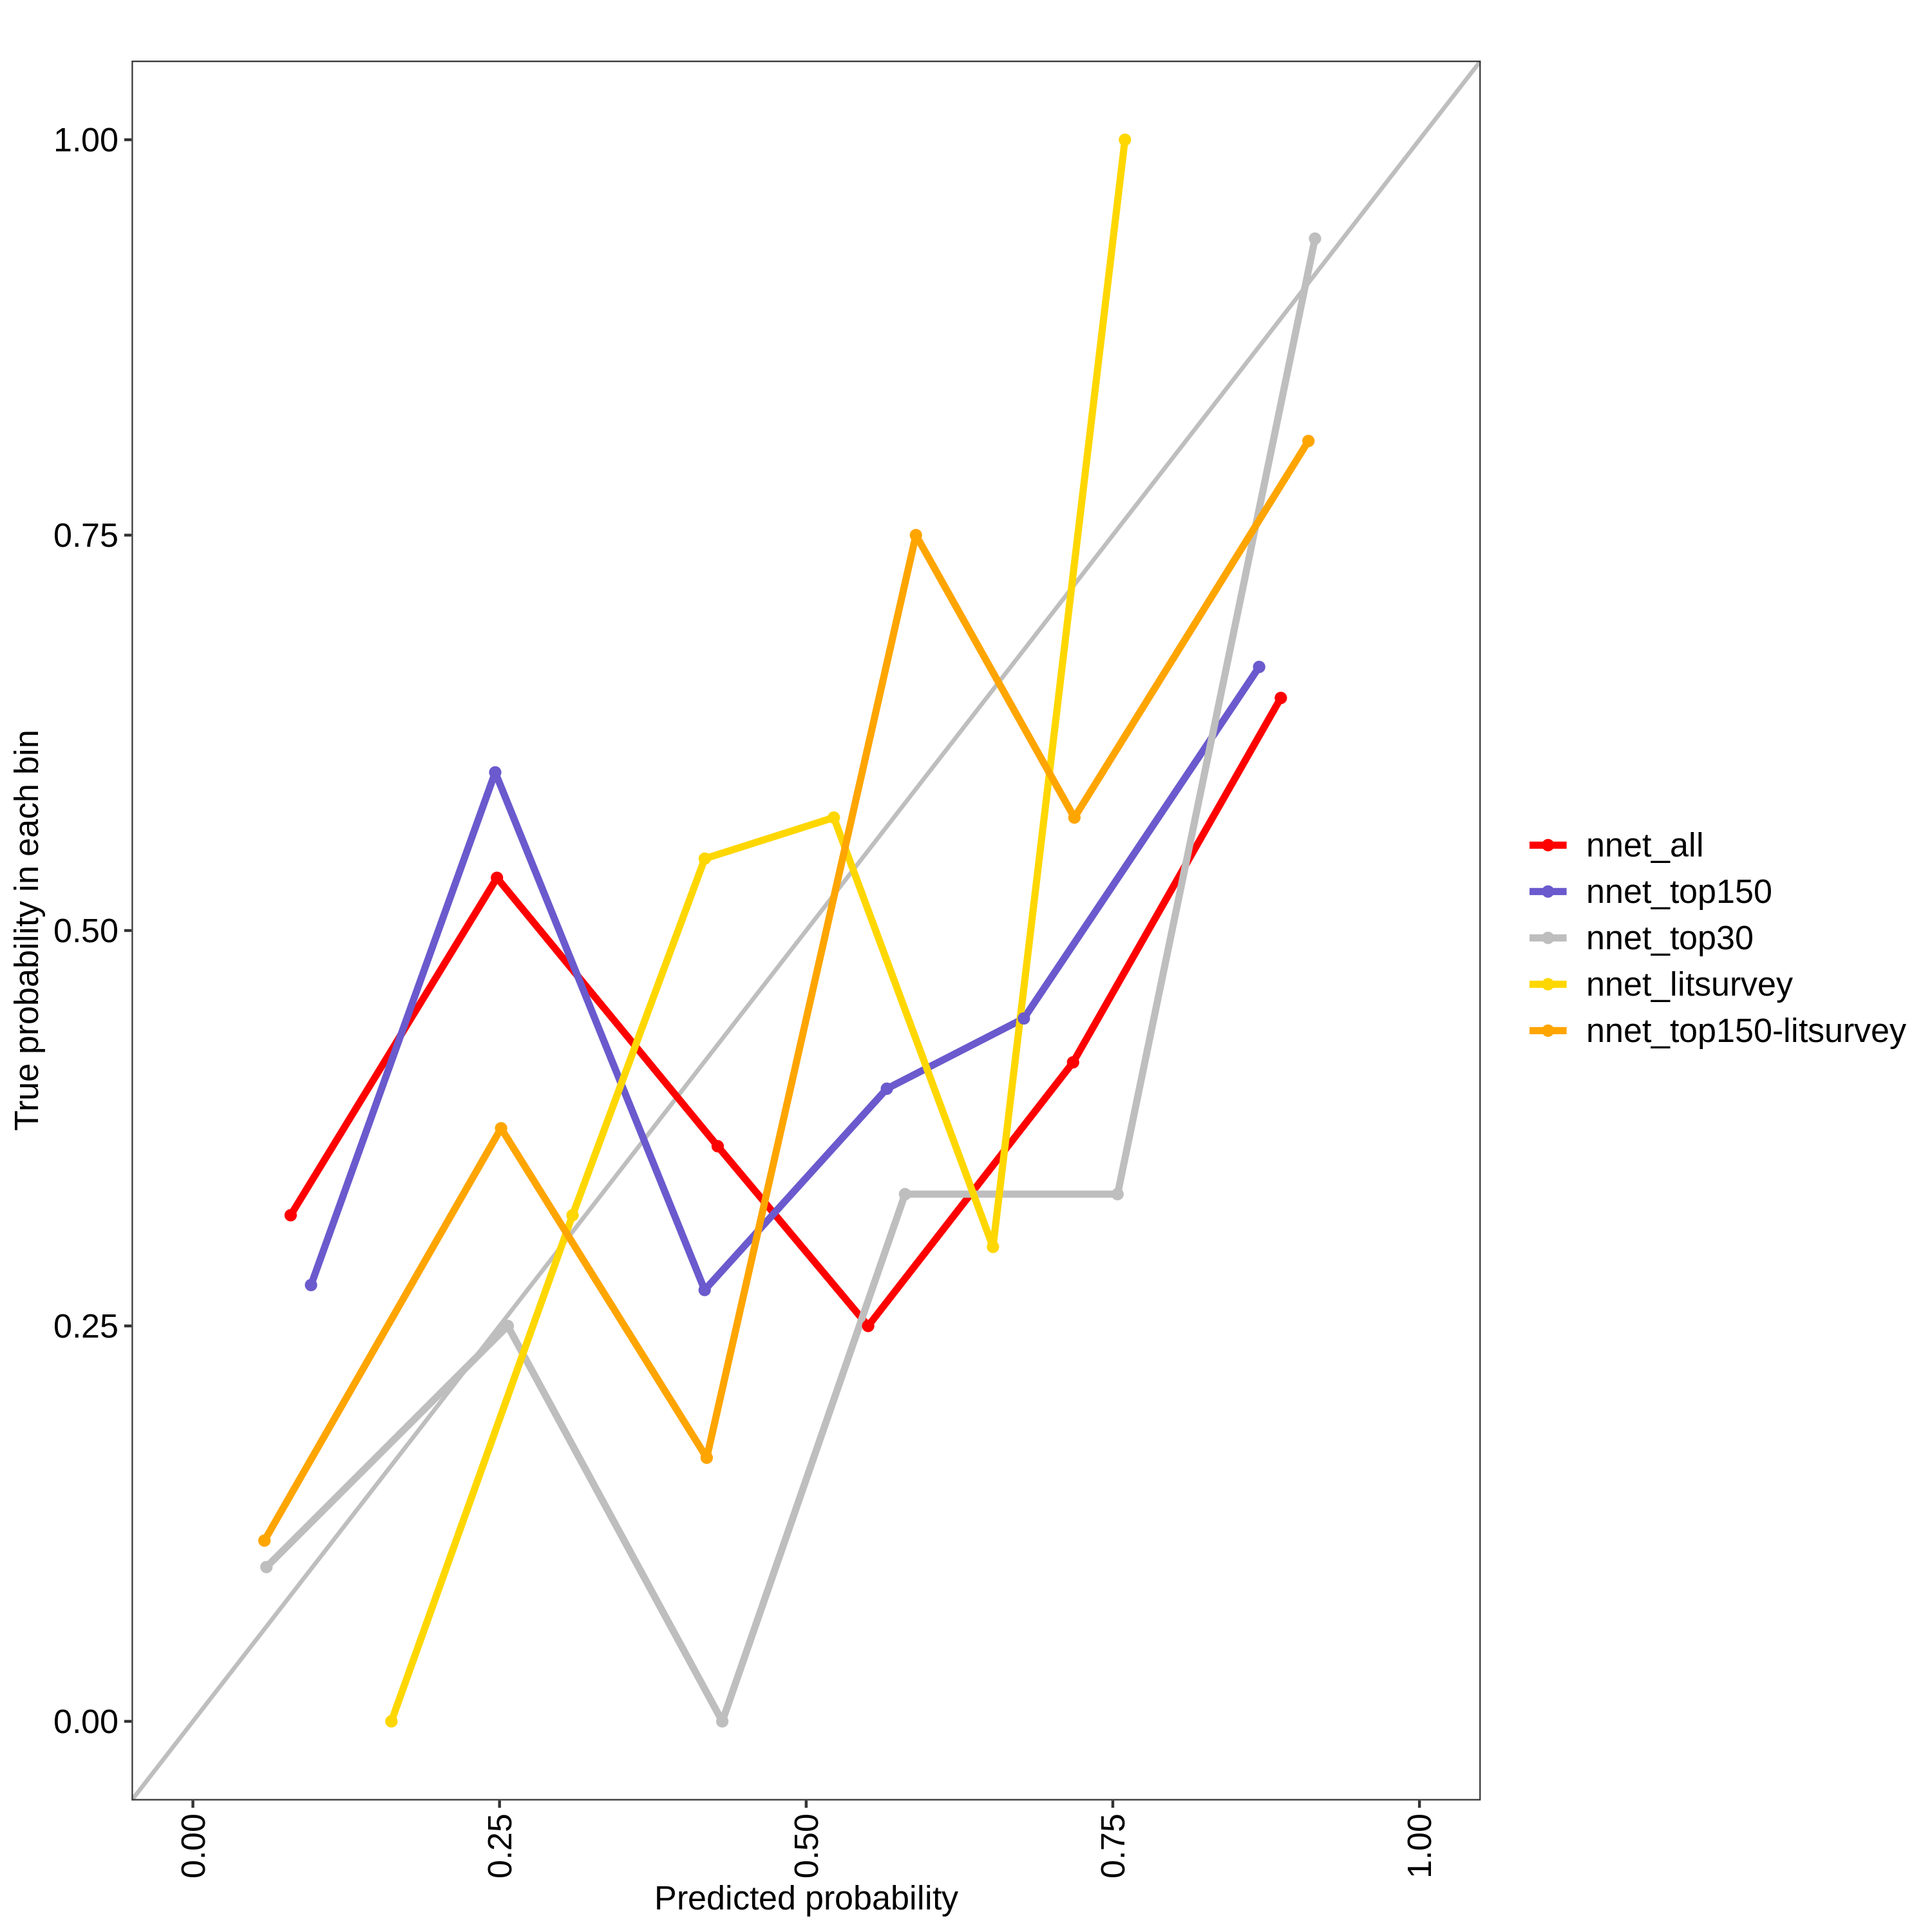

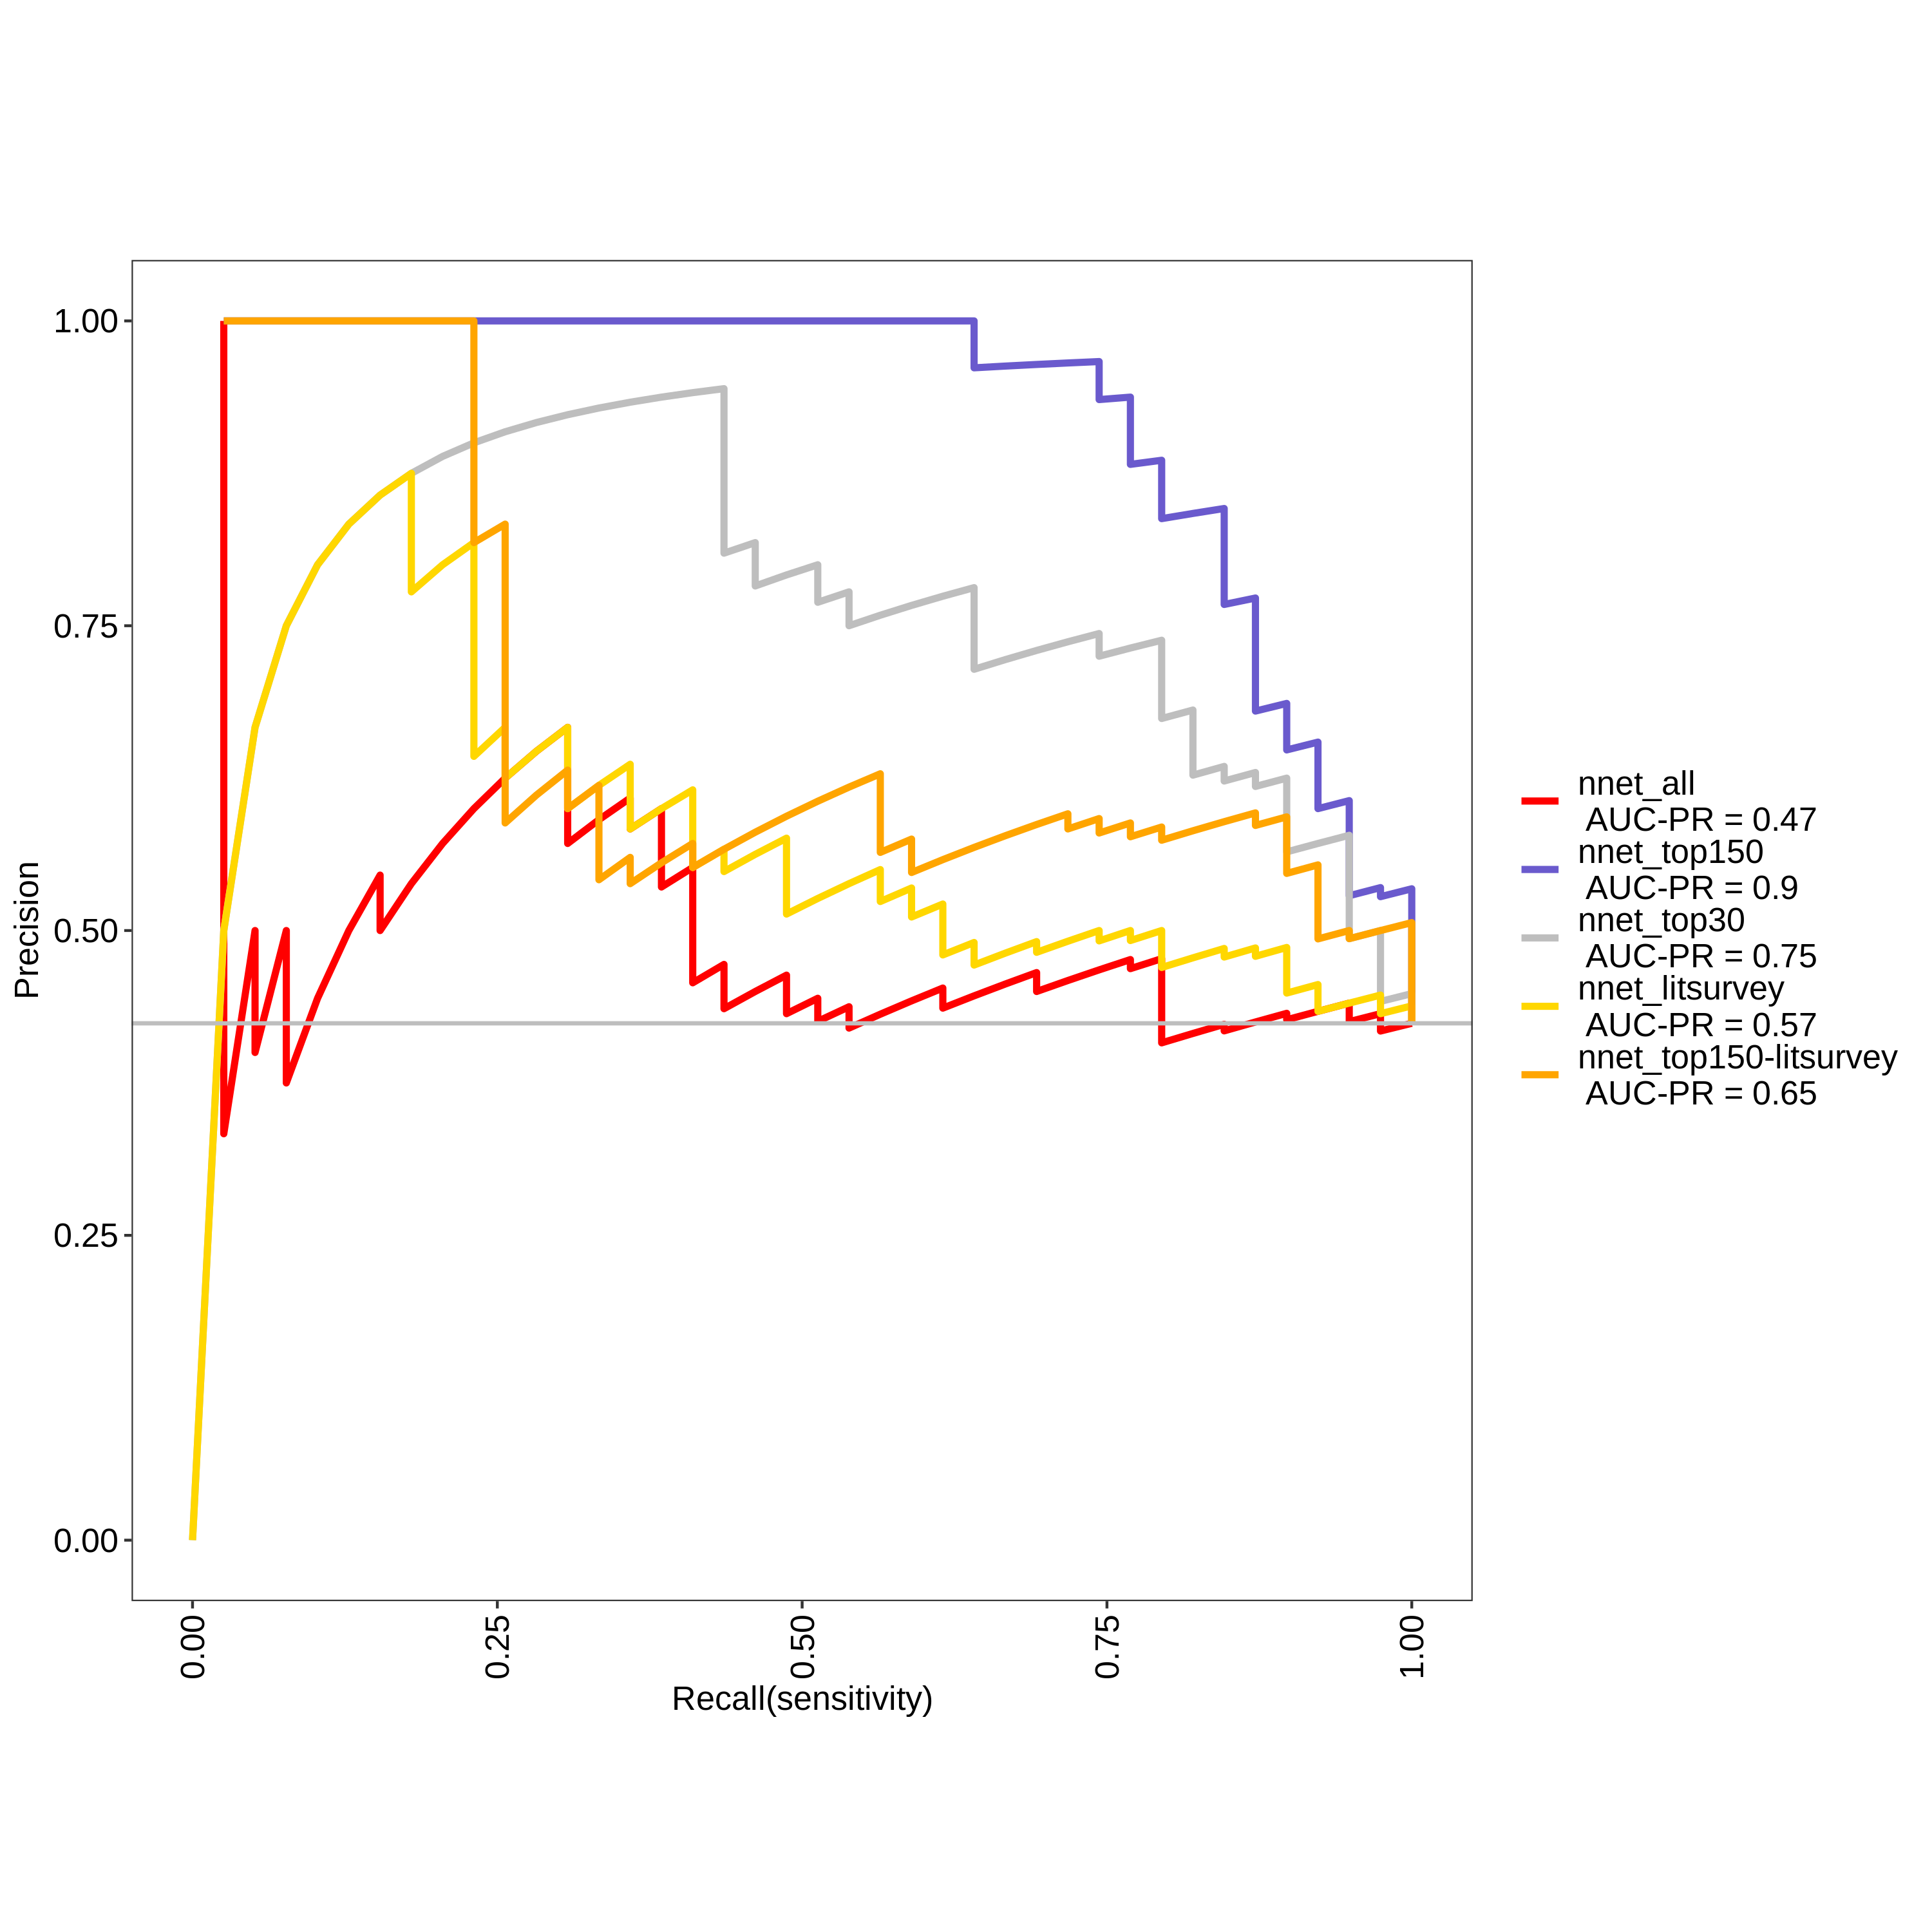

nnet_all Optimal Informedness = 0.195936139332366

nnet_top150 Optimal Informedness = 0.732946298984035

nnet_top30 Optimal Informedness = 0.587324625060474

nnet_litsurvey Optimal Informedness = 0.22447992259313

nnet_top150-litsurvey Optimal Informedness = 0.444605708756652

nnet_all AUC-ROC = 0.56

nnet_top150 AUC-ROC = 0.92

nnet_top30 AUC-ROC = 0.83

nnet_litsurvey AUC-ROC = 0.65

nnet_top150-litsurvey AUC-ROC = 0.74



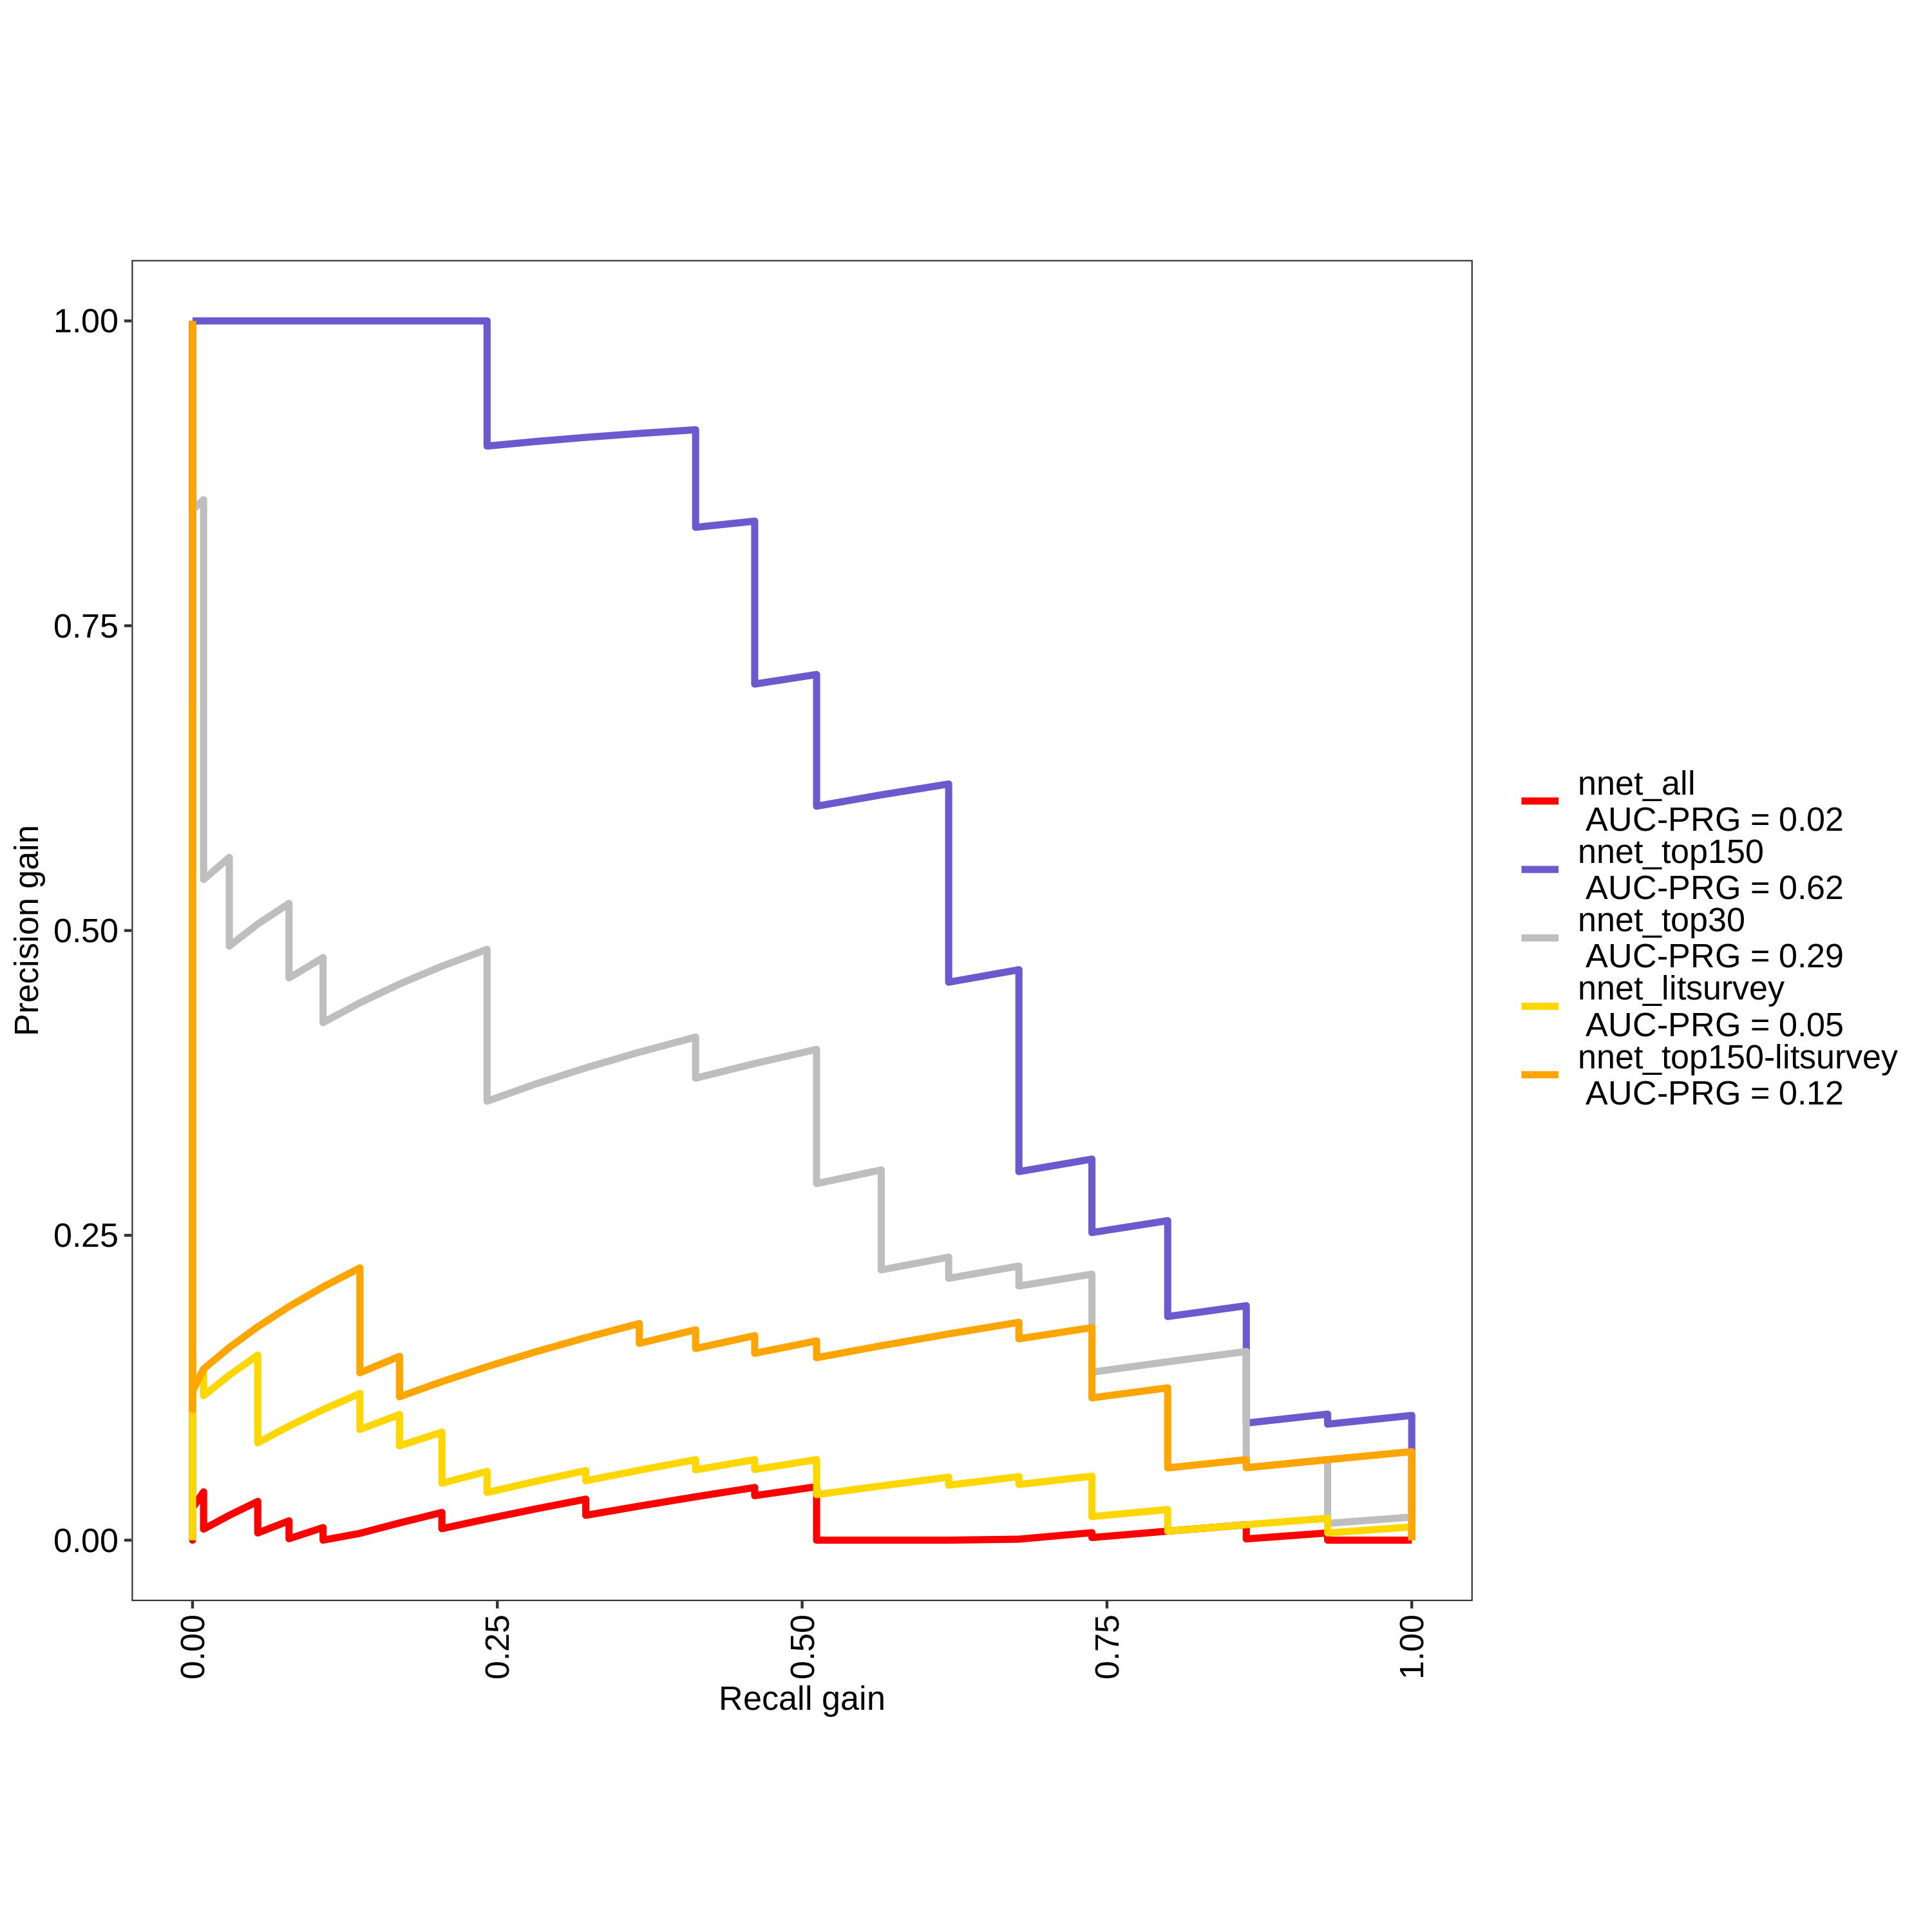

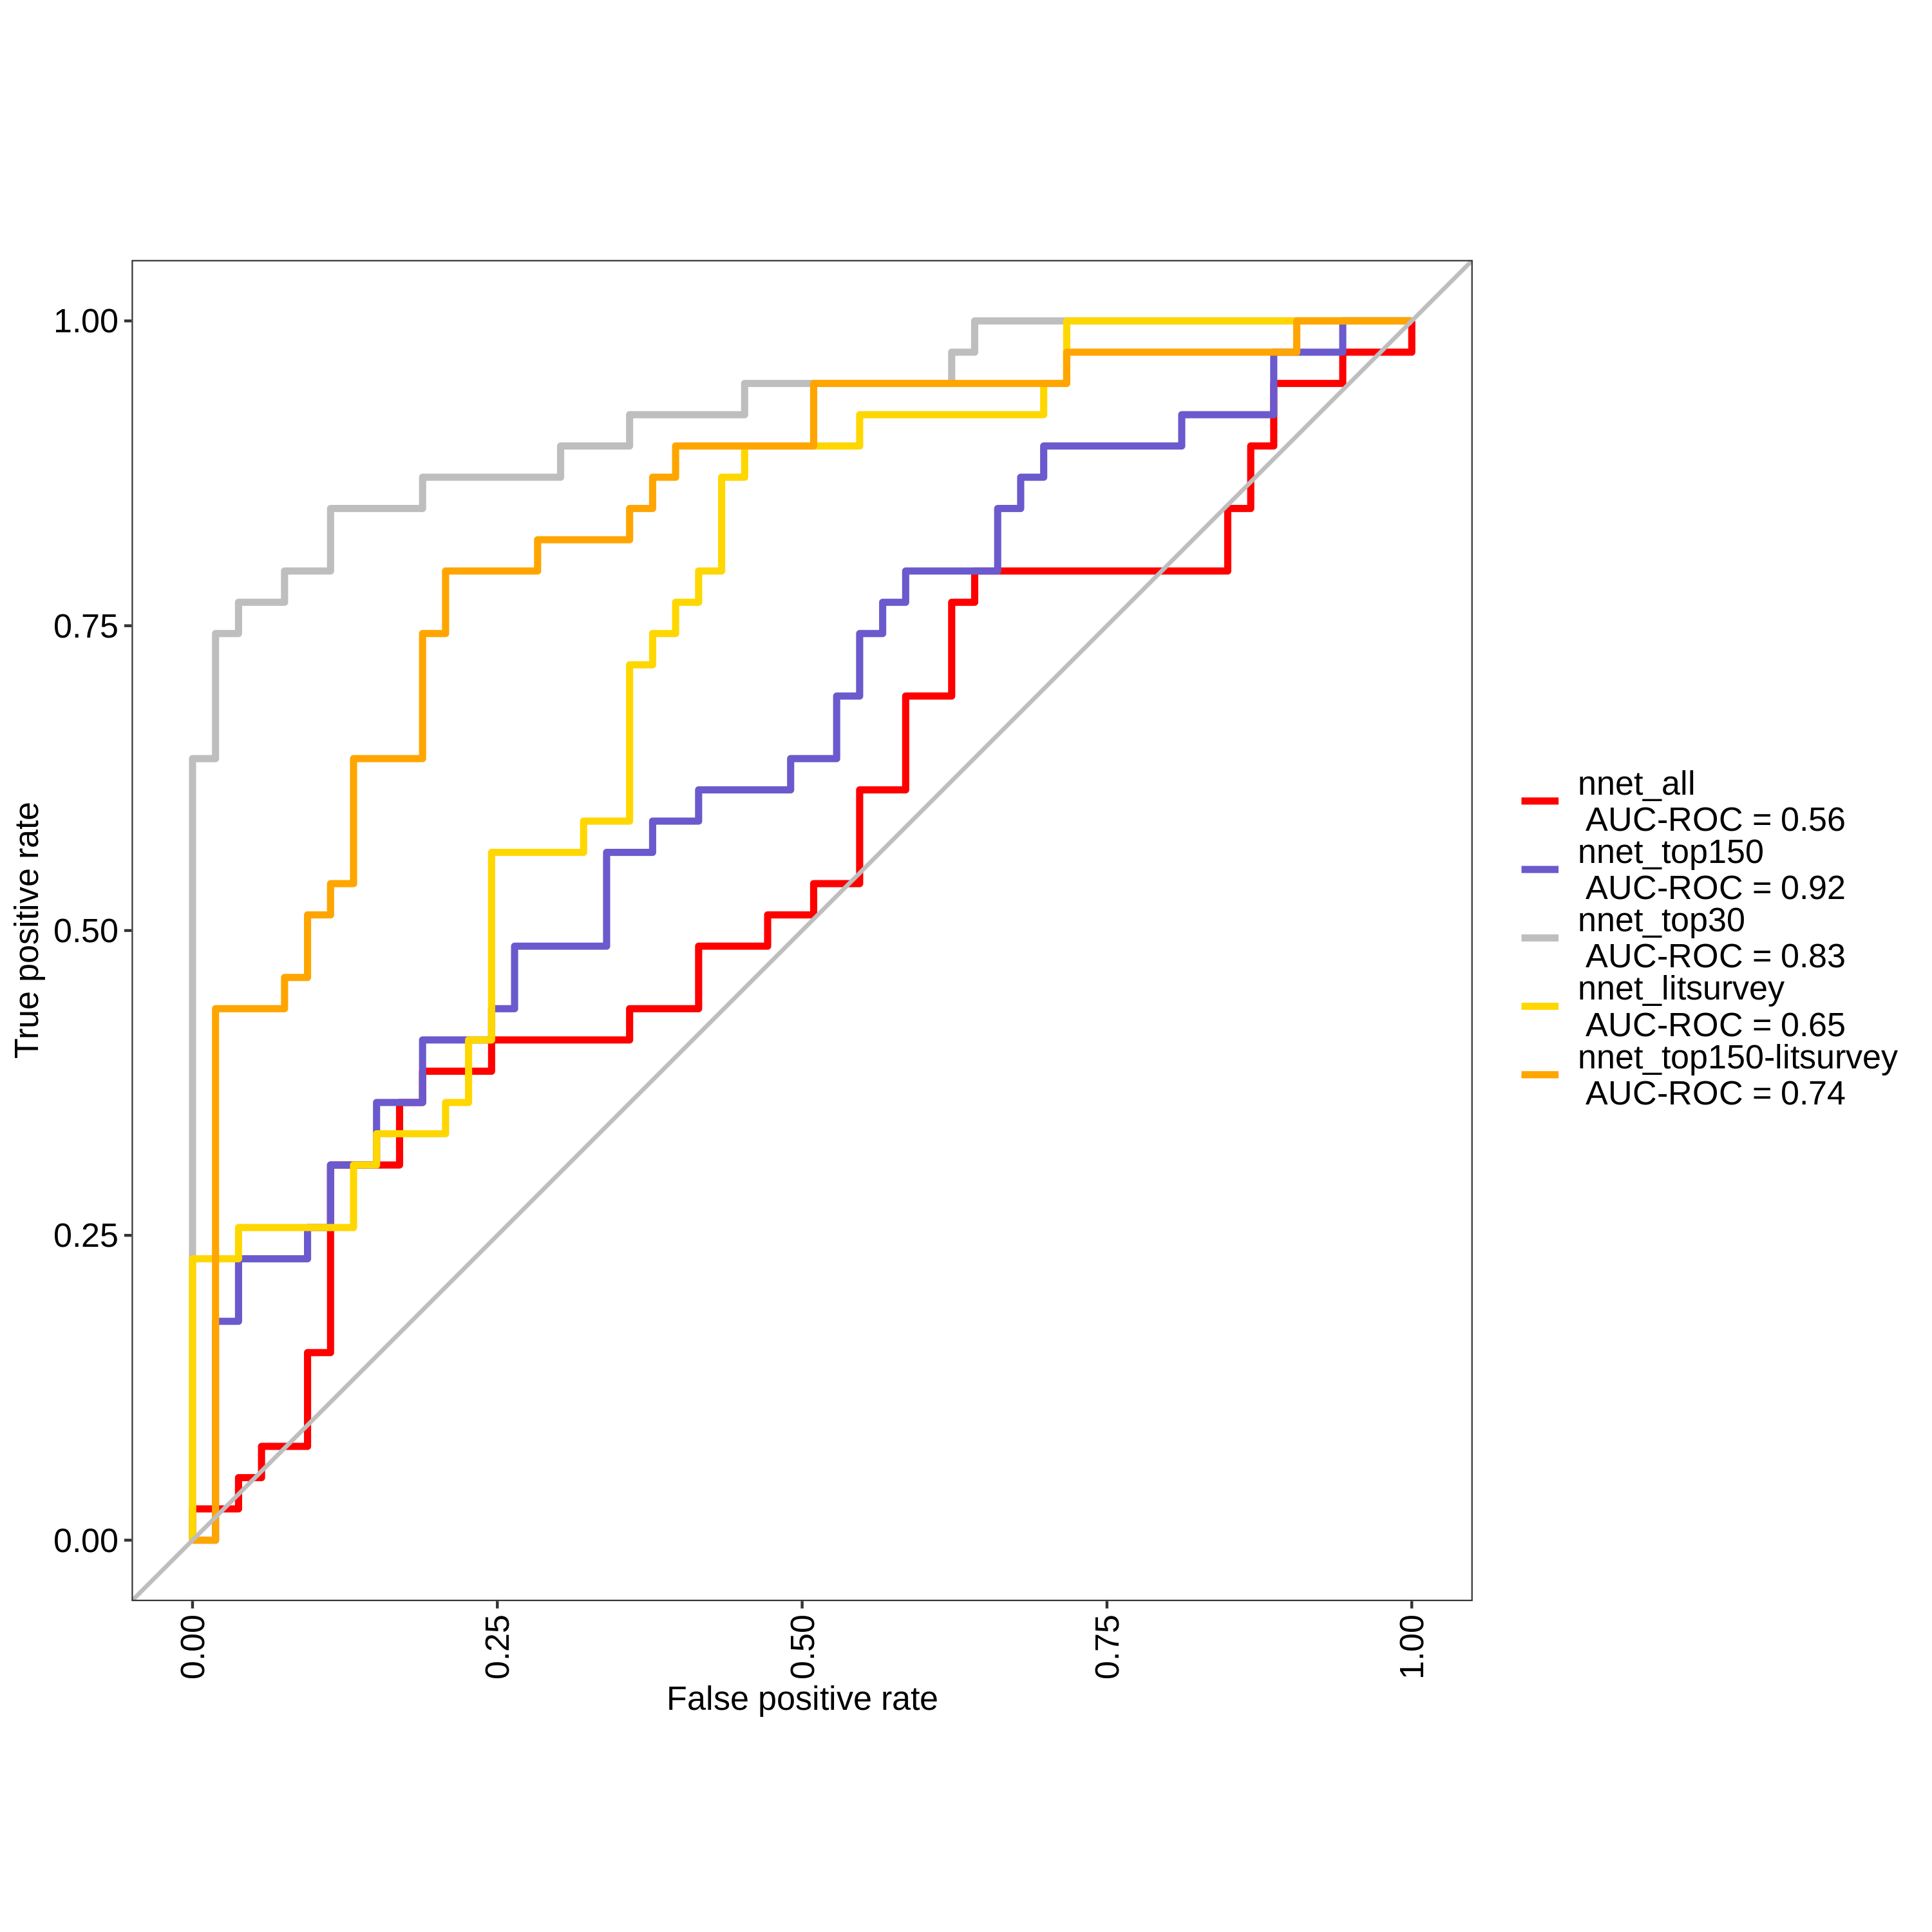

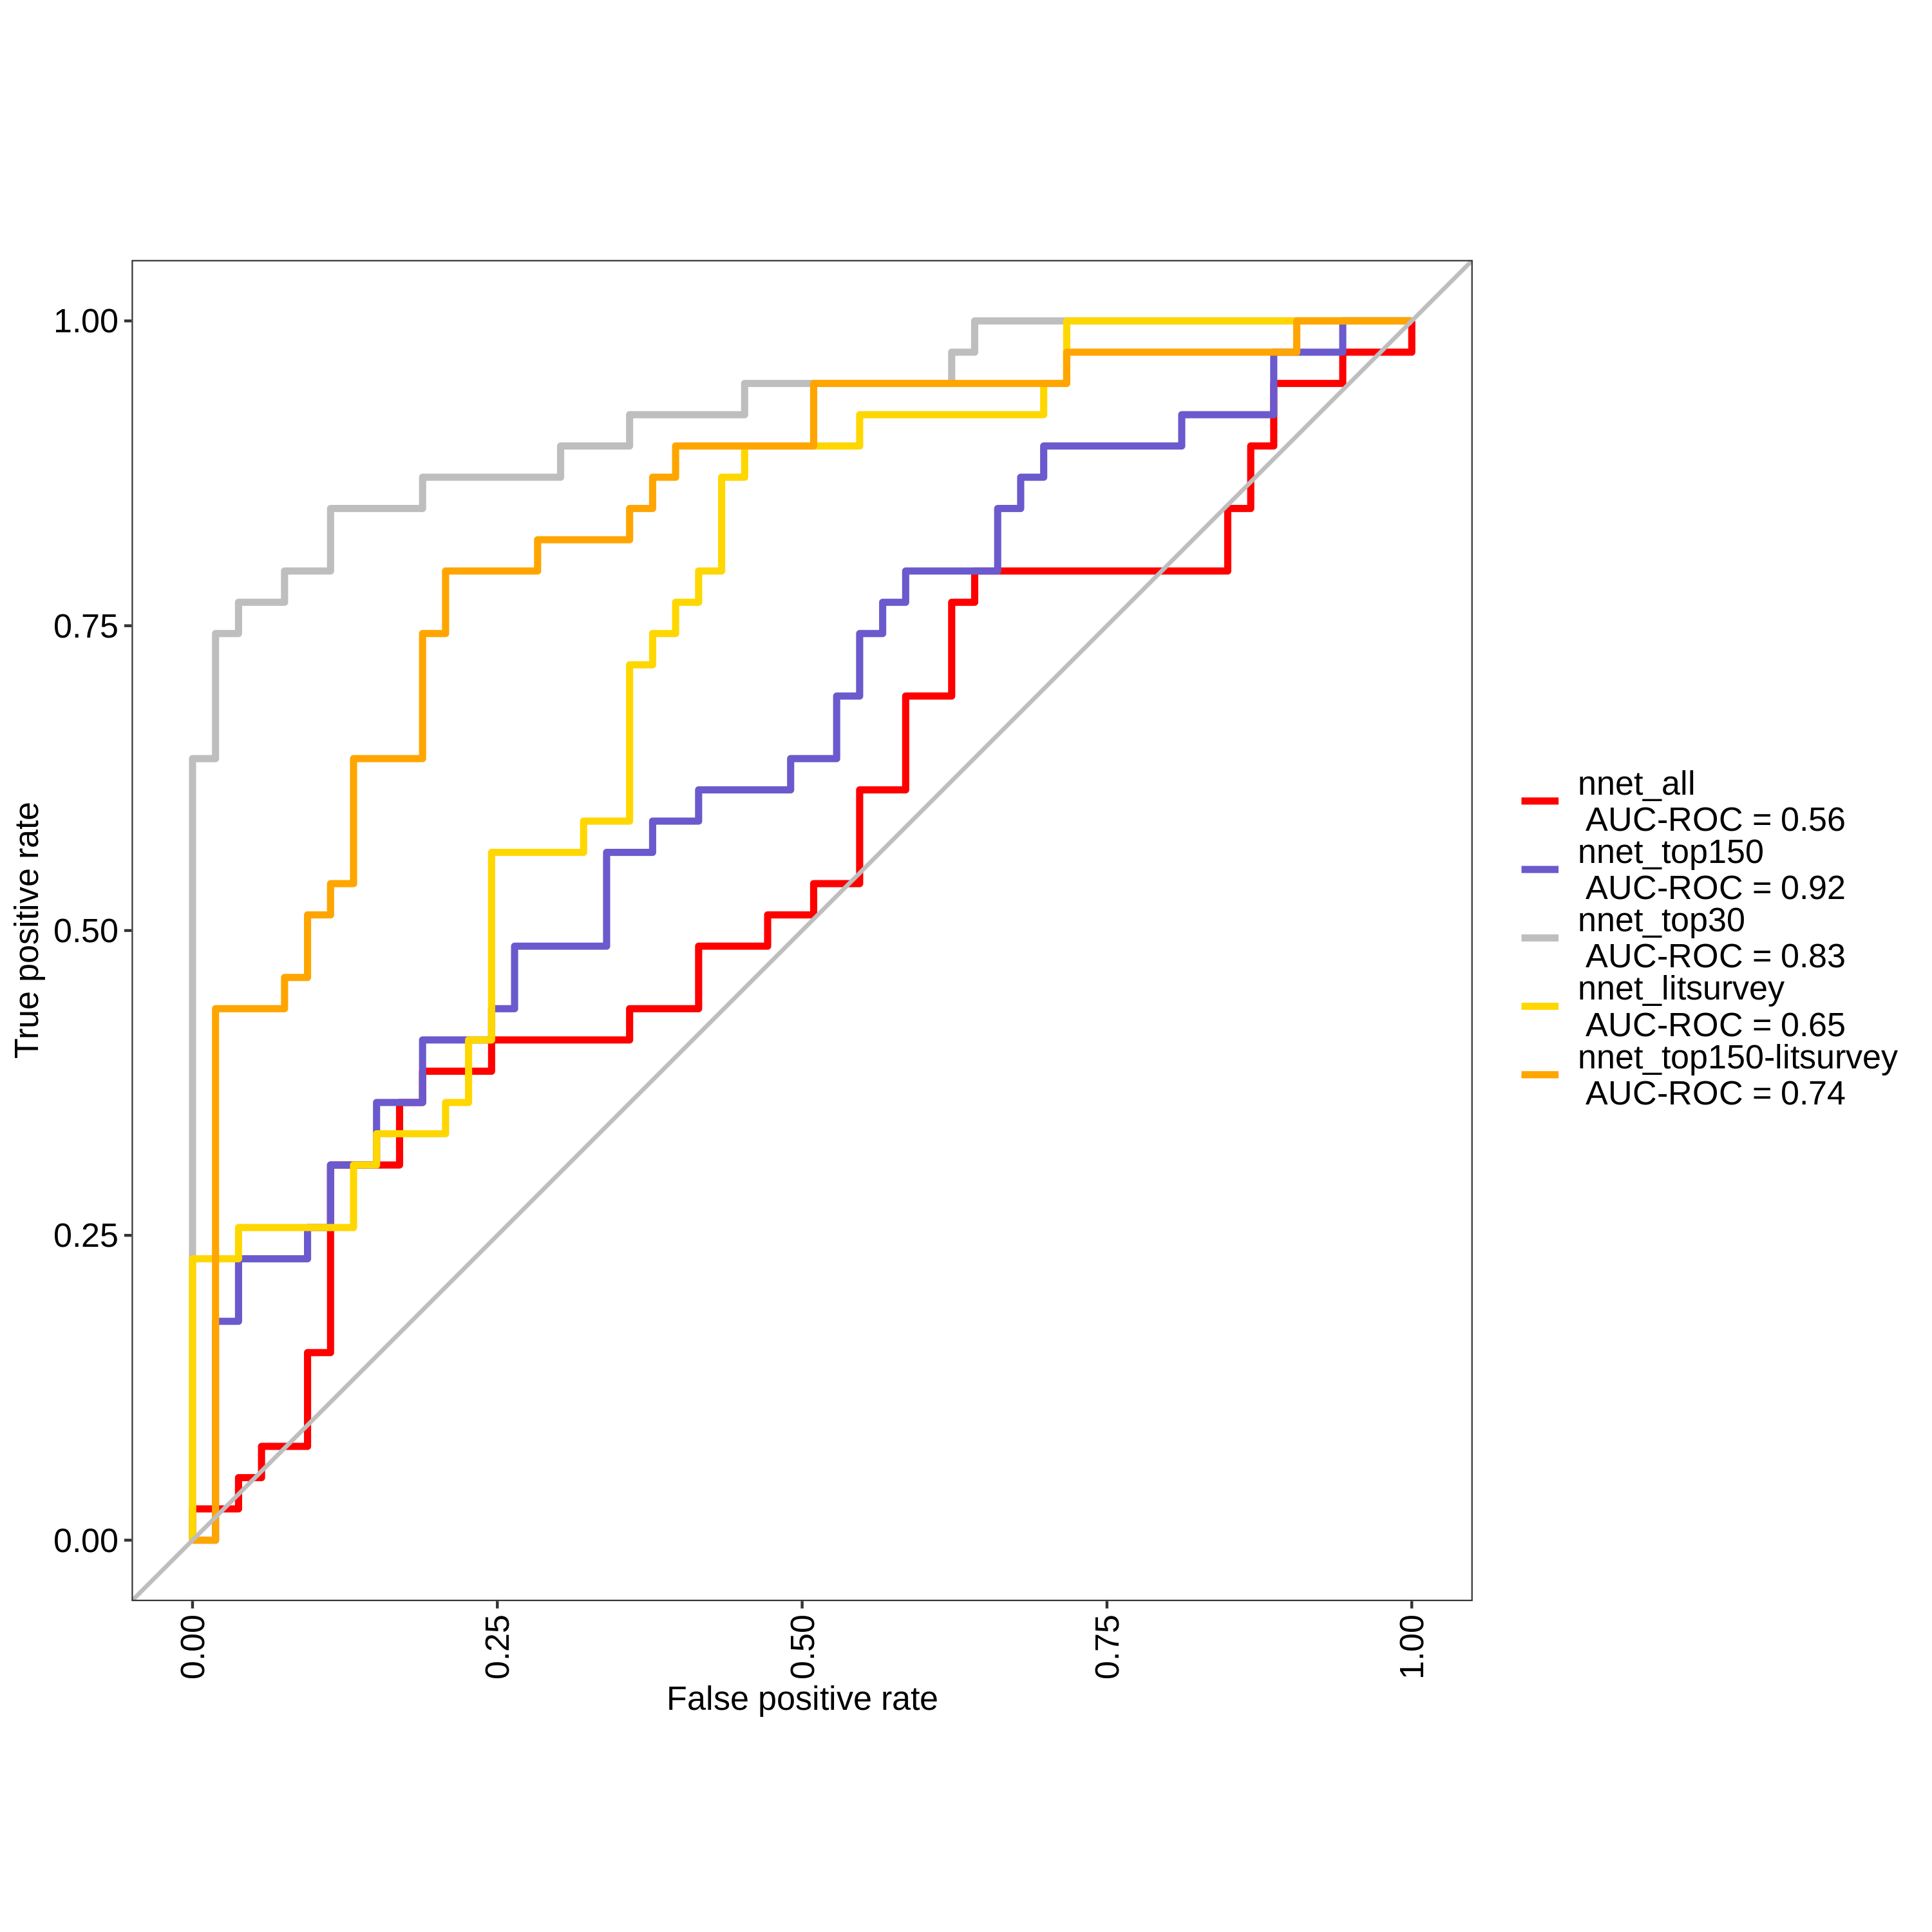

In [167]:
inp_top200_nnet <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.200 >= 4, "Gene_ID"])],
              method="pcaNNet",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top50_nnet <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.50 >= 4, "Gene_ID"])],
              method="pcaNNet",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_litsurvey_nnet <- train(Response ~ ., data=mod_inp_mat[,c("Response", genes_lit_rawdata)],
              method="pcaNNet",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top200litsurvey_nnet <- train(Response ~ ., data=mod_inp_mat[,c("Response", top_genes_out)],
              method="pcaNNet",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

res_nnet <- evalm(list(inp_top200_nnet, inp_top50_nnet, inp_litsurvey_nnet, inp_top200litsurvey_nnet),
             gnames=c('pcannet_top200', 'pcannet_top50', 'pcannet_litsurvey', 'pcannet_top200-litsurvey'))
res_nnet$roc

## Gradient Boosting Machines (GBM)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3088            -nan     0.1000    0.0110
     2        1.2506            -nan     0.1000    0.0098
     3        1.2121            -nan     0.1000    0.0010
     4        1.1765            -nan     0.1000   -0.0084
     5        1.1468            -nan     0.1000   -0.0058
     6        1.1163            -nan     0.1000   -0.0089
     7        1.0897            -nan     0.1000   -0.0052
     8        1.0579            -nan     0.1000   -0.0033
     9        1.0254            -nan     0.1000   -0.0088
    10        1.0089            -nan     0.1000   -0.0138
    20        0.7770            -nan     0.1000   -0.0090
    40        0.4709            -nan     0.1000   -0.0063
    60        0.3096            -nan     0.1000   -0.0018
    80        0.1965            -nan     0.1000   -0.0018
   100        0.1204            -nan     0.1000   -0.0009
   120        0.0812            -nan     0.1000   -0.0010
   140        

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3078            -nan     0.1000    0.0126
     2        1.2768            -nan     0.1000   -0.0019
     3        1.2477            -nan     0.1000   -0.0051
     4        1.1933            -nan     0.1000    0.0187
     5        1.1327            -nan     0.1000    0.0125
     6        1.0862            -nan     0.1000    0.0116
     7        1.0530            -nan     0.1000    0.0024
     8        1.0122            -nan     0.1000    0.0061
     9        0.9809            -nan     0.1000   -0.0013
    10        0.9474            -nan     0.1000   -0.0047
    20        0.7207            -nan     0.1000   -0.0031
    40        0.4341            -nan     0.1000   -0.0008
    60        0.2732            -nan     0.1000   -0.0004
    80        0.1737            -nan     0.1000   -0.0009
   100        0.1192            -nan     0.1000    0.0003
   120        0.0788            -nan     0.1000   -0.0004
   140        

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.2961            -nan     0.1000    0.0230
     2        1.2279            -nan     0.1000    0.0225
     3        1.1721            -nan     0.1000    0.0203
     4        1.1262            -nan     0.1000    0.0114
     5        1.0881            -nan     0.1000    0.0007
     6        1.0430            -nan     0.1000    0.0101
     7        0.9998            -nan     0.1000    0.0185
     8        0.9719            -nan     0.1000    0.0047
     9        0.9408            -nan     0.1000    0.0116
    10        0.9113            -nan     0.1000    0.0112
    20        0.6883            -nan     0.1000   -0.0022
    40        0.4509            -nan     0.1000   -0.0008
    60        0.3173            -nan     0.1000   -0.0021
    80        0.2473            -nan     0.1000   -0.0021
   100        0.2027            -nan     0.1000   -0.0032
   120        0.1607            -nan     0.1000   -0.0023
   140        

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3242            -nan     0.1000   -0.0001
     2        1.3010            -nan     0.1000    0.0012
     3        1.2683            -nan     0.1000    0.0058
     4        1.2478            -nan     0.1000   -0.0039
     5        1.2241            -nan     0.1000   -0.0012
     6        1.2129            -nan     0.1000   -0.0114
     7        1.1988            -nan     0.1000   -0.0038
     8        1.1813            -nan     0.1000    0.0002
     9        1.1638            -nan     0.1000    0.0036
    10        1.1445            -nan     0.1000   -0.0033
    20        1.0152            -nan     0.1000   -0.0041
    40        0.8262            -nan     0.1000   -0.0045
    60        0.6661            -nan     0.1000   -0.0016
    80        0.5664            -nan     0.1000   -0.0019
   100        0.4747            -nan     0.1000   -0.0015
   120        0.4087            -nan     0.1000   -0.0051
   140        

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3488            -nan     0.1000    0.0003
     2        1.3067            -nan     0.1000    0.0033
     3        1.2801            -nan     0.1000    0.0075
     4        1.2456            -nan     0.1000    0.0125
     5        1.2364            -nan     0.1000    0.0021
     6        1.2177            -nan     0.1000   -0.0073
     7        1.2089            -nan     0.1000   -0.0007
     8        1.1994            -nan     0.1000   -0.0007
     9        1.1864            -nan     0.1000   -0.0077
    10        1.1698            -nan     0.1000    0.0052
    20        1.1028            -nan     0.1000    0.0003
    40        1.0346            -nan     0.1000   -0.0134
    60        0.9740            -nan     0.1000   -0.0096
    80        0.9404            -nan     0.1000   -0.0098
   100        0.9008            -nan     0.1000   -0.0006
   120        0.8708            -nan     0.1000   -0.0007
   140        

***MLeval: Machine Learning Model Evaluation***

Input: caret train function object

Averaging probs.

Group 1 type: repeatedcv

Group 2 type: repeatedcv

Group 3 type: repeatedcv

Group 4 type: repeatedcv

Group 5 type: repeatedcv

Observations: 460

Number of groups: 5

Observations per group: 92

Positive: Y

Negative: N

Group: gbm_all

Positive: 39

Negative: 53

Group: gbm_top150

Positive: 39

Negative: 53

Group: gbm_top30

Positive: 39

Negative: 53

Group: gbm_litsurvey

Positive: 39

Negative: 53

Group: gbm_top150-litsurvey

Positive: 39

Negative: 53

***Performance Metrics***



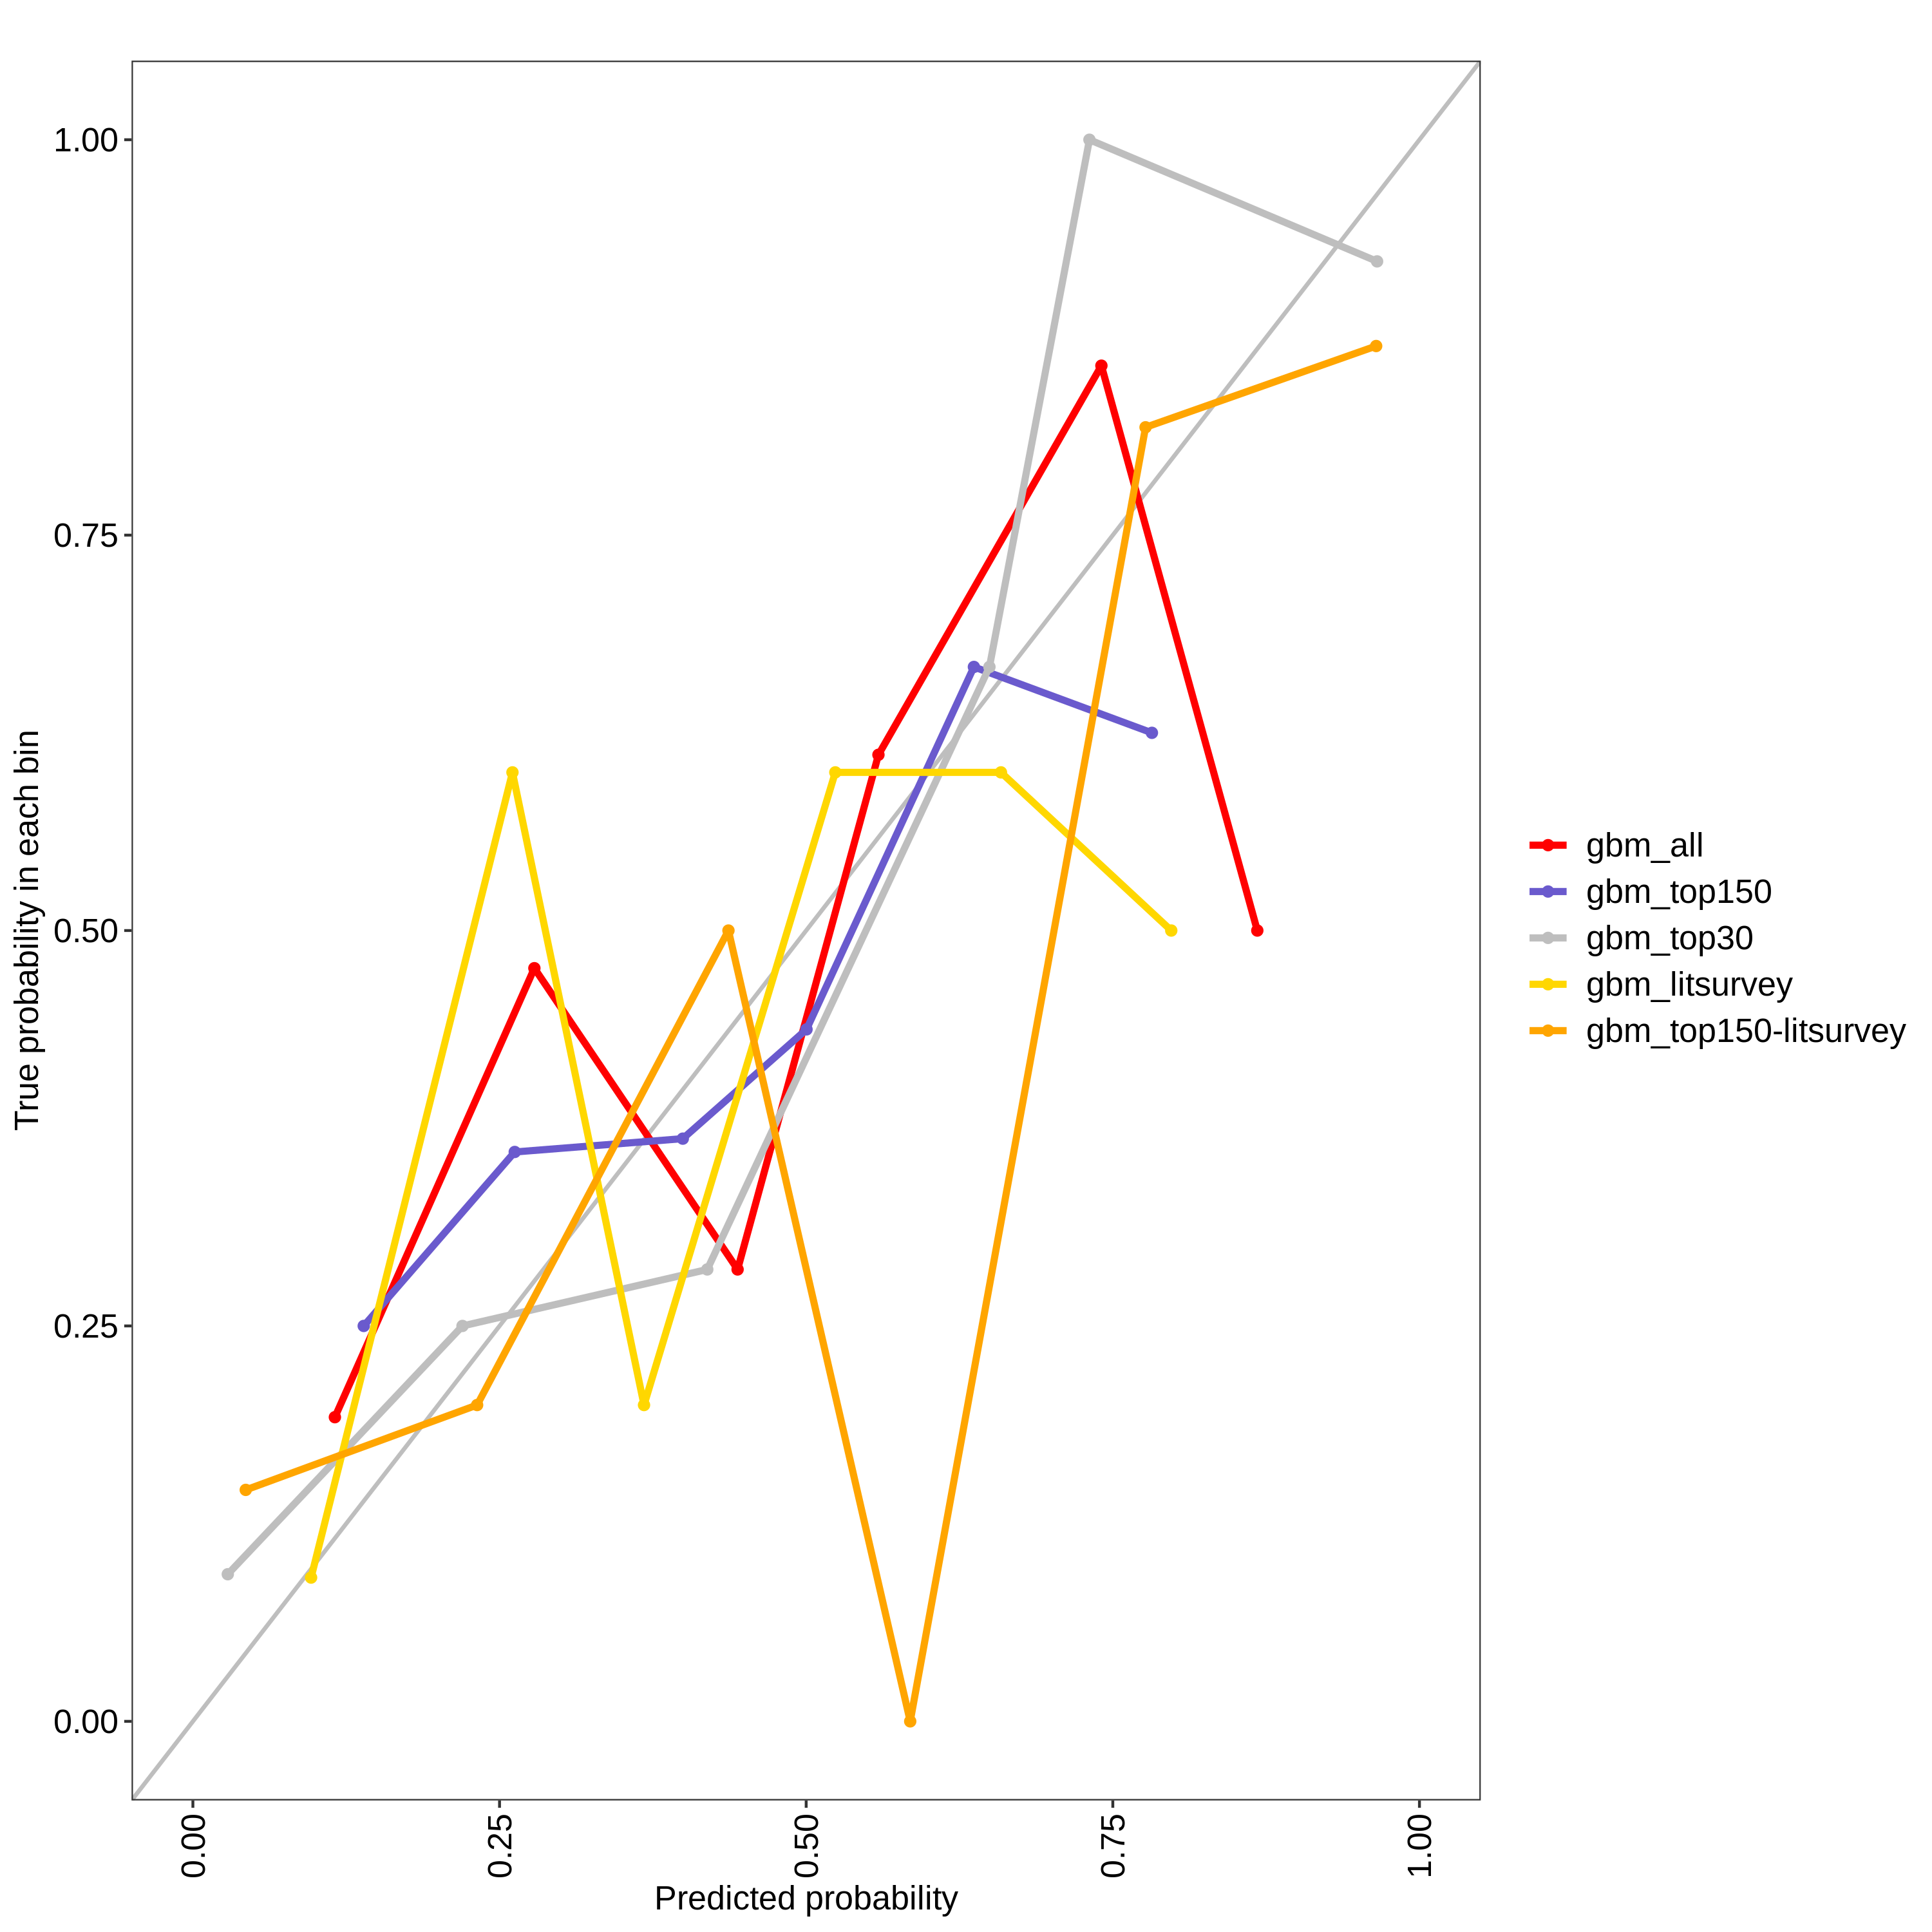

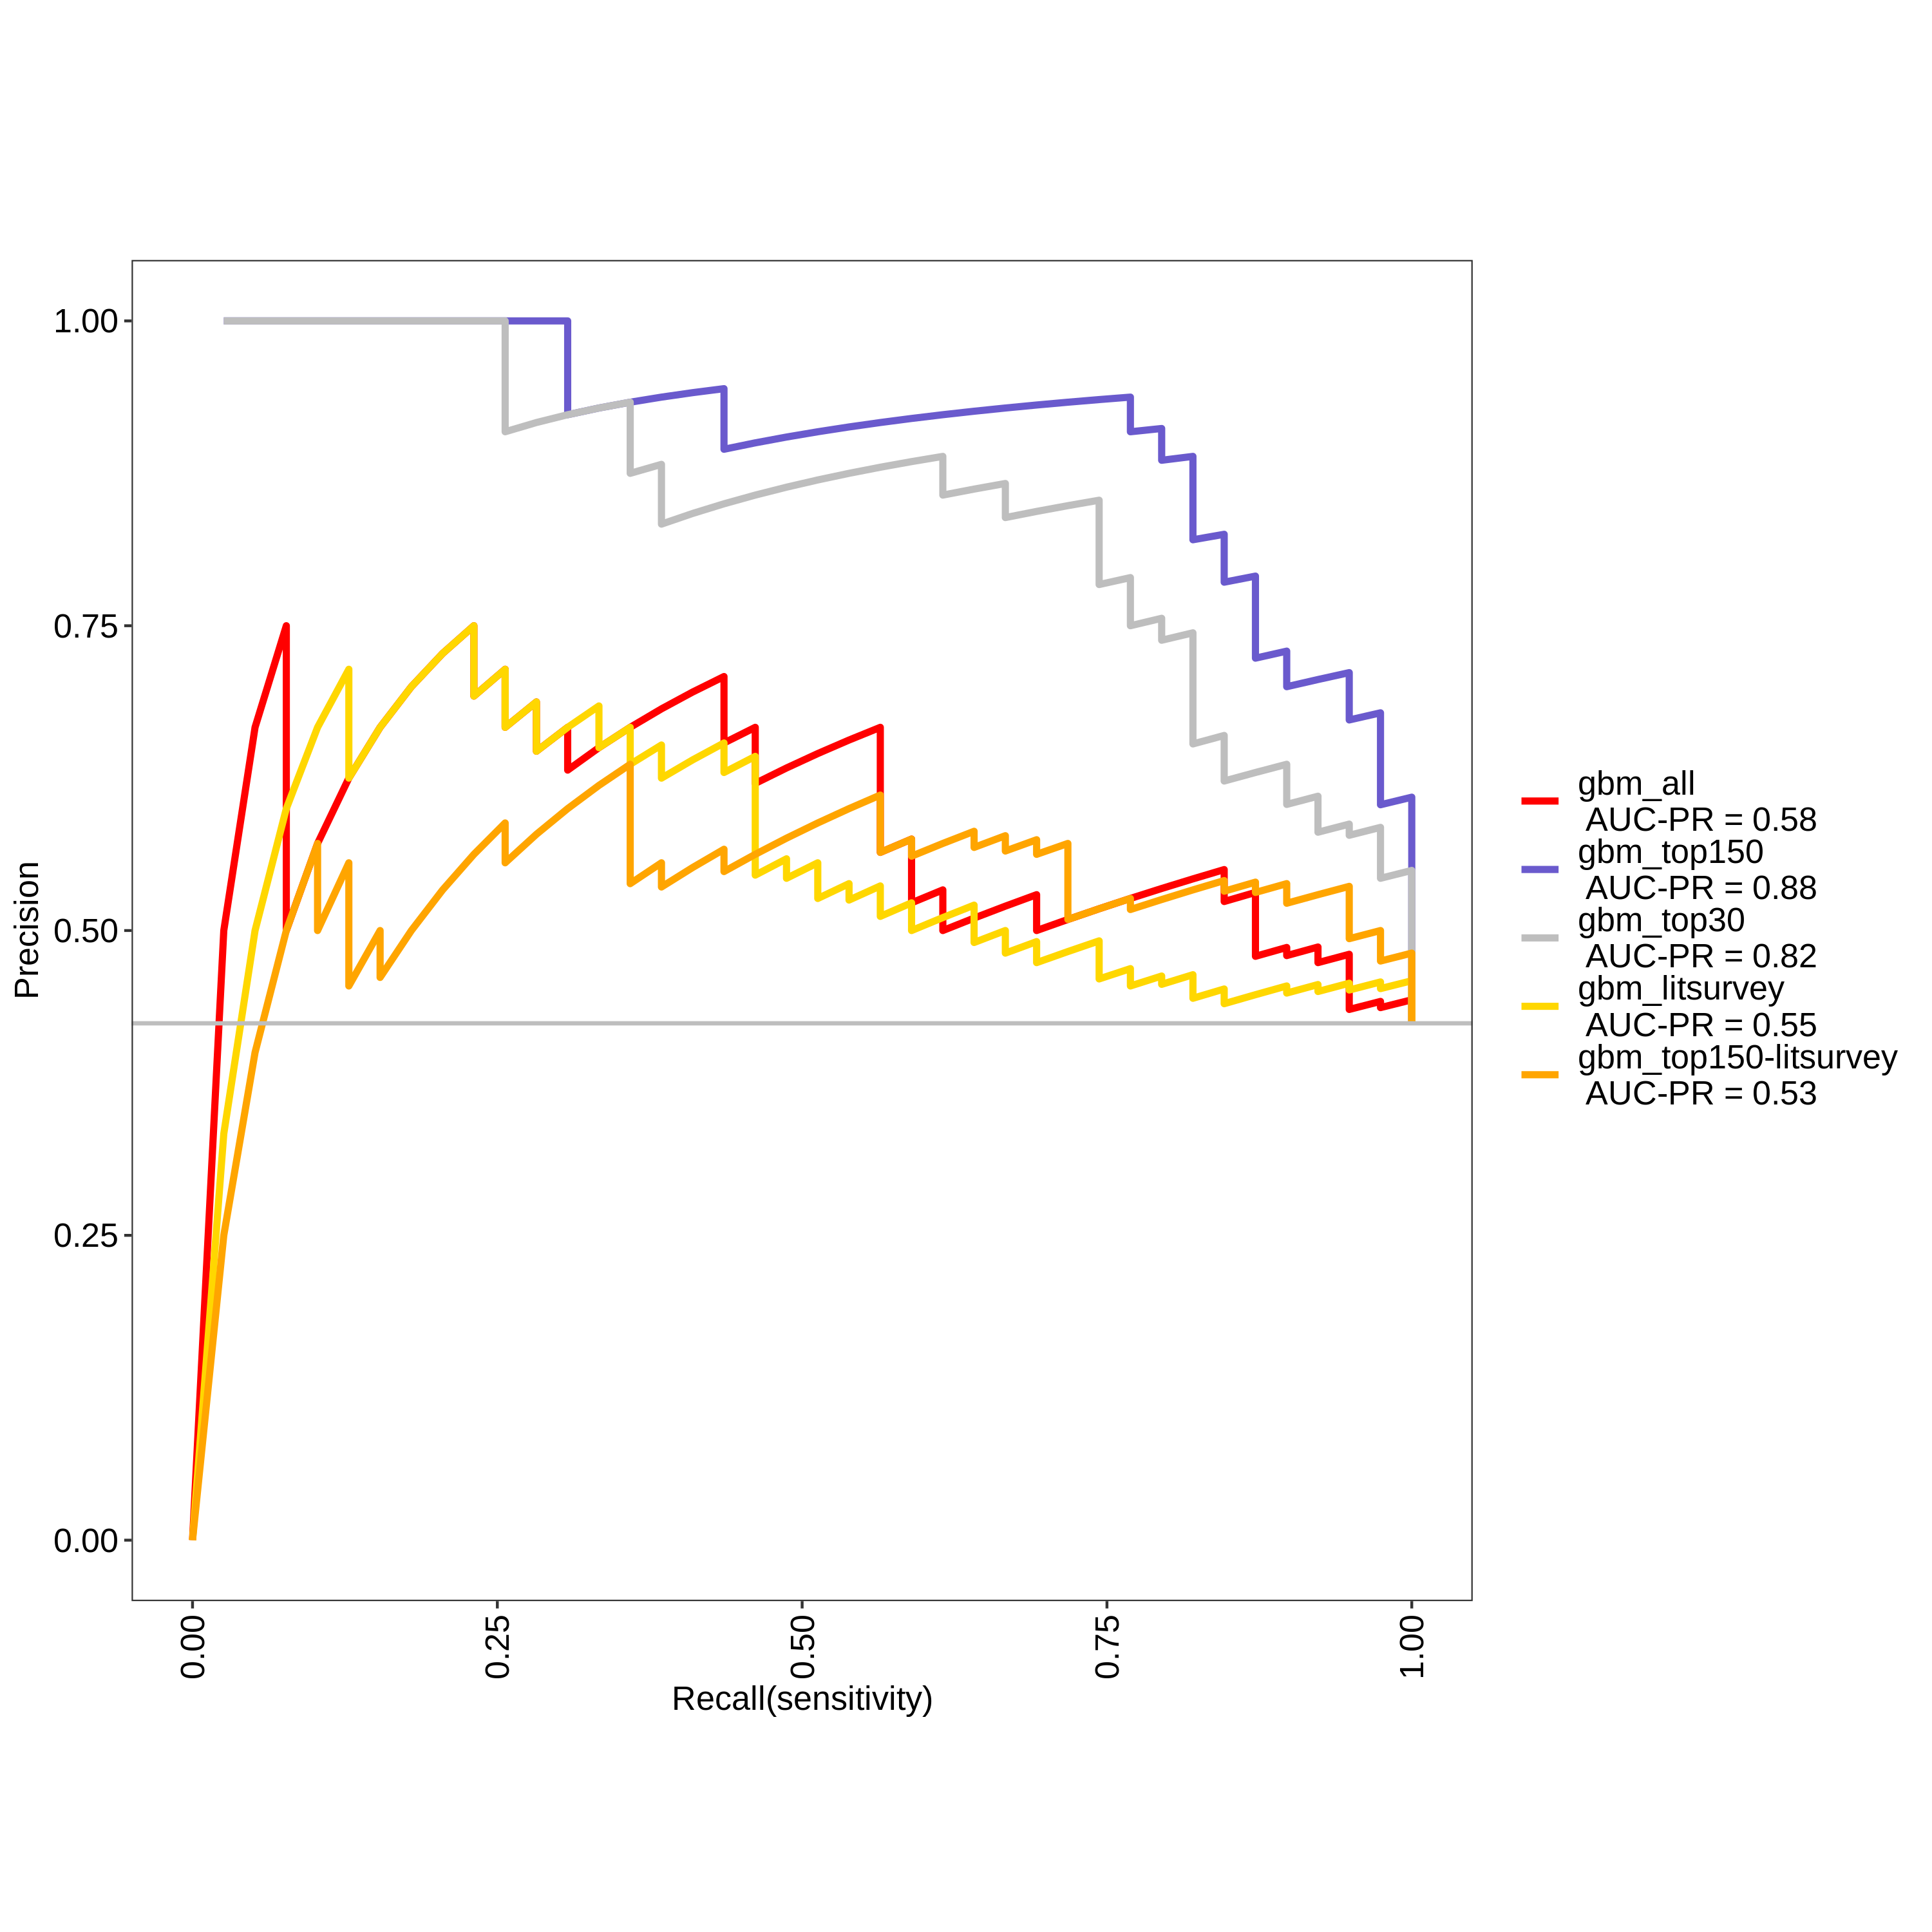

gbm_all Optimal Informedness = 0.356555394291243

gbm_top150 Optimal Informedness = 0.745041122399613

gbm_top30 Optimal Informedness = 0.649250120948234

gbm_litsurvey Optimal Informedness = 0.272859216255443

gbm_top150-litsurvey Optimal Informedness = 0.344944363812288

gbm_all AUC-ROC = 0.69

gbm_top150 AUC-ROC = 0.93

gbm_top30 AUC-ROC = 0.88

gbm_litsurvey AUC-ROC = 0.64

gbm_top150-litsurvey AUC-ROC = 0.69



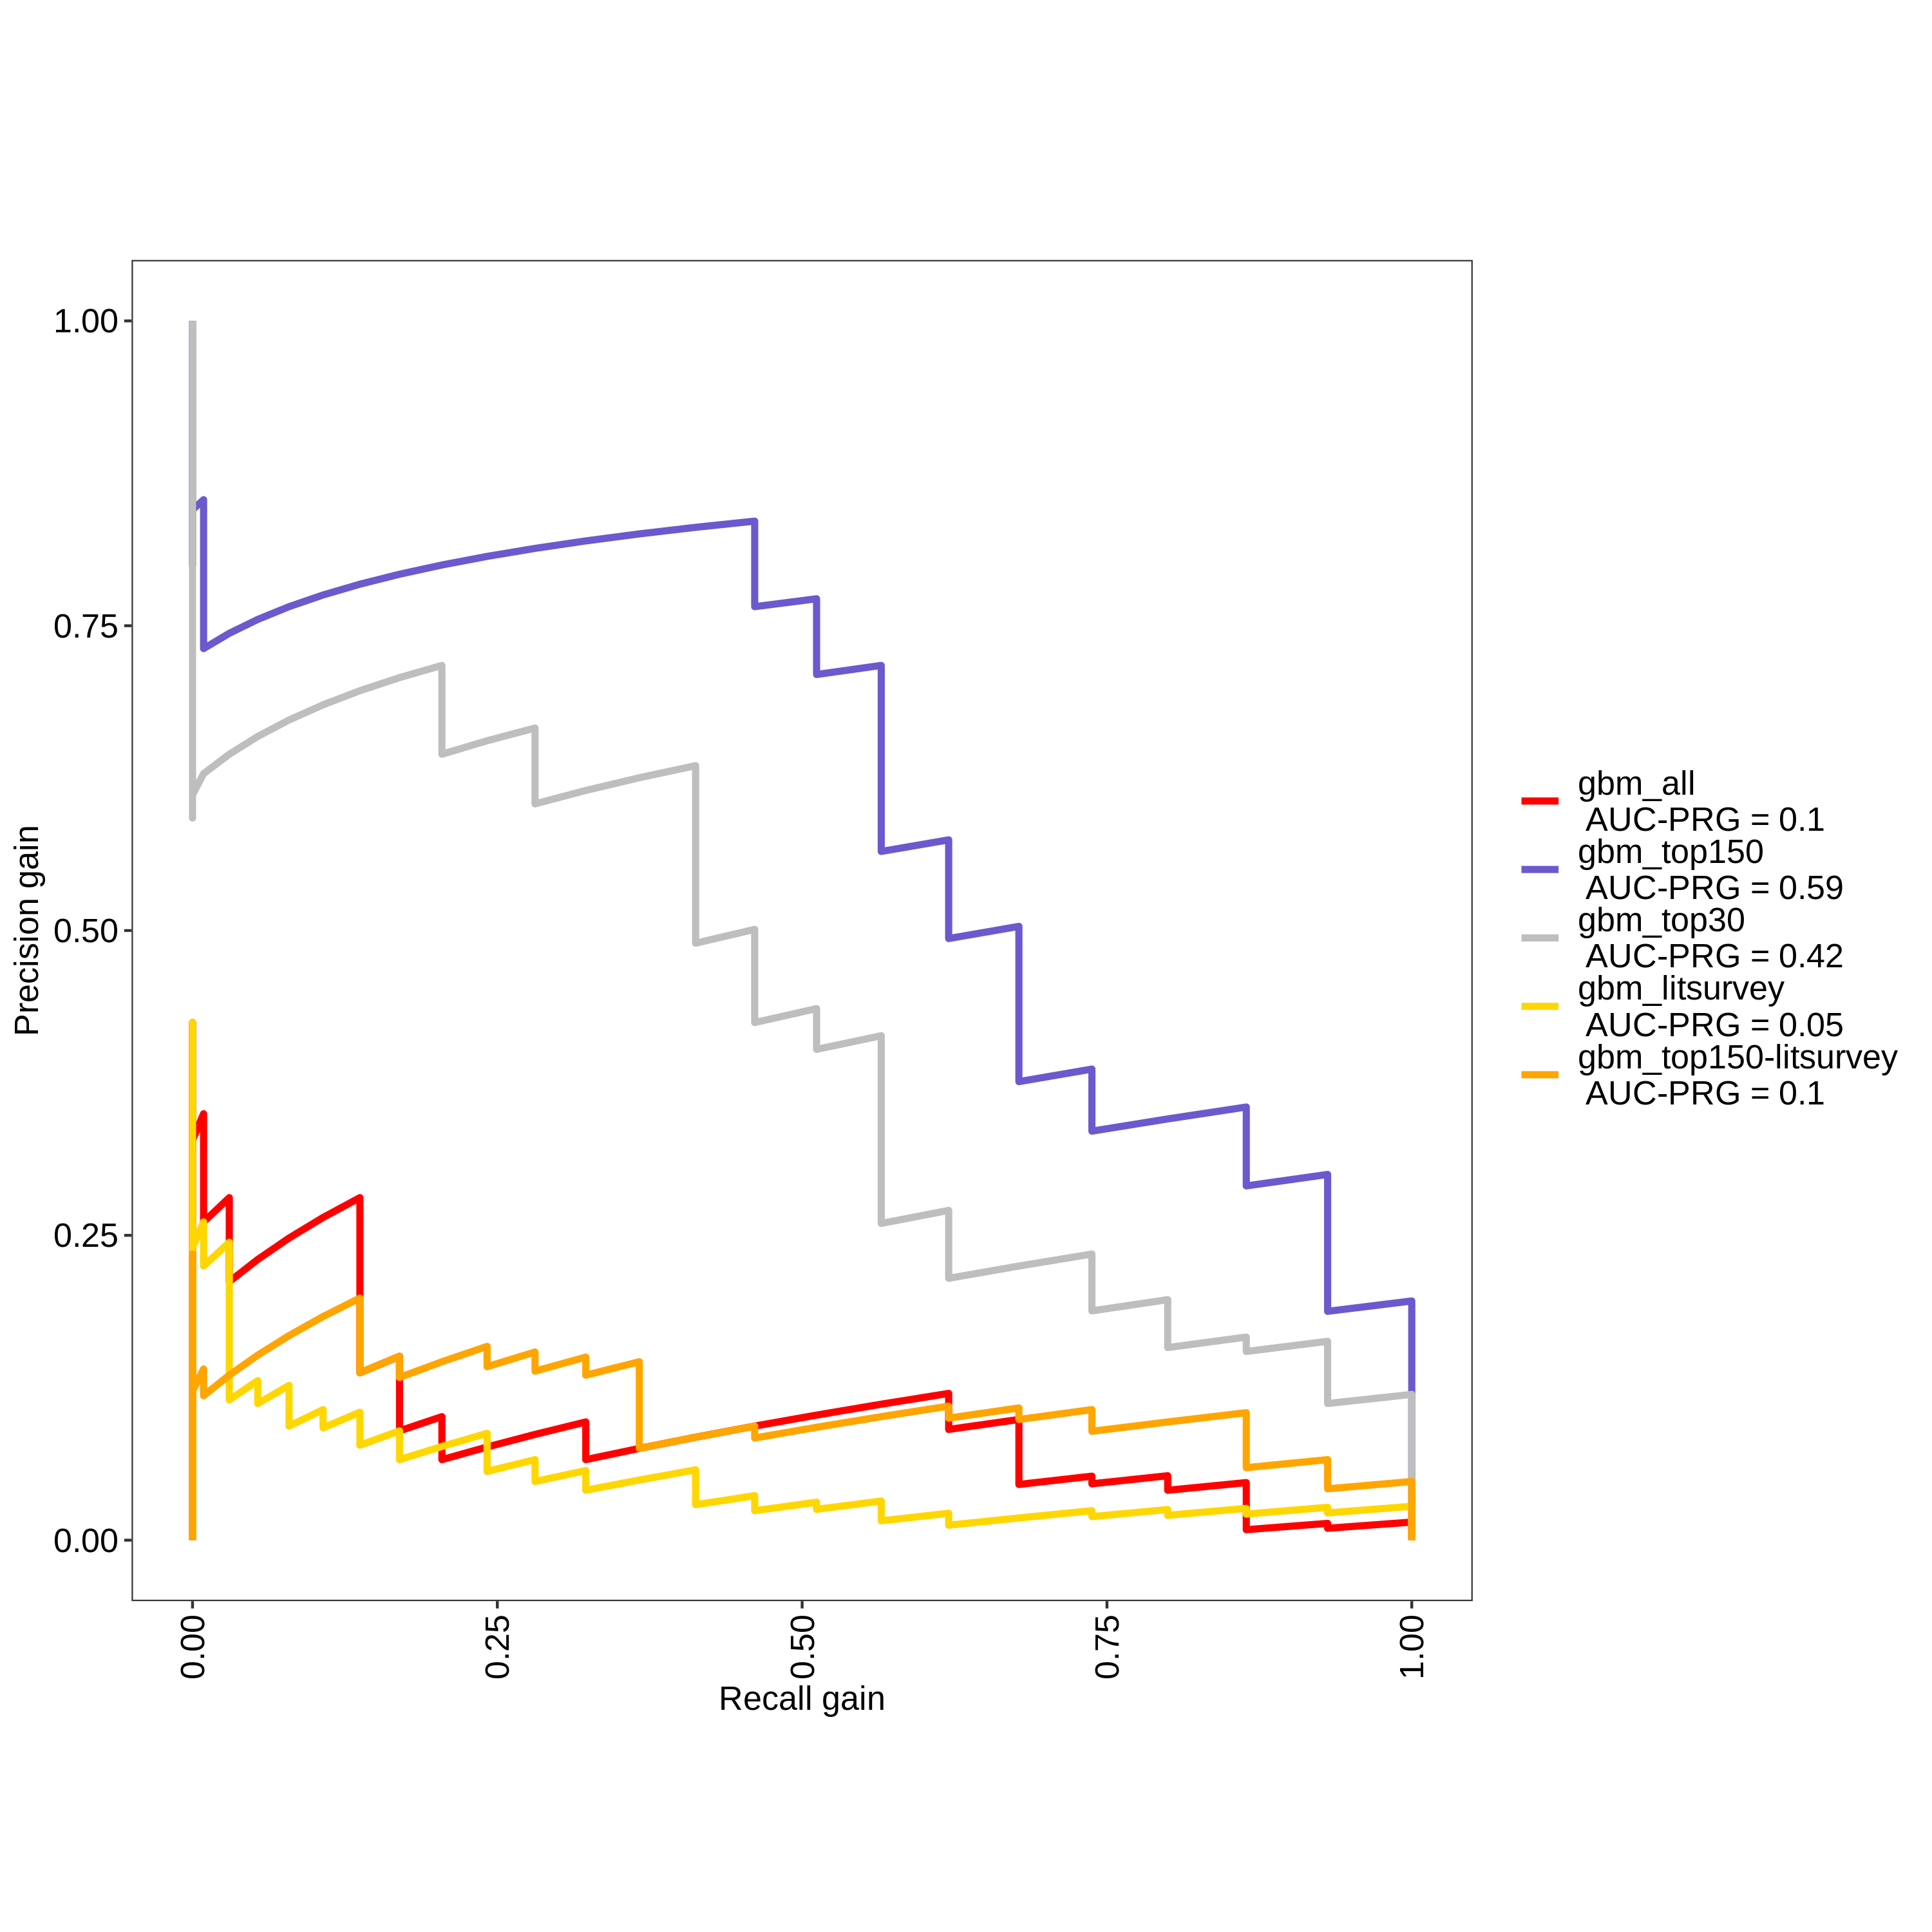

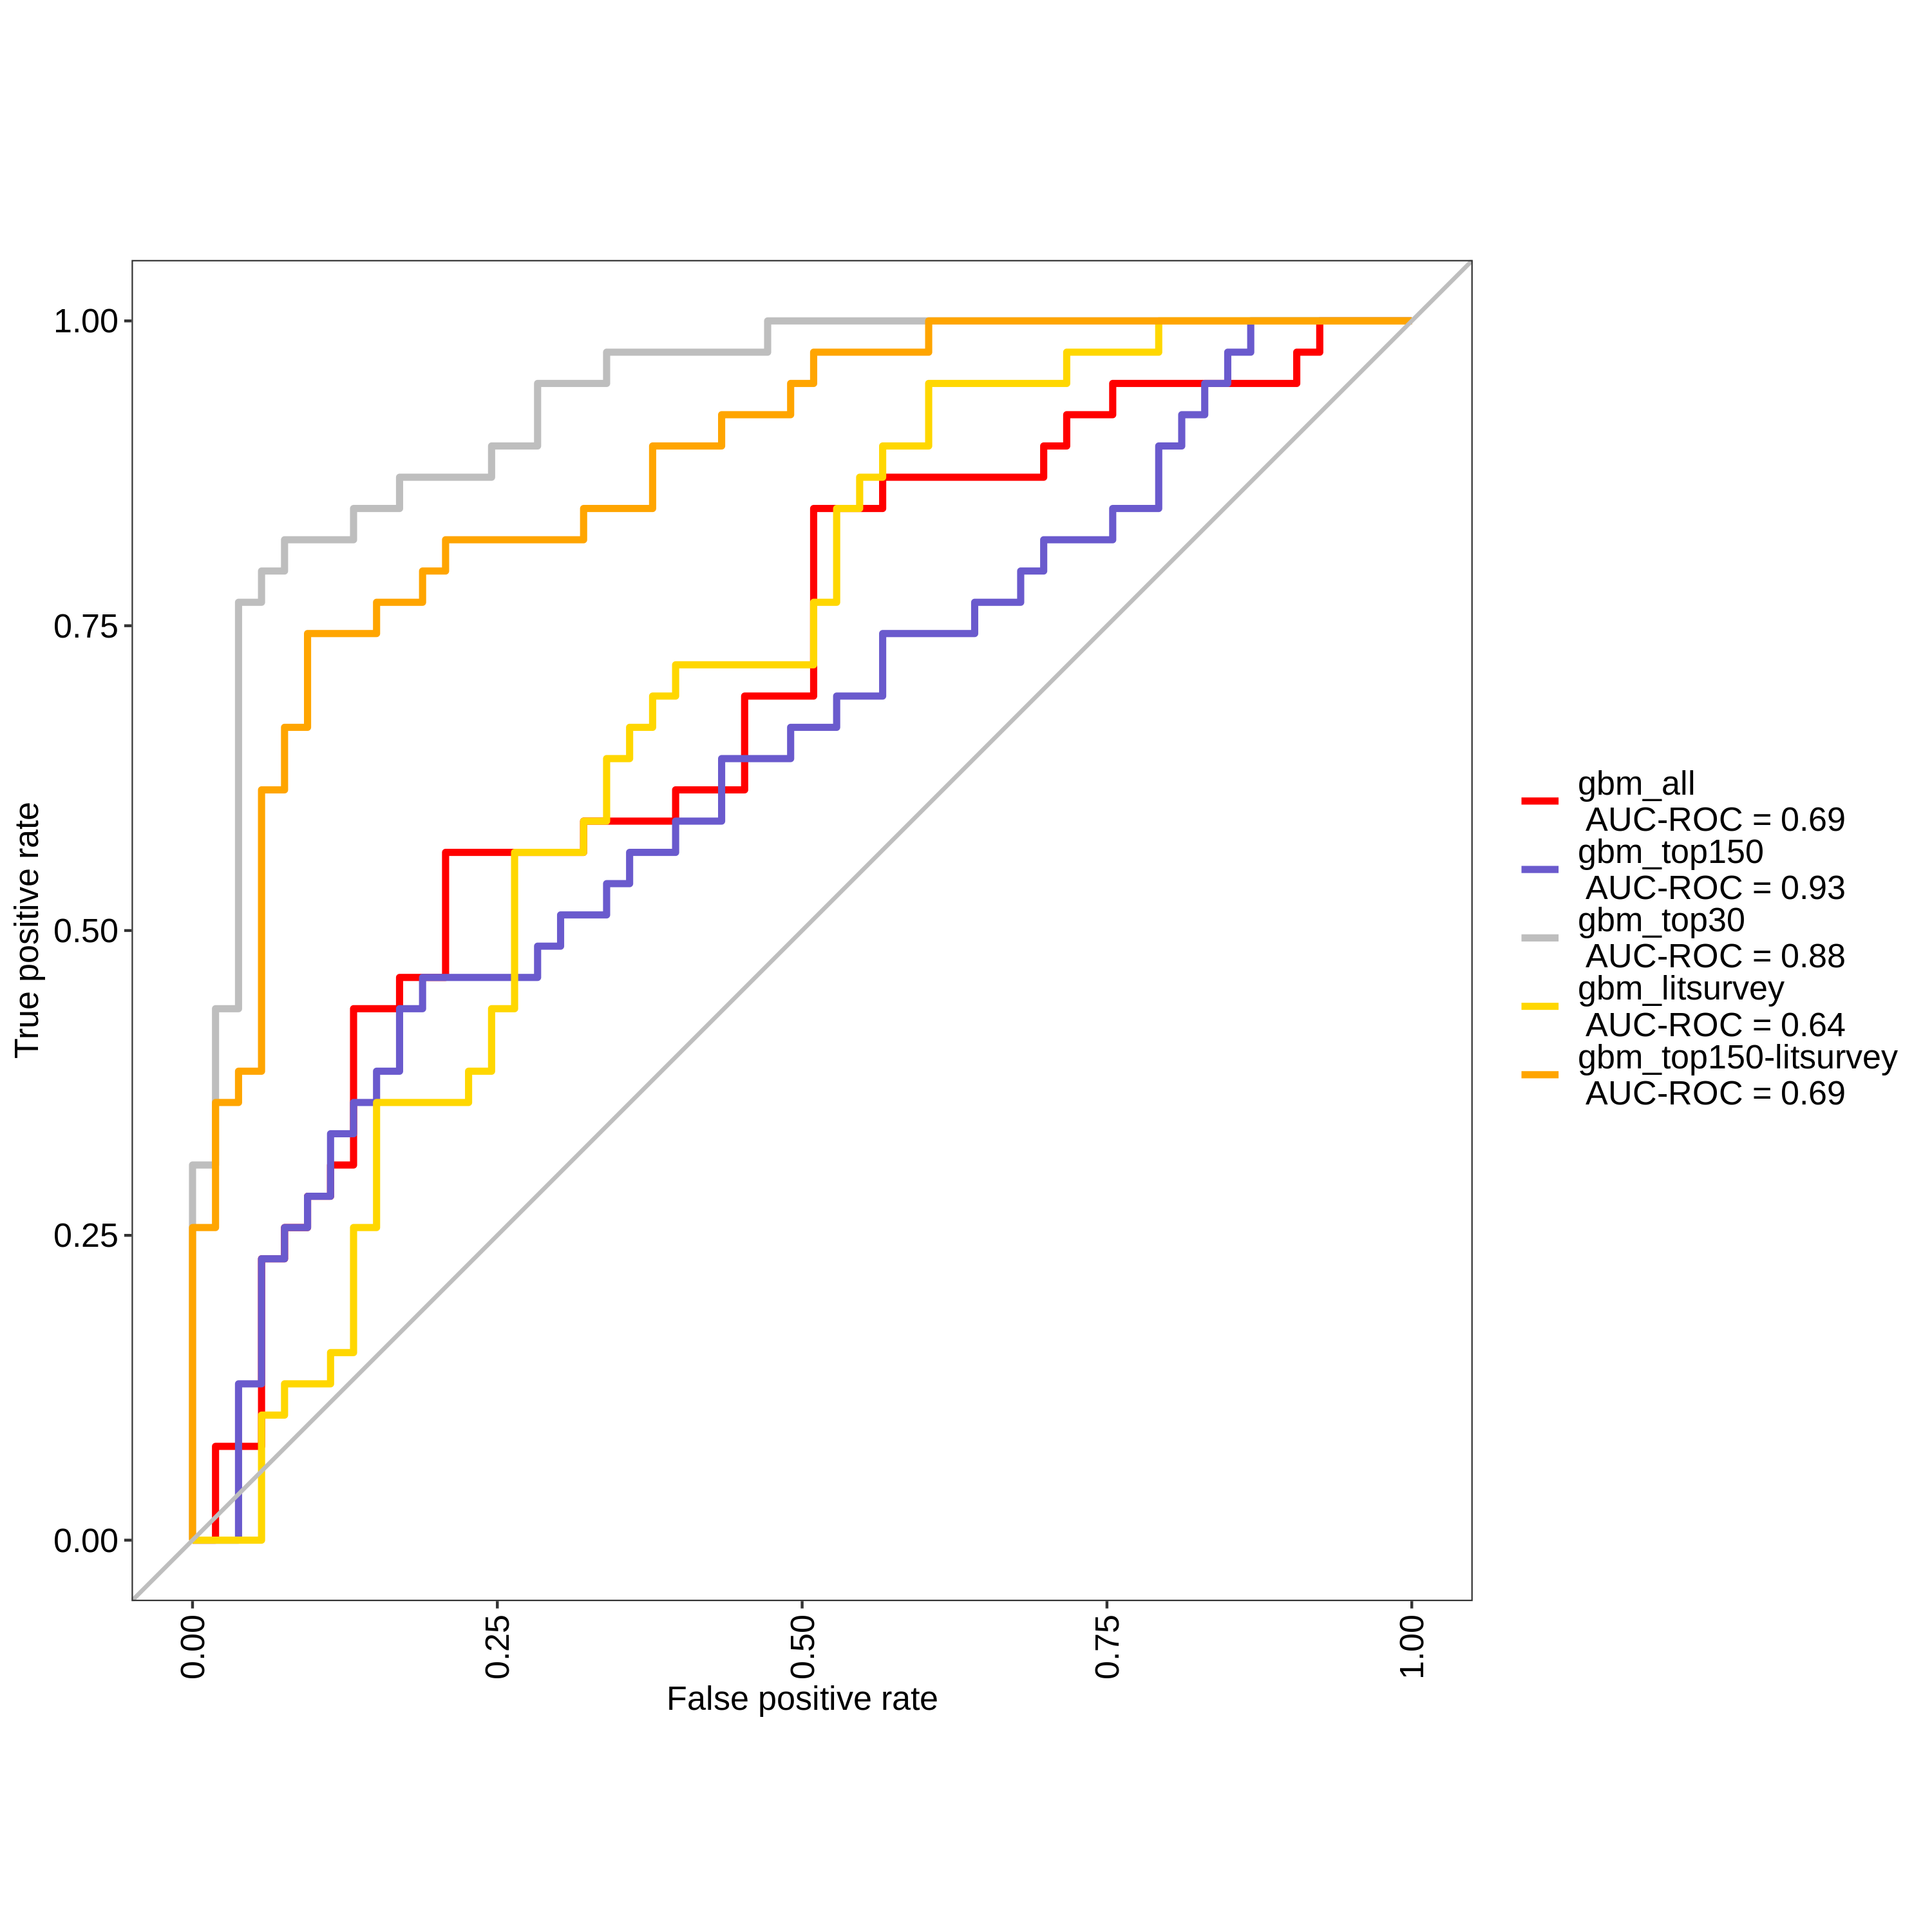

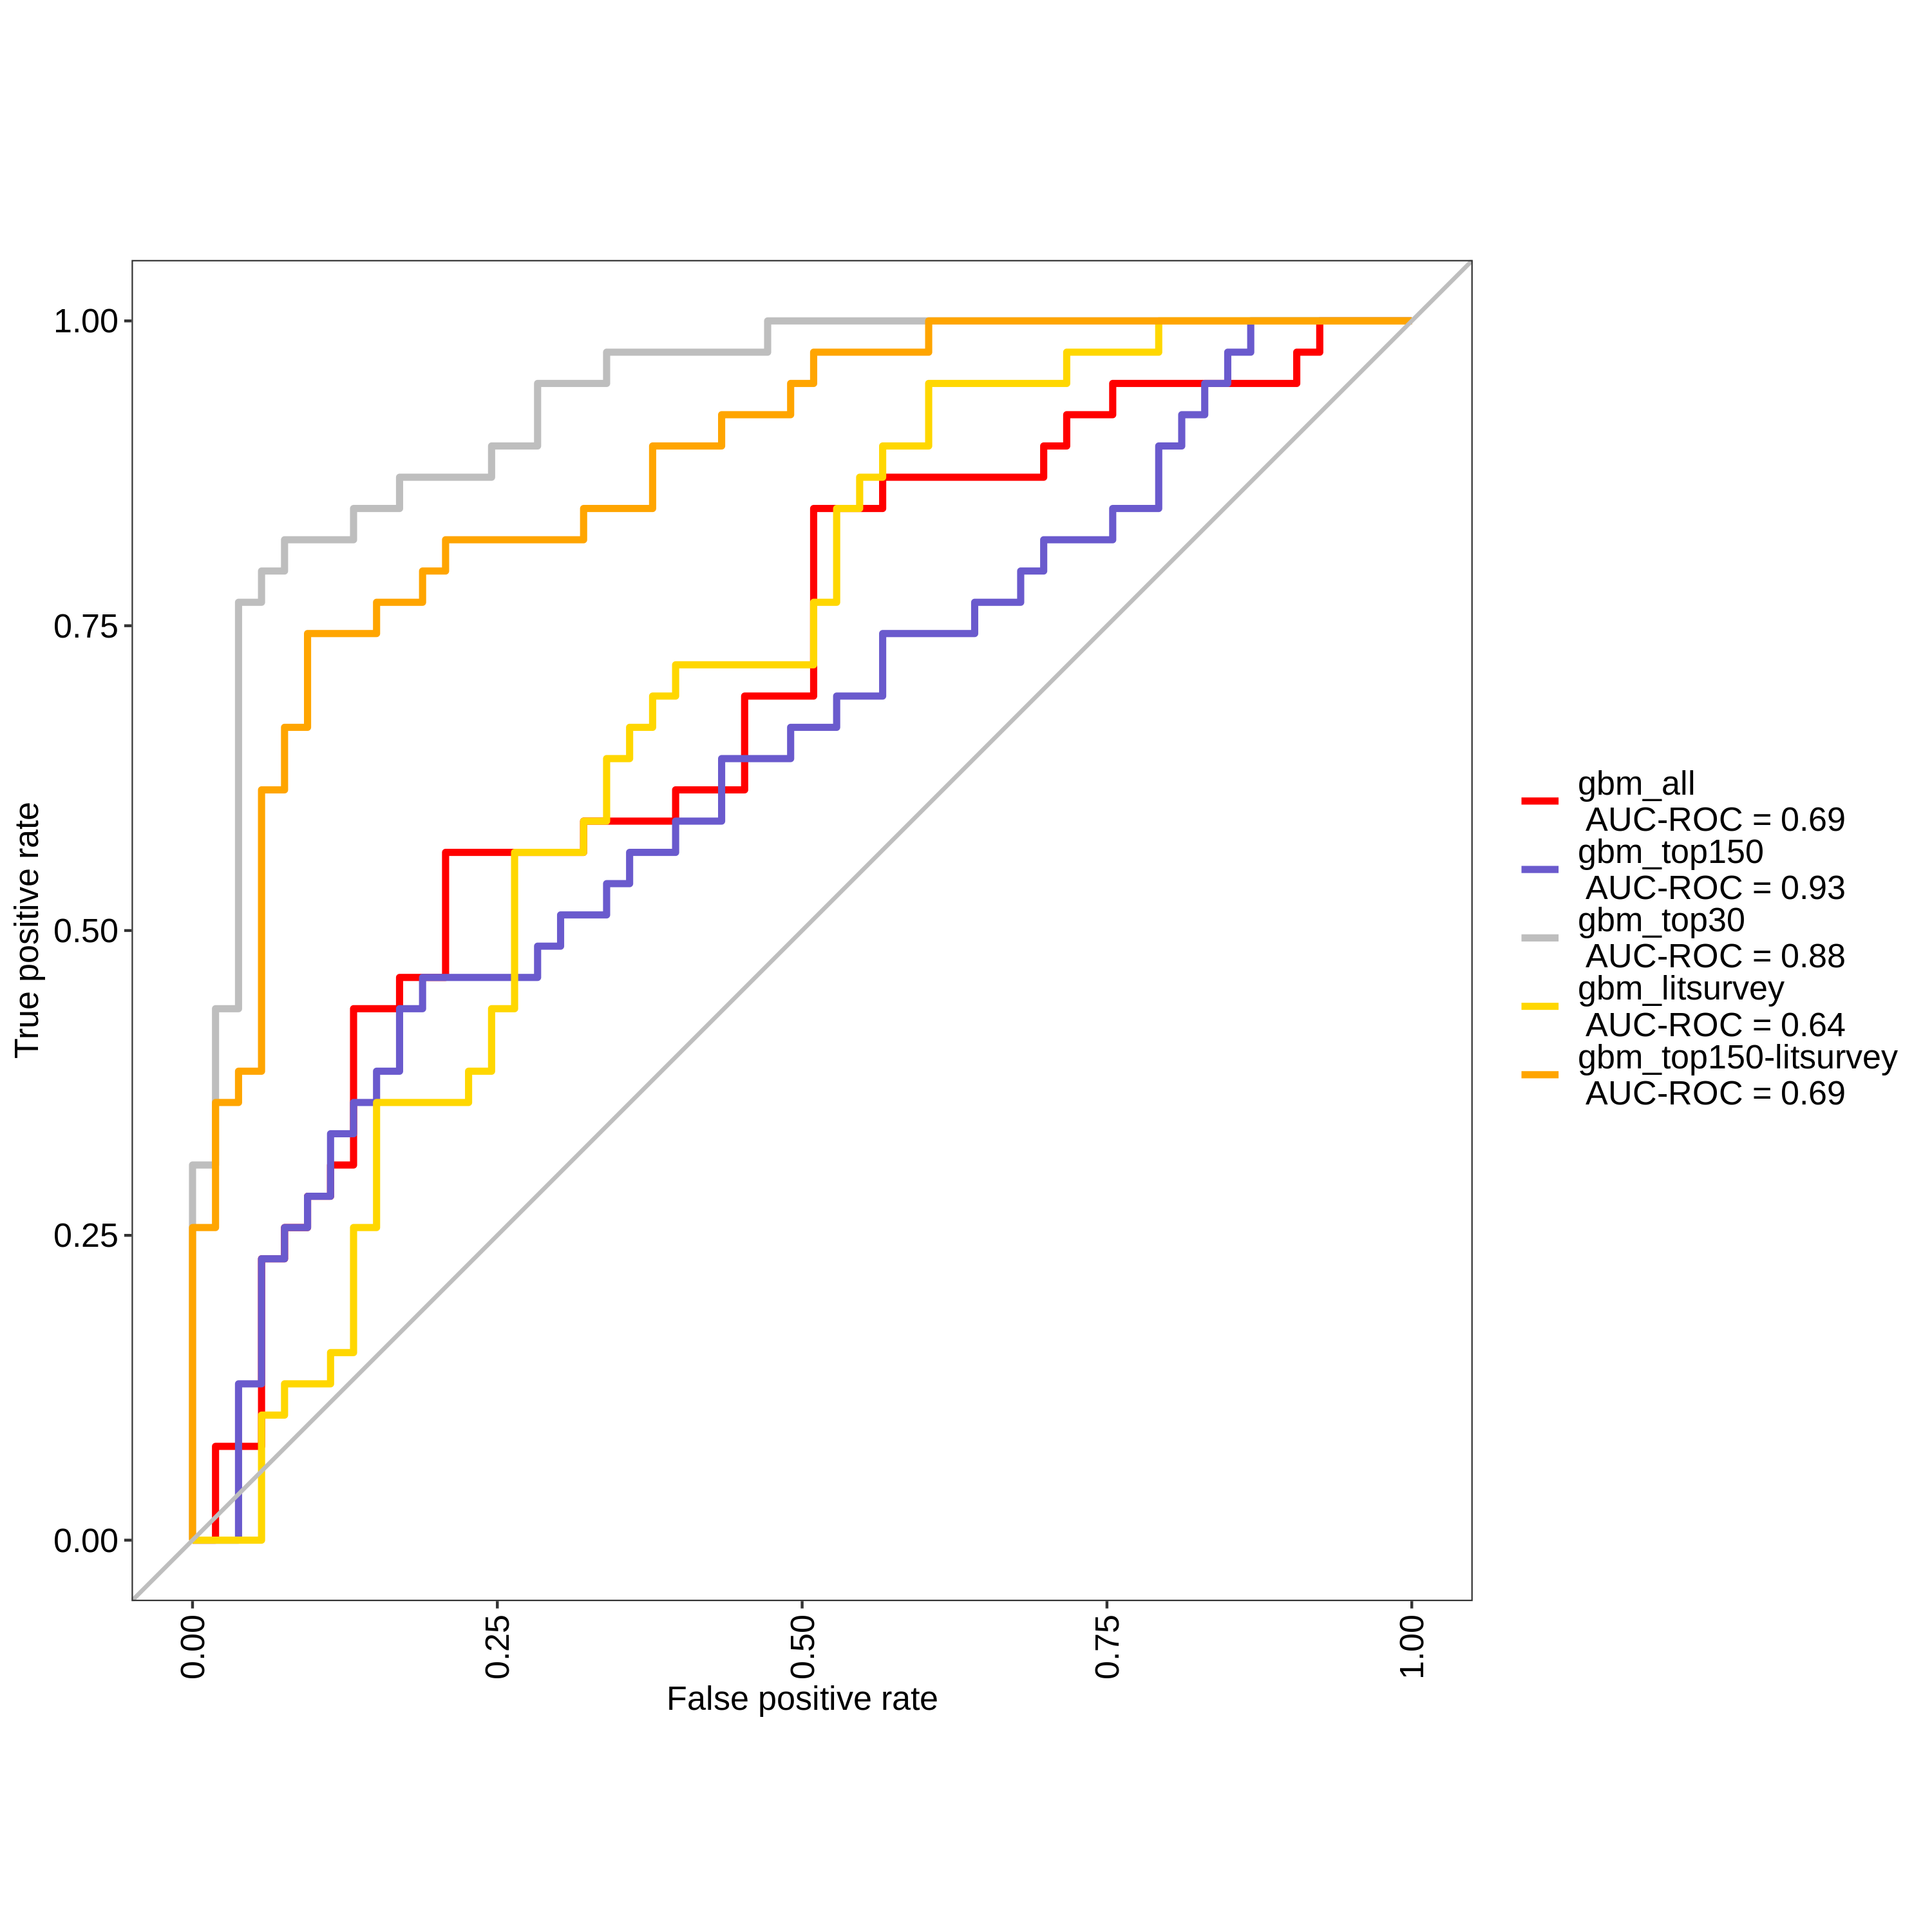

In [168]:
inp_top200_gbm <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.200 >= 4, "Gene_ID"])],
              method="gbm",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top50_gbm <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.50 >= 4, "Gene_ID"])],
              method="gbm",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_litsurvey_gbm <- train(Response ~ ., data=mod_inp_mat[,c("Response", genes_lit_rawdata)],
              method="gbm",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top200litsurvey_gbm <- train(Response ~ ., data=mod_inp_mat[,c("Response", top_genes_out)],
              method="gbm",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

res_gbm <- evalm(list(inp_top200_gbm, inp_top50_gbm, inp_litsurvey_gbm, inp_top200litsurvey_gbm),
             gnames=c('gbm_top200', 'gbm_top50', 'gbm_litsurvey', 'gbm_top200-litsurvey'))
res_gbm$roc

## Partial Least Squares

***MLeval: Machine Learning Model Evaluation***

Input: caret train function object

Averaging probs.

Group 1 type: repeatedcv

Group 2 type: repeatedcv

Group 3 type: repeatedcv

Group 4 type: repeatedcv

Group 5 type: repeatedcv

Observations: 460

Number of groups: 5

Observations per group: 92

Positive: Y

Negative: N

Group: pls_all

Positive: 39

Negative: 53

Group: pls_top150

Positive: 39

Negative: 53

Group: pls_top30

Positive: 39

Negative: 53

Group: pls_litsurvey

Positive: 39

Negative: 53

Group: pls_top150-litsurvey

Positive: 39

Negative: 53

***Performance Metrics***



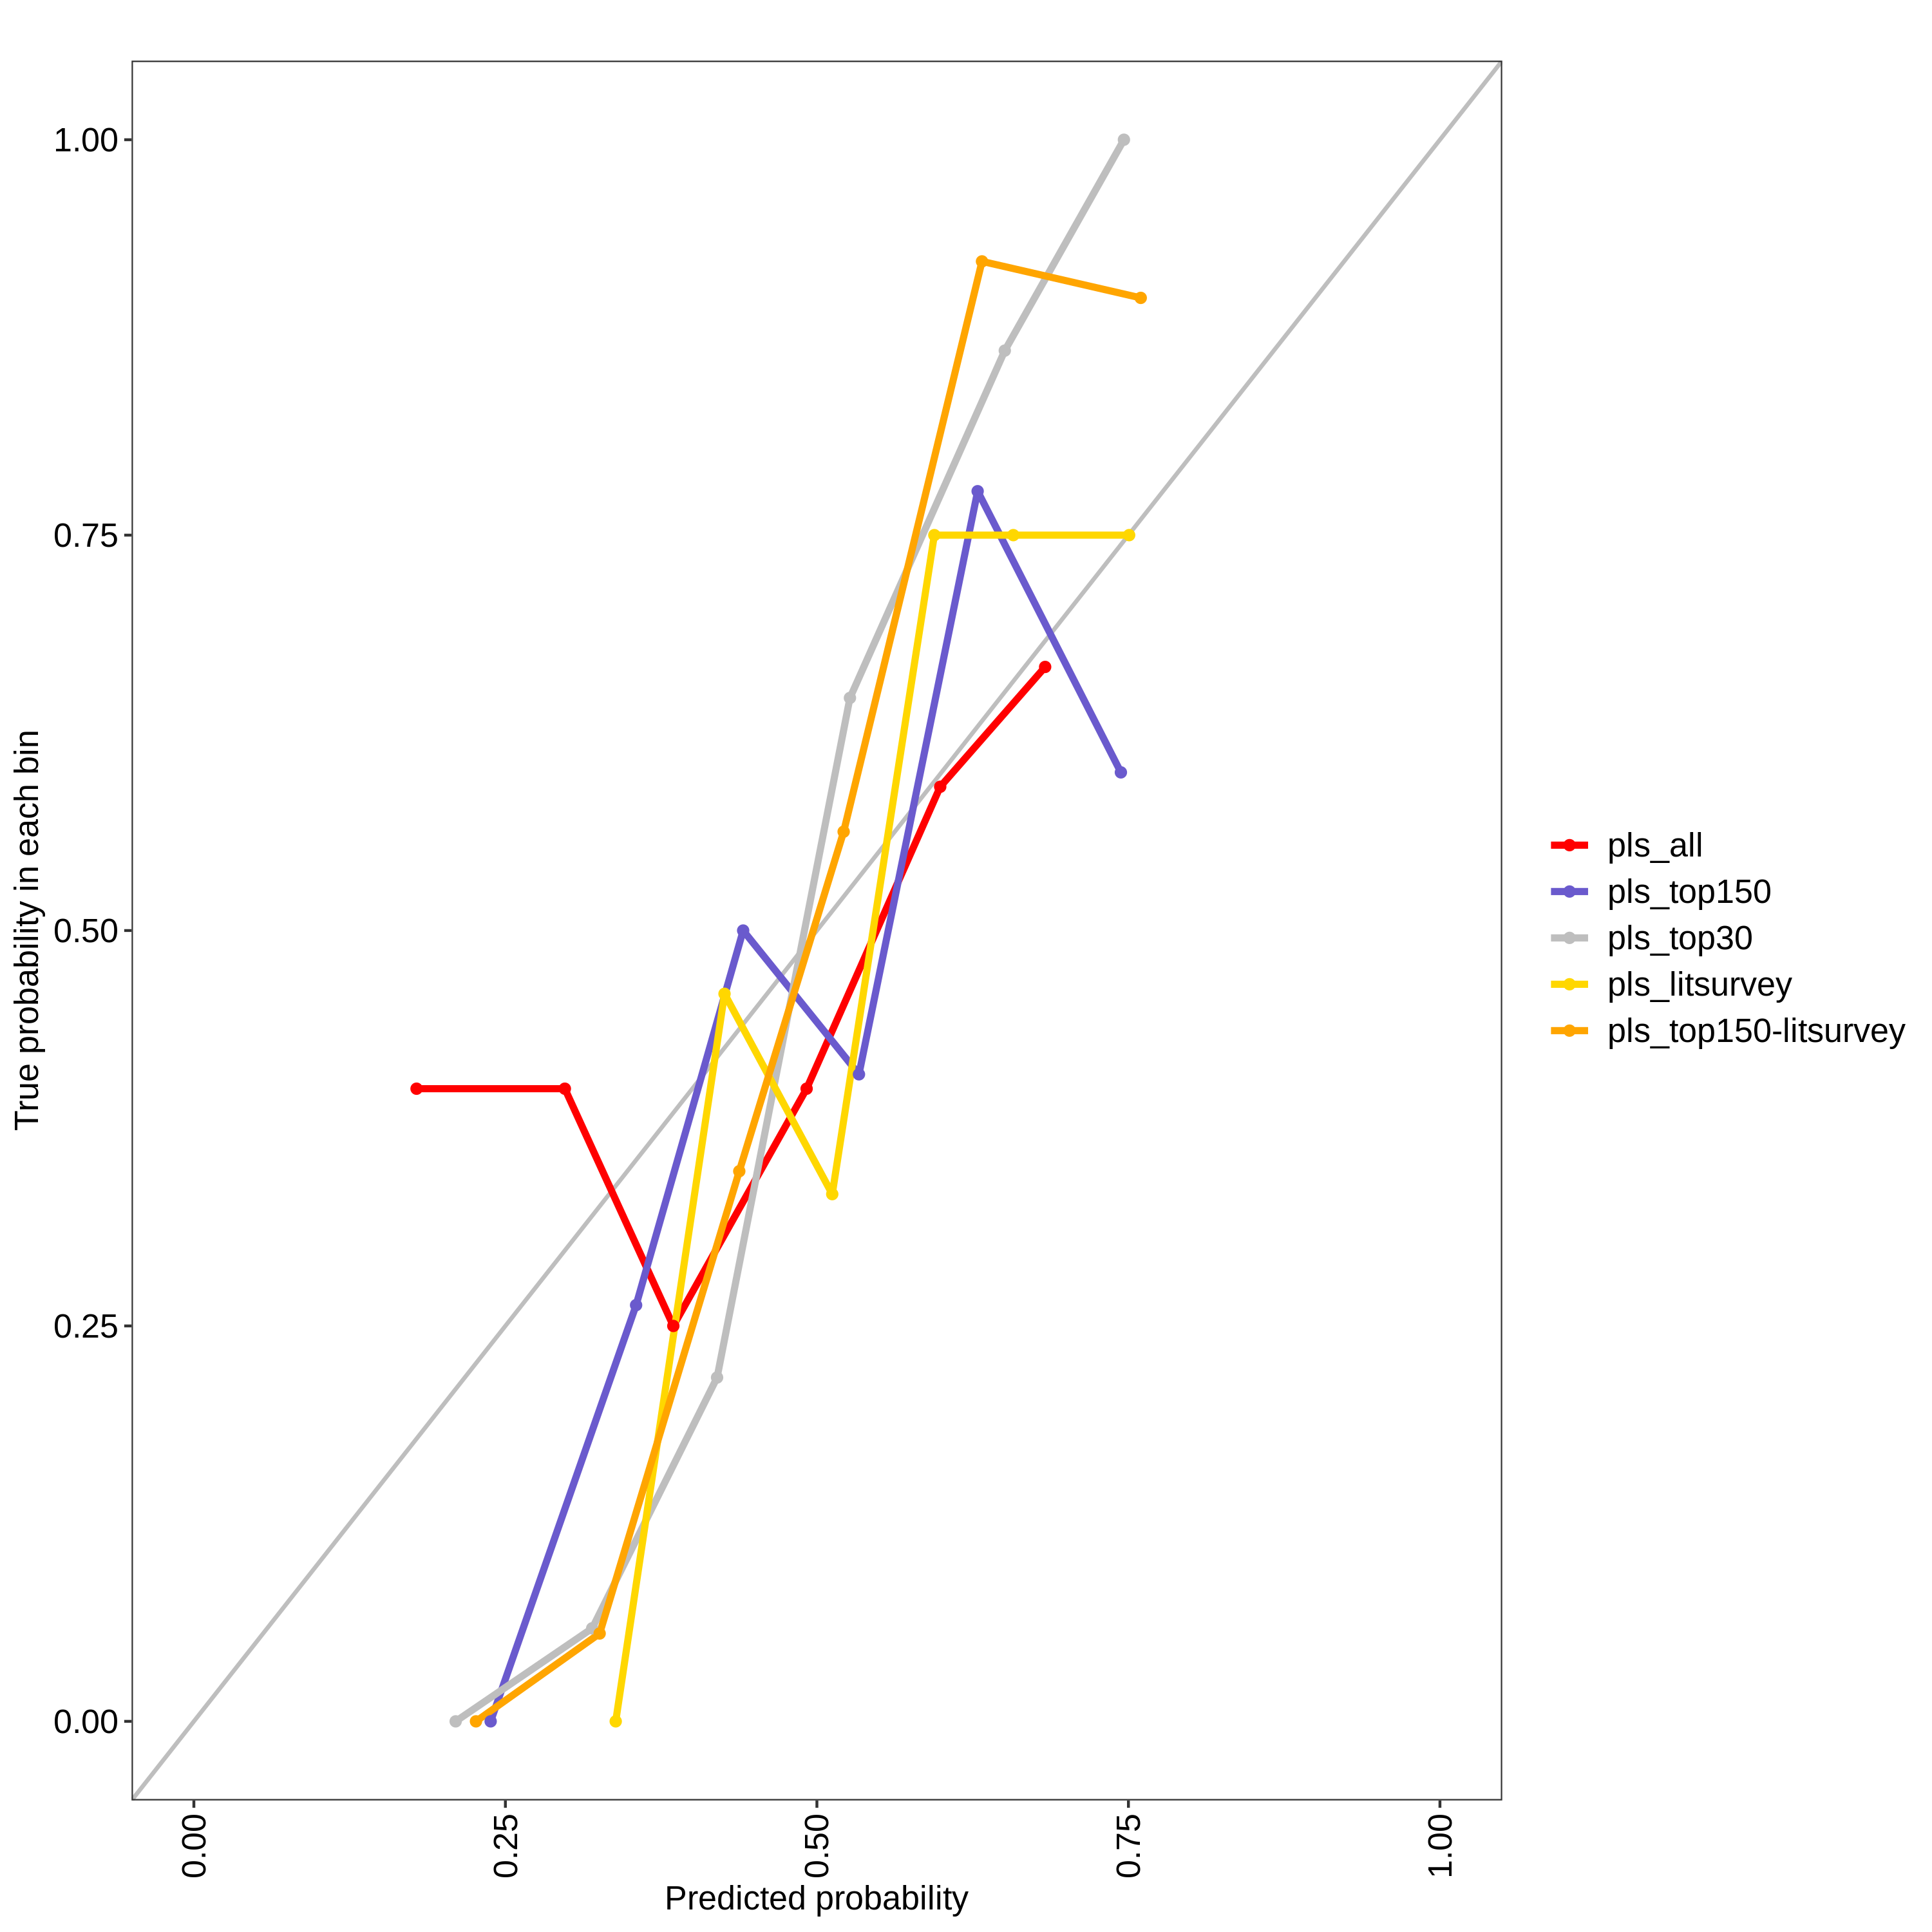

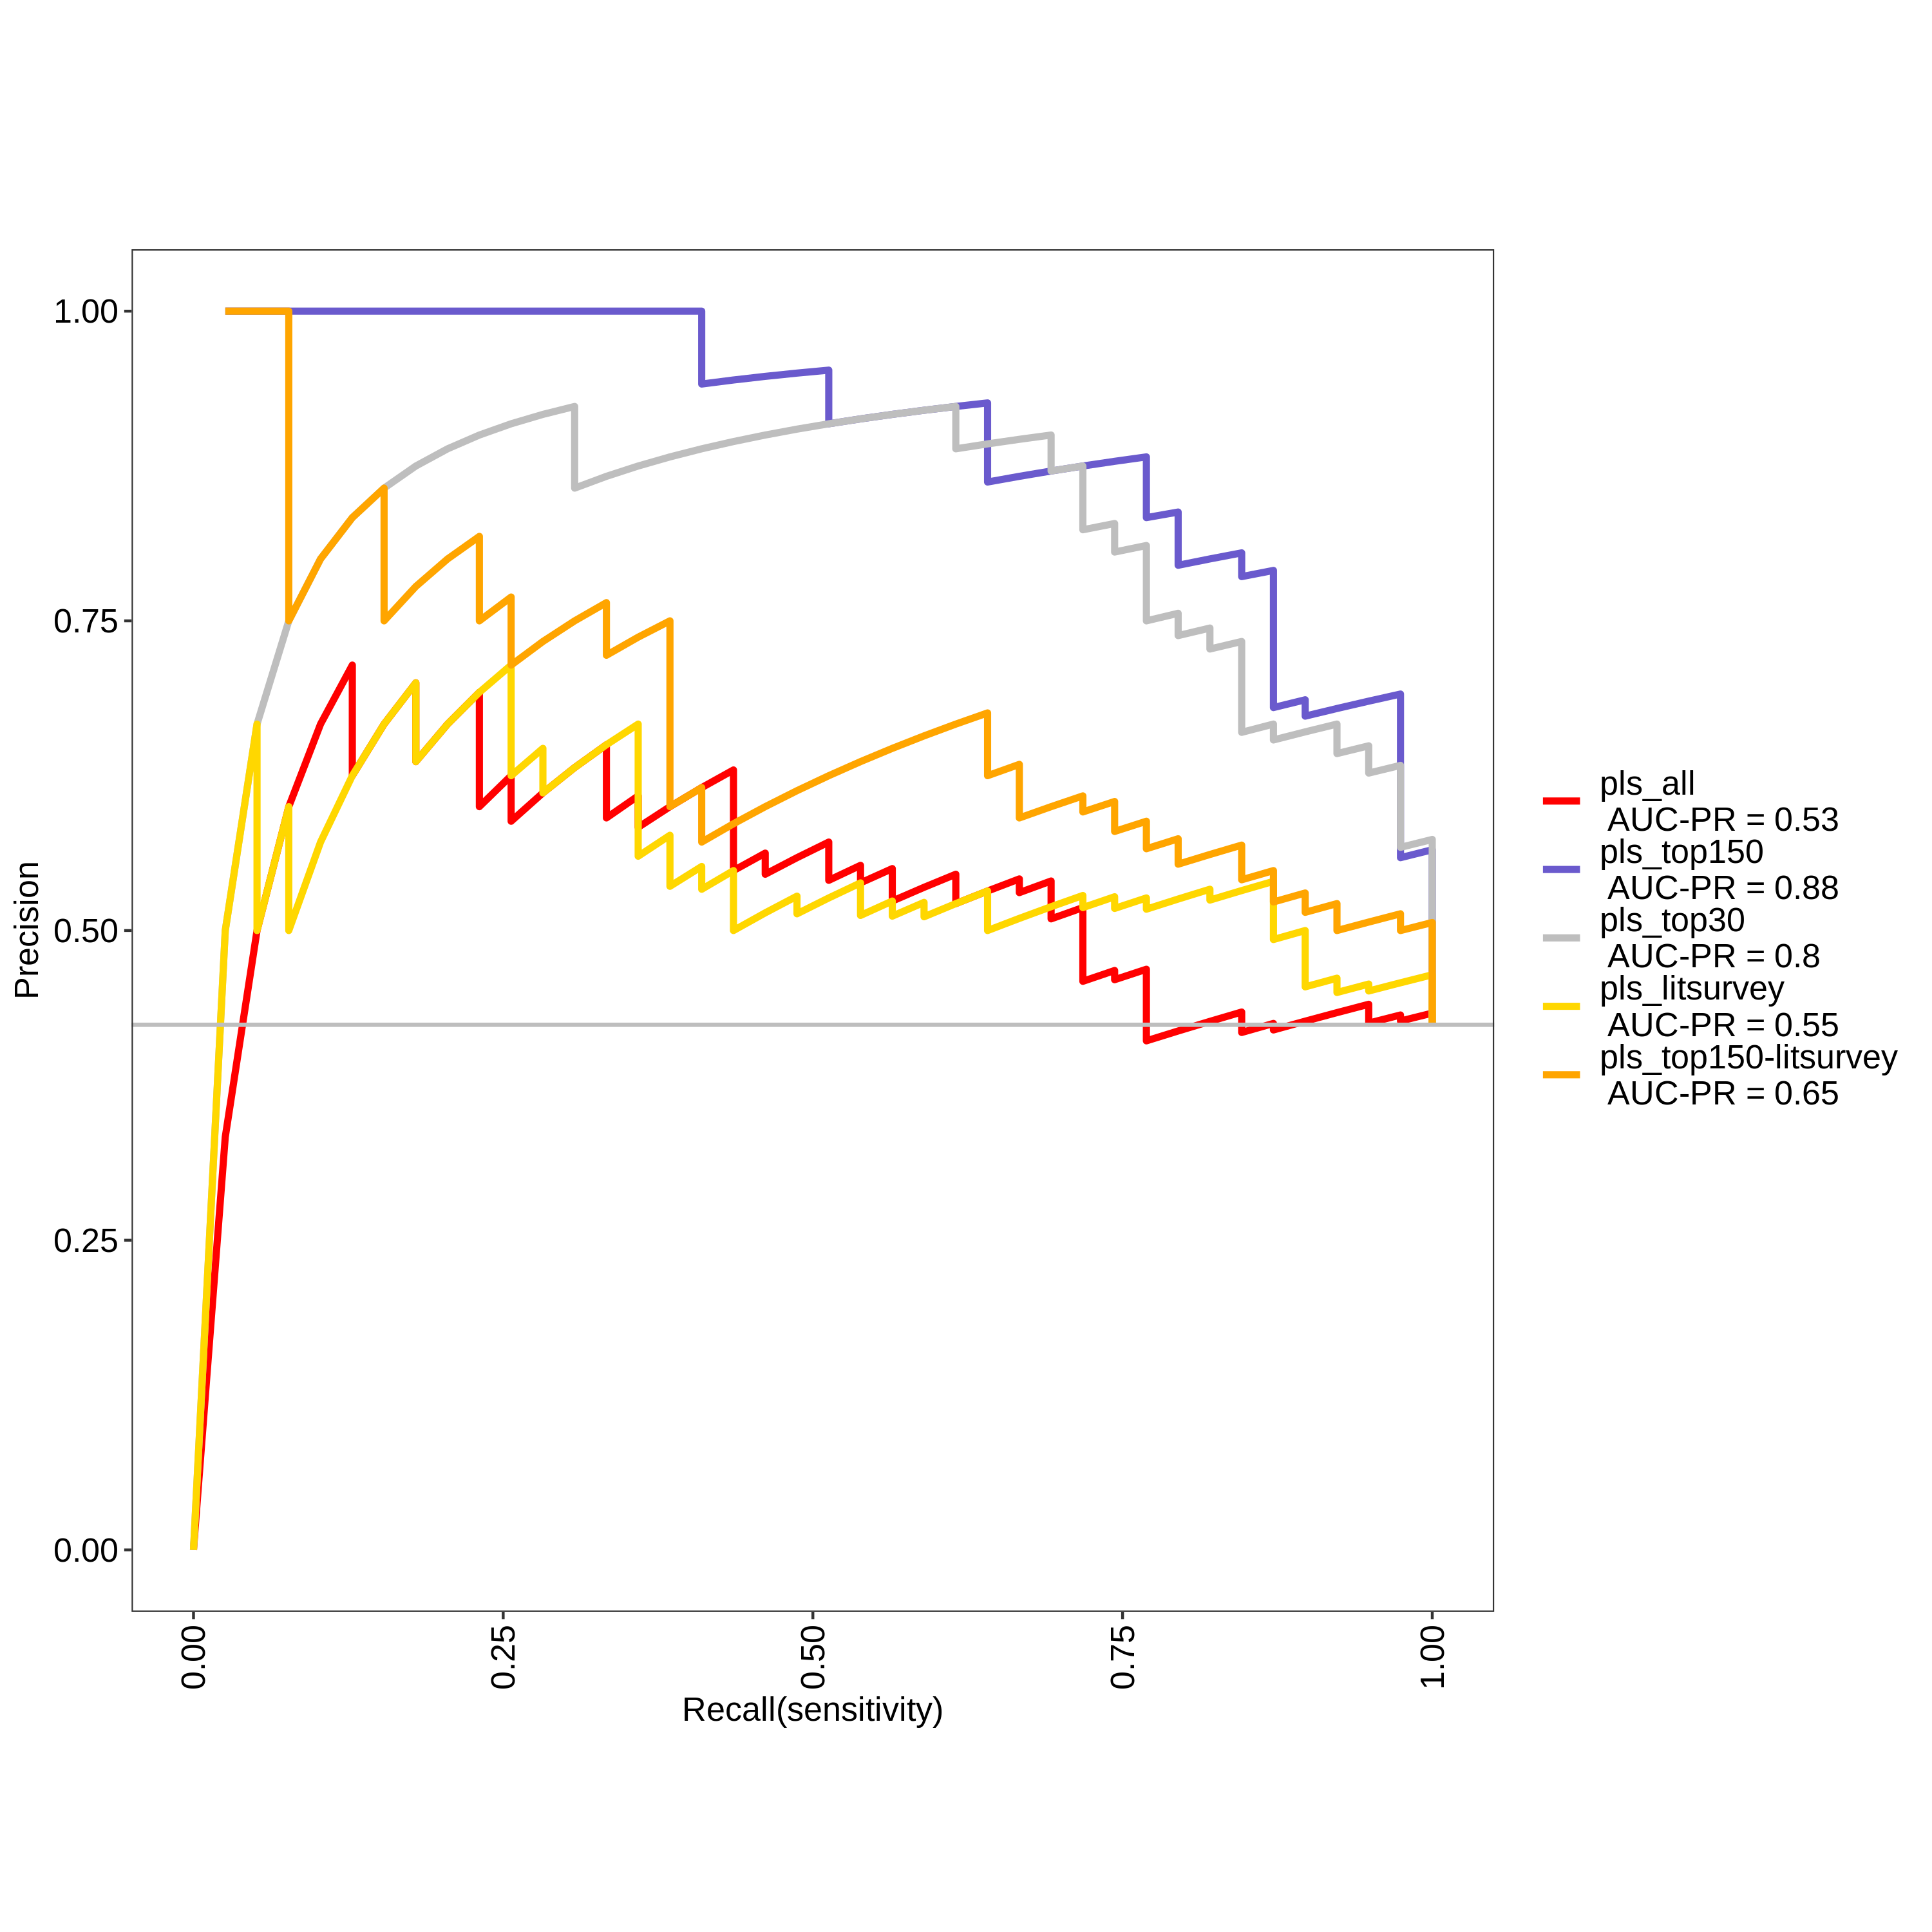

pls_all Optimal Informedness = 0.258345428156749

pls_top150 Optimal Informedness = 0.701983551040155

pls_top30 Optimal Informedness = 0.642477019835511

pls_litsurvey Optimal Informedness = 0.324625060474117

pls_top150-litsurvey Optimal Informedness = 0.414610546686018

pls_all AUC-ROC = 0.62

pls_top150 AUC-ROC = 0.92

pls_top30 AUC-ROC = 0.89

pls_litsurvey AUC-ROC = 0.66

pls_top150-litsurvey AUC-ROC = 0.75



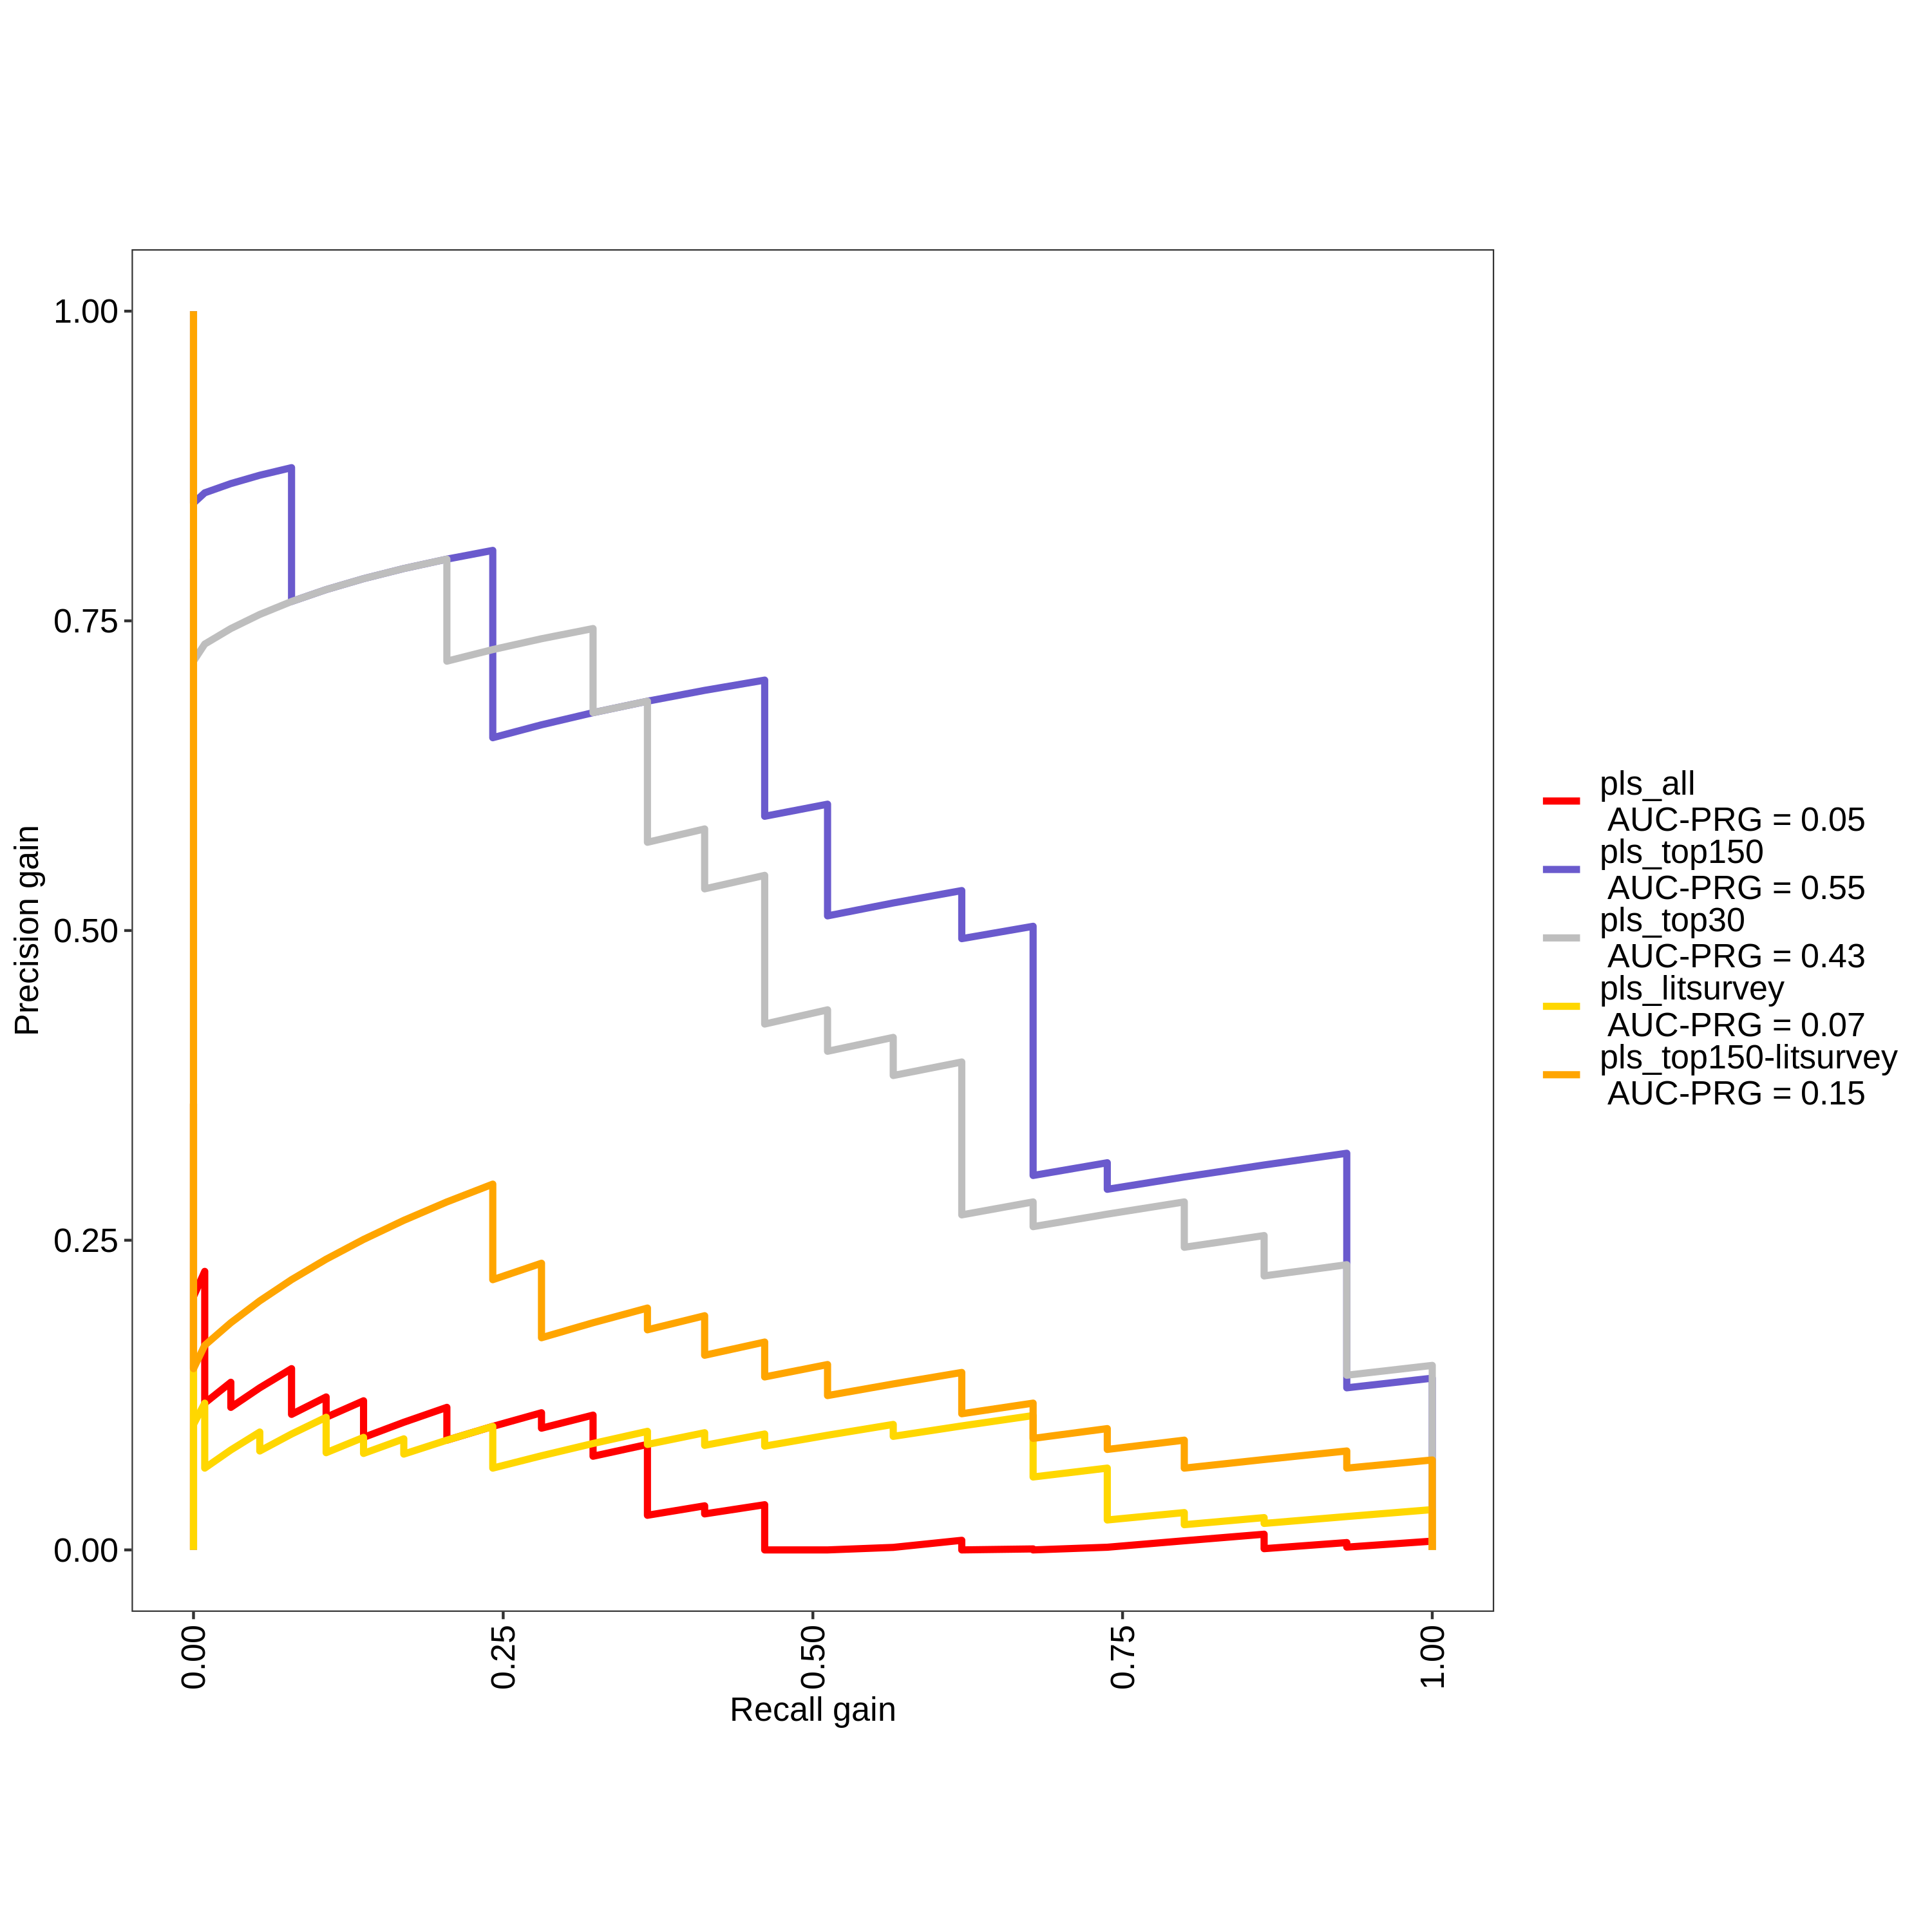

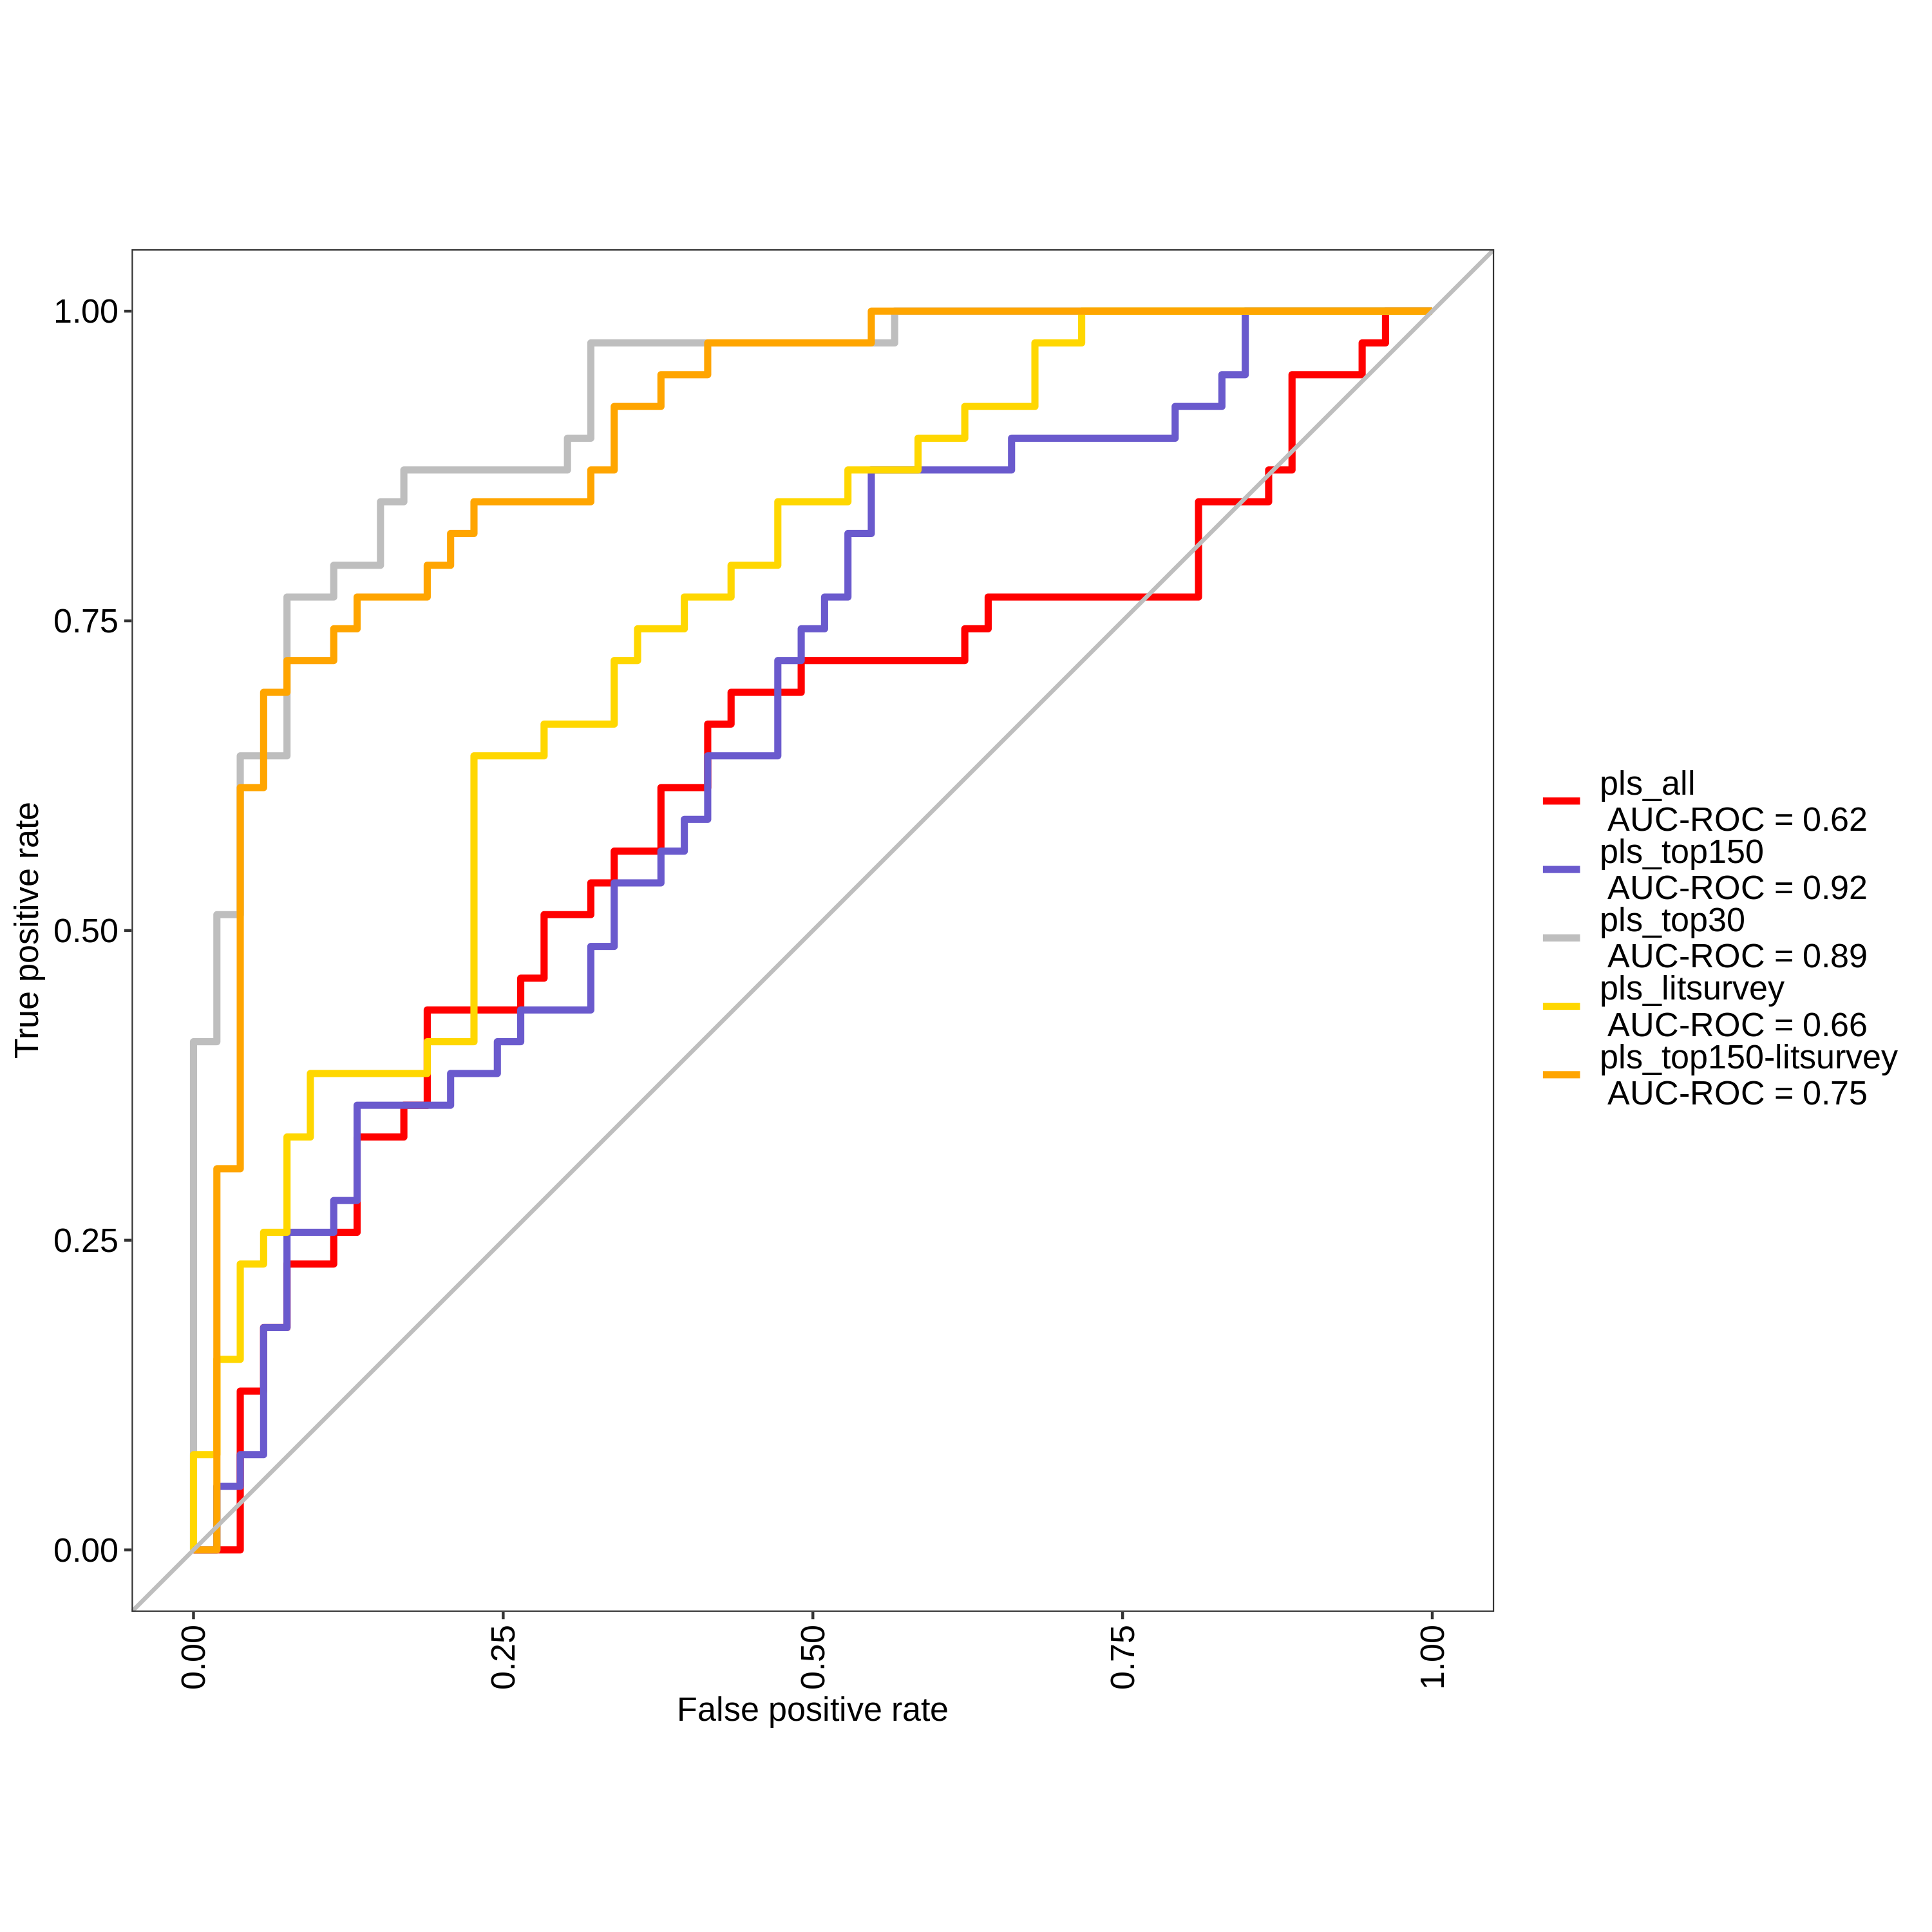

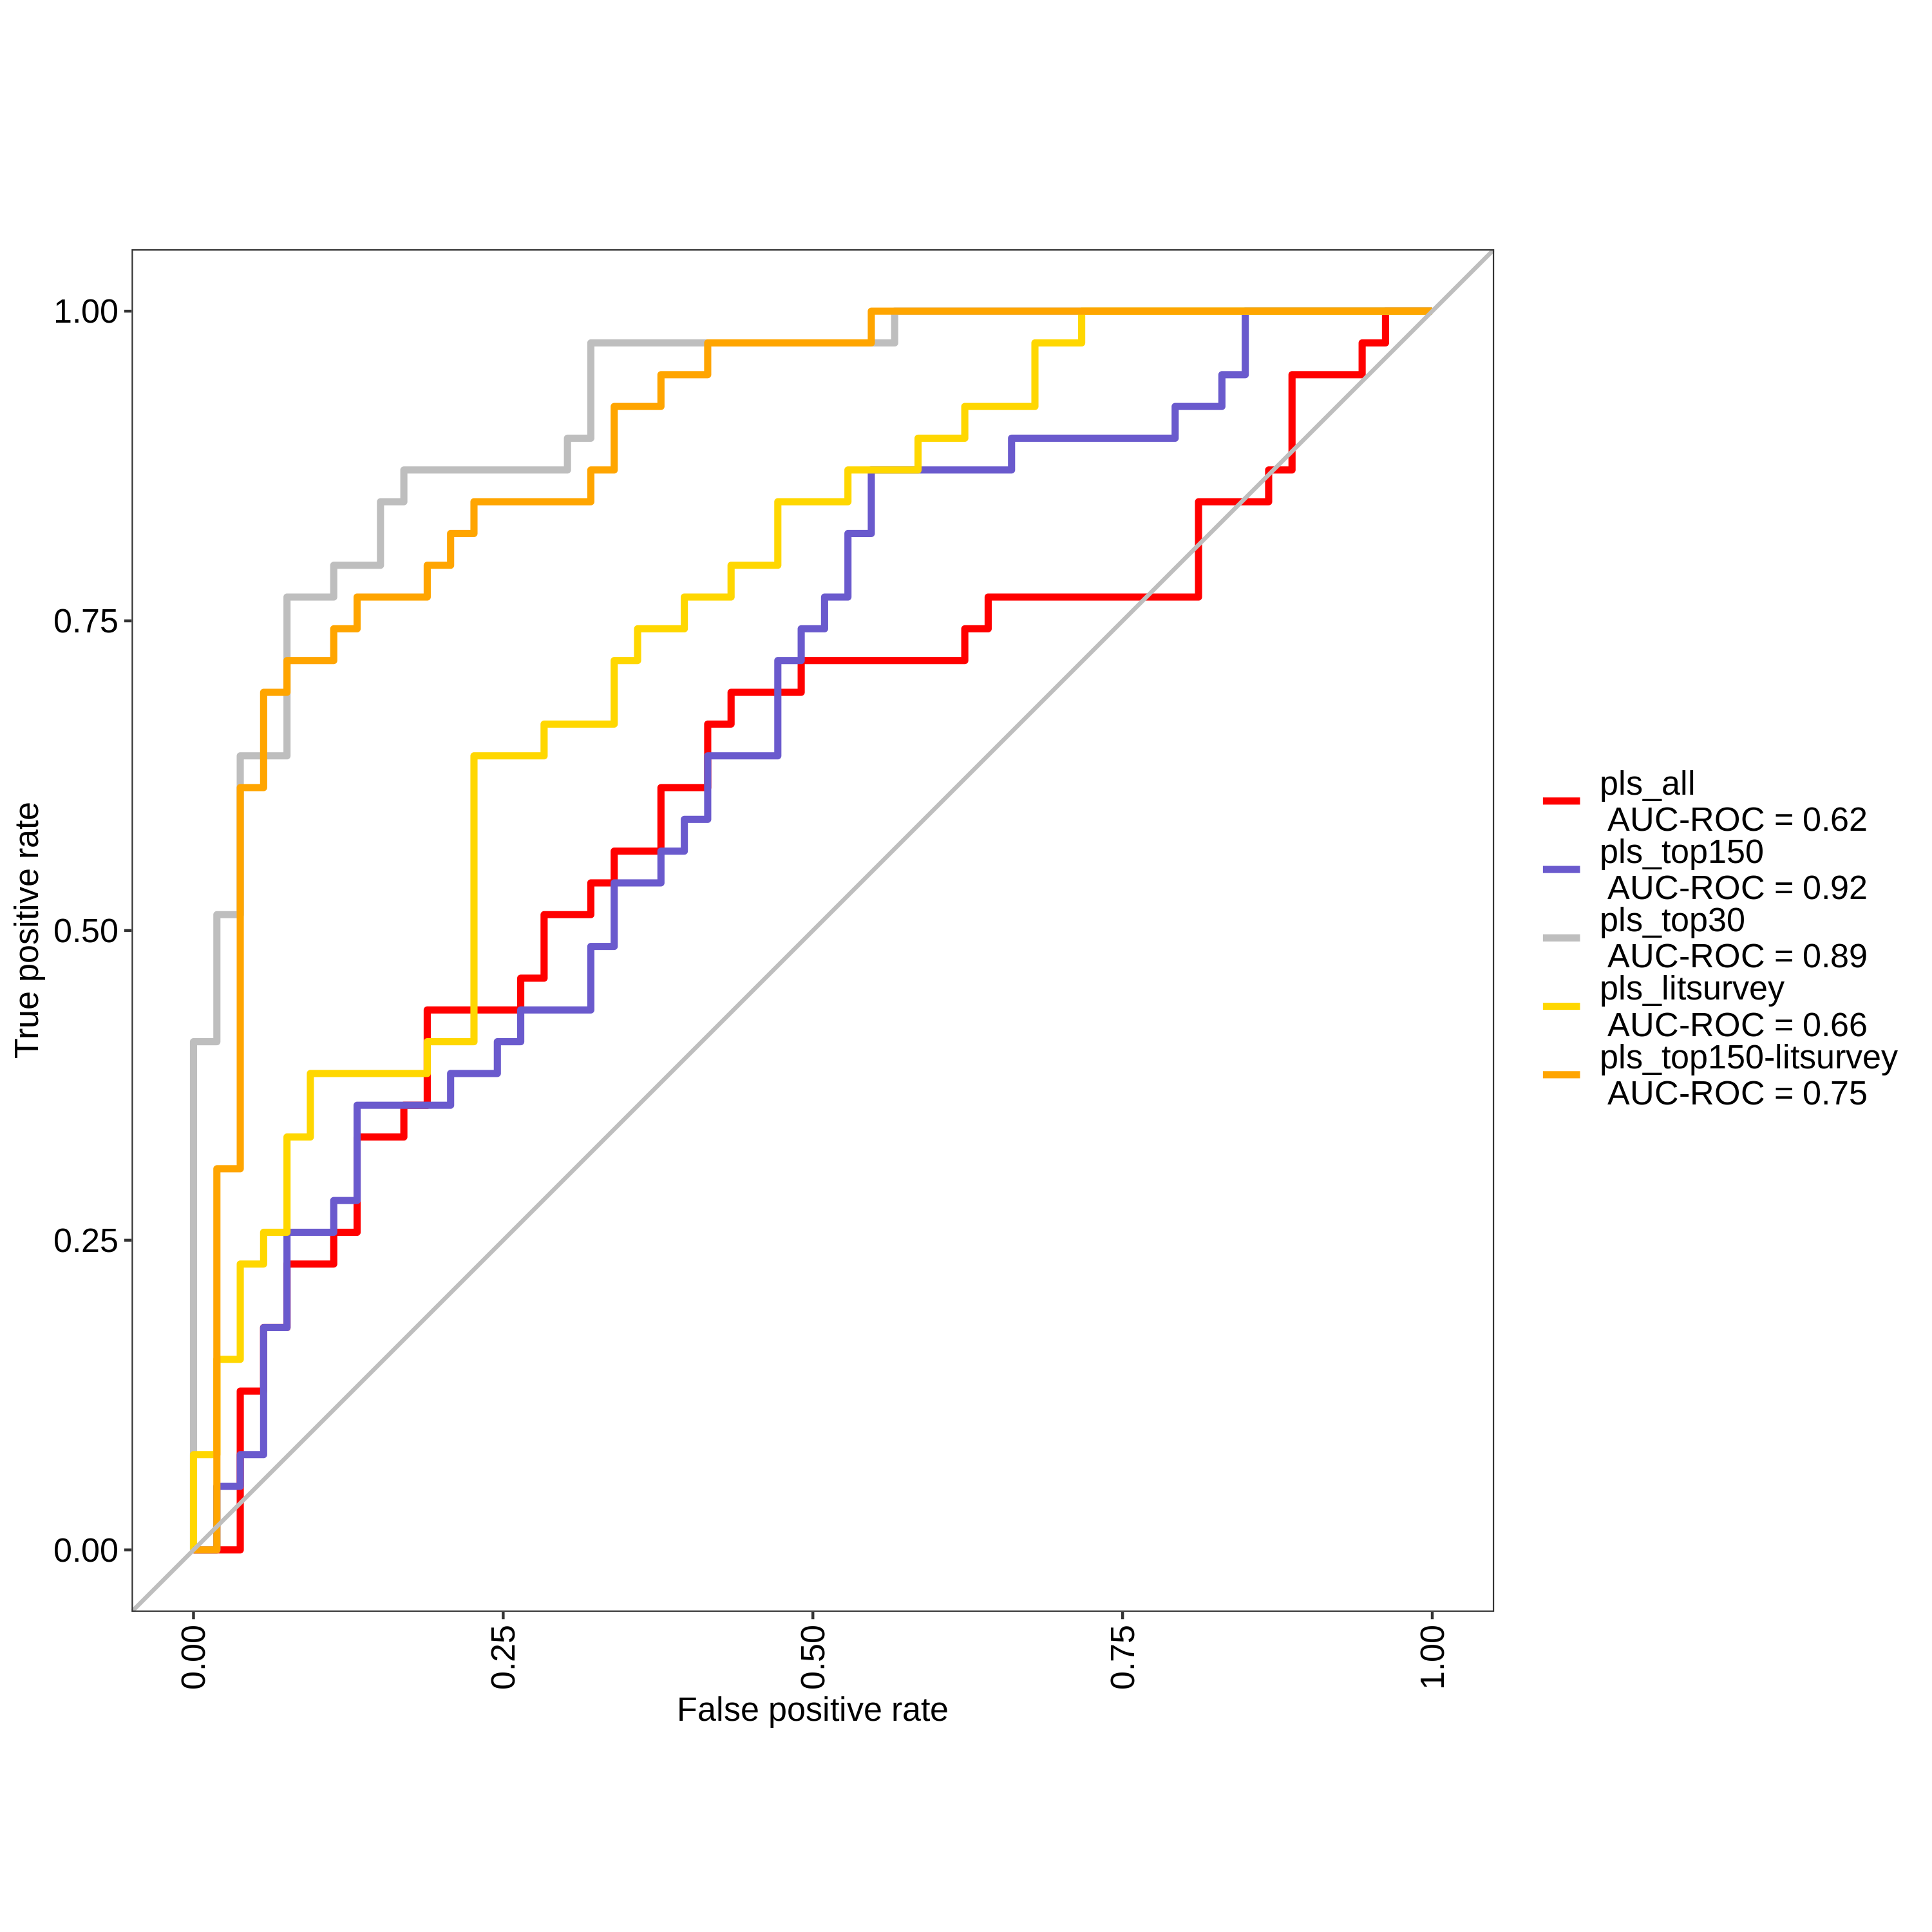

In [169]:
inp_top200_pls <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.200 >= 4, "Gene_ID"])],
              method="pls",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top50_pls <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.50 >= 4, "Gene_ID"])],
              method="pls",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_litsurvey_pls <- train(Response ~ ., data=mod_inp_mat[,c("Response", genes_lit_rawdata)],
              method="pls",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top200litsurvey_pls <- train(Response ~ ., data=mod_inp_mat[,c("Response", top_genes_out)],
              method="pls",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

res_pls <- evalm(list(inp_top200_pls, inp_top50_pls, inp_litsurvey_pls, inp_top200litsurvey_pls),
             gnames=c('pls_top200', 'pls_top50', 'pls_litsurvey', 'pls_top200-litsurvey'))
res_pls$roc

## Cforest

In [170]:
inp_top200_crf <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.200 >= 4, "Gene_ID"])],
              method="cforest",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top50_crf <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.50 >= 4, "Gene_ID"])],
              method="cforest",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_litsurvey_crf <- train(Response ~ ., data=mod_inp_mat[,c("Response", genes_lit_rawdata)],
              method="cforest",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top200litsurvey_crf <- train(Response ~ ., data=mod_inp_mat[,c("Response", top_genes_out)],
              method="cforest",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

res_crf <- evalm(list(inp_top200_crf, inp_top50_crf, inp_litsurvey_crf, inp_top200litsurvey_crf),
             gnames=c('crf_top200', 'crf_top50', 'crf_litsurvey', 'crf_top200-litsurvey'))
res_crf$roc

## Roc based classifier

In [ ]:
inp_top200_rocc <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.200 >= 4, "Gene_ID"])],
              method="rocc",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top50_rocc <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.50 >= 4, "Gene_ID"])],
              method="rocc",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_litsurvey_rocc <- train(Response ~ ., data=mod_inp_mat[,c("Response", genes_lit_rawdata)],
              method="rocc",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top200litsurvey_rocc <- train(Response ~ ., data=mod_inp_mat[,c("Response", top_genes_out)],
              method="rocc",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

res_rocc <- evalm(list(inp_top200_rocc, inp_top50_rocc, inp_litsurvey_rocc, inp_top200litsurvey_rocc),
             gnames=c('rocc_top200', 'rocc_top50', 'rocc_litsurvey', 'rocc_top200-litsurvey'))
res_rocc$roc

## Naive Bayes

In [ ]:
inp_top200_nb <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.200 >= 4, "Gene_ID"])],
              method="naive_bayes",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top50_nb <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.50 >= 4, "Gene_ID"])],
              method="naive_bayes",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_litsurvey_nb <- train(Response ~ ., data=mod_inp_mat[,c("Response", genes_lit_rawdata)],
              method="naive_bayes",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top200litsurvey_nb <- train(Response ~ ., data=mod_inp_mat[,c("Response", top_genes_out)],
              method="naive_bayes",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

res_nb <- evalm(list(inp_top200_nb, inp_top50_nb, inp_litsurvey_nb, inp_top200litsurvey_nb),
             gnames=c('nb_top200', 'nb_top50', 'nb_litsurvey', 'nb_top200-litsurvey'))
res_nb$roc

ROC-AUC Graphs available at https://github.com/runtime-terror101/ICP-Responders/tree/master/ICP_Responders/ROC_AUC%20analysis

# Comparison

In [155]:
# all.rank[all.rank$Threshold.250 >= 3, "Gene_ID"]
genes_lit_rawdata

[1]  5133 29126 80380  1493   925   920   940   941   942   673  1956   238
[13]  5728  6774  6794  3845  3107  3586  7040  3620  3902 84868 80381   953
[25]  4907  2315  6490  7299  5426  5424  7157 55193  1019  1021  5771   187
[37]  6594  4102  6890  6891 50943 10563  7422  3717   567

In [178]:
length(which(as.character(genes_lit_rawdata) %in% 
             all.rank[all.rank$Threshold.250 >= 3, "Gene_ID"]))
length(which(as.character(genes_lit_rawdata) %in% 
             all.rank[all.rank$Threshold.200 >= 3, "Gene_ID"]))
length(which(as.character(genes_lit_rawdata) %in% 
             all.rank[all.rank$Threshold.150 >= 3, "Gene_ID"]))
length(which(as.character(genes_lit_rawdata) %in% 
             all.rank[all.rank$Threshold.100 >= 3, "Gene_ID"]))
length(which(as.character(genes_lit_rawdata) %in% 
             all.rank[all.rank$Threshold.50 >= 3, "Gene_ID"]))
length(which(as.character(genes_lit_rawdata) %in% 
             all.rank[all.rank$Threshold.30 >= 3, "Gene_ID"]))


[1] 8

[1] 6

[1] 5

[1] 4

[1] 2

[1] 1

# Output

In [ ]:
gene_exp_out <- mod_inp_mat
top_genes_out <- all.rank$Gene_ID[which(genes_lit_rawdata %in% 
                                        all.rank[all.rank$Threshold.150 >= 4, "Gene_ID"])]

In [ ]:
all.rank$Gene_Name[which(genes_lit_rawdata %in% 
                        all.rank[all.rank$Threshold.150 >= 4, "Gene_ID"])]

In [161]:
getSymbols(as.character(genes_lit_rawdata), 'org.Hs.eg.db')

5133      29126      80380       1493        925        920        940 
   "PDCD1"    "CD274" "PDCD1LG2"    "CTLA4"     "CD8A"      "CD4"     "CD28" 
       941        942        673       1956        238       5728       6774 
    "CD80"     "CD86"     "BRAF"     "EGFR"      "ALK"     "PTEN"    "STAT3" 
      6794       3845       3107       3586       7040       3620       3902 
   "STK11"     "KRAS"    "HLA-C"     "IL10"    "TGFB1"     "IDO1"     "LAG3" 
     84868      80381        953       4907       2315       6490       7299 
  "HAVCR2"    "CD276"   "ENTPD1"     "NT5E"    "MLANA"     "PMEL"      "TYR" 
      5426       5424       7157      55193       1019       1021       5771 
    "POLE"    "POLD1"     "TP53"    "PBRM1"     "CDK4"     "CDK6"    "PTPN2" 
       187       6594       4102       6890       6891      50943      10563 
   "APLNR"  "SMARCA1"   "MAGEA3"     "TAP1"     "TAP2"    "FOXP3"   "CXCL13" 
      7422       3717        567 
   "VEGFA"     "JAK2"      "B2M"

In [ ]:
length(all.rank[all.rank$Threshold.150 >= 4, "Gene_ID"])
length(all.rank[all.rank$Threshold.30 >= 4, "Gene_ID"])

`TODO:` <br>
Find common pathways<br>
Add descriptions for all ml models

set seed<br>

In [197]:
save.image("SavedGeneExpression.Rda")

In [76]:
# #parameter tuning
# modelLookup('lvq')
# # design the parameter tuning grid
# grid <- expand.grid(size=c(5,10,20,50), k=c(1,2,3,4,5))
# # train the model
# model <- train(Species~., data=iris, method="lvq", trControl=control, tuneGrid=grid)

In [77]:
# saveRds(tmp, "tmp.rds")
# # load by giving path
# # tmp <- readRds("path")
# # R
